# Model
The model used in this experiment is a CNN consisting of two 1-D convolutional layers, followed by a global average pooling layer and a softmax layer. The convolutional layers have 32 and 64 filters each. 
A global average pooling layer is used instead of flattening and it significantly reduces the dimensionality of the input going into the softmax layer. This way fully connected layers are not always necessary and the number of parameters in the model are kept to a minimum.

# Data
The model is trained on data from all growth phases using an integration time of 16ms. The model is classifying whether or not the given bacteria is gram positive or gram negative.

In [1]:
import os

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, MaxPool1D, GlobalAvgPool1D

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [2]:
os.getcwd()

'/mnt/d/dev/summer-bursary-2018/bacteria'

In [3]:
os.listdir('data')

['16ms_32ms_growth_phase_spectra.csv',
 '16_ms_lag_codes.csv',
 'bacteria.csv',
 'bacteria_16ms.csv',
 'bacteria_32ms.csv',
 'Classific.py',
 'graphs.pdf',
 'wavelengths.csv']

In [4]:
df_16ms = pd.read_csv('data/bacteria_16ms.csv', header=[0, 1, 2, 3], index_col=0)
df_16ms.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1043 entries, 0 to 1042
Columns: 135 entries, (lag, positive, bc, 01) to (stat, negative, se, 07)
dtypes: float64(135)
memory usage: 1.1 MB


In [5]:
df_16ms.describe()

growth_phase          lag                                                      \
gramness         positive                                                       
species                bc                                                       
replicate              01           02           03           04           05   
count         1043.000000  1043.000000  1043.000000  1043.000000  1043.000000   
mean           340.917966   218.282554   410.265450   402.411758   147.930946   
std            517.453981   328.263253   632.792734   584.358827   213.381498   
min             -3.510400    -2.800760    -2.581292    -2.554170    -2.985820   
25%              3.738191     2.116139     3.614560     4.258268     3.017208   
50%             40.780240    27.023980    48.616896    58.972290    24.396270   
75%            496.754350   319.173550   571.801010   629.260350   223.730650   
max           1649.755000  1044.867000  2050.509445  1755.384000   670.982500   

growth_phase                                                                   \
gramness                                                                        
species                                                                         
replicate              06           07           08           09           10   
count         1043.000000  1043.000000  1043.000000  1043.000000  1043.000000   
mean           304.443366   690.243351   615.625463   508.217097   267.395909   
std            457.365956  1076.320701  1006.404767   829.675942   411.266389   
min             -3.429370    -2.280780    -4.327390    -3.340390   -24.324100   
25%              3.429760     4.382186     3.291279     3.093110    -1.435505   
50%             37.316280    78.138510    46.407810    41.594080    26.498390   
75%            446.739200   940.880800   775.154550   630.964700   401.714900   
max           1426.308000  3542.053000  3369.752000  2848.575000  1316.226000   

growth_phase     ...              stat                                         \
gramness         ...          positive                               negative   
species          ...                sa                                     se   
replicate        ...                06           07           08           01   
count            ...       1043.000000  1043.000000  1043.000000  1043.000000   
mean             ...       1319.282527  1617.105057  1424.455291   332.375709   
std              ...       2183.988762  2683.151537  2381.357464   525.271213   
min              ...        -18.529200    -2.563420    -1.462970    -2.361310   
25%              ...         11.080080    12.687795    10.883005     2.919165   
50%              ...        107.911900   130.242300   104.561900    33.991250   
75%              ...       1577.928000  1936.329500  1679.898000   436.948300   
max              ...       7512.713000  9235.687000  8223.580000  1713.175000   

growth_phase                                                                   \
gramness                                                                        
species                                                                         
replicate              02           03           04           05           06   
count         1043.000000  1043.000000  1043.000000  1043.000000  1043.000000   
mean           464.757981   346.619581   591.019431   944.666722   683.460369   
std            783.676339   589.041597  1030.124114  1631.945511  1174.686894   
min             -3.337340    -2.003951    -2.814100    -3.369360    -3.098660   
25%              3.433975     2.271594     7.036556     5.055340     3.809488   
50%             34.734540    22.254616    41.866360    52.880860    42.561820   
75%            533.983350   395.229638   603.002400  1030.629000   753.640300   
max           2670.119000  2010.552740  3632.655000  5669.533000  4091.082000   

growth_phase               
gramness                   
species                    
replicate              0

In [6]:
growth_phase_dfs = []

for growth_phase in ['lag', 'log', 'stat']:
    growth_phase_df = df_16ms[growth_phase].T
    growth_phase_df = growth_phase_df.add_prefix('%s_' % growth_phase)
    print(growth_phase_df.shape)
    growth_phase_dfs.append(growth_phase_df)
    
growth_phase_df = pd.concat(growth_phase_dfs, axis=1).dropna(axis=0)

channels = (growth_phase_df.filter(regex='lag').values, 
            growth_phase_df.filter(regex='log').values, 
            growth_phase_df.filter(regex='stat').values)

print(channels[0].shape, channels[1].shape, channels[2].shape)

channels = np.array(list(map(lambda c: np.expand_dims(c, axis=2), channels)))
print(channels.shape)

(47, 1043)
(41, 1043)
(47, 1043)
(39, 1043) (39, 1043) (39, 1043)
(3, 39, 1043, 1)


In [7]:
X = np.concatenate(channels, axis=2)
print(X.shape)

# Scaling to [0.0, 1.0] improves convergence. 
# Relative scale between features are retained when done this way, rather than using sklearn's MinMaxScaler.
X = (X - X.min()) / (X.max() - X.min())

print(X.min(), X.max())
print(X[:5])

(39, 1043, 3)
0.0 1.0
[[[0.00194437 0.00193525 0.00197465]
  [0.00200981 0.00192787 0.00189666]
  [0.0020677  0.00199924 0.00197953]
  ...
  [0.00199723 0.00201401 0.00204046]
  [0.00199723 0.00193525 0.00198197]
  [0.00192927 0.00201893 0.00196003]]

 [[0.00200738 0.00194004 0.00198455]
  [0.00193418 0.00198203 0.00189506]
  [0.00200486 0.00200673 0.00197461]
  ...
  [0.00192913 0.00199932 0.00204669]
  [0.00196447 0.00194745 0.00195969]
  [0.00196699 0.00194745 0.00197461]]

 [[0.0019721  0.00199878 0.00190086]
  [0.00200207 0.00194185 0.00196862]
  [0.00194961 0.00200149 0.0020025 ]
  ...
  [0.0019671  0.00193371 0.00197427]
  [0.00195461 0.00193642 0.00199968]
  [0.00199208 0.00203674 0.00204203]]

 [[0.00195235 0.00197709 0.00191298]
  [0.00190061 0.00191525 0.00202695]
  [0.00198159 0.00209126 0.00196997]
  ...
  [0.00206032 0.00192952 0.00196522]
  [0.00199059 0.00198185 0.00200796]
  [0.00197034 0.00206034 0.00199371]]

 [[0.00195408 0.00200672 0.00194879]
  [0.001984   0.00198

In [8]:
from sklearn.preprocessing import OneHotEncoder

y = growth_phase_df.reset_index()['gramness']
y = y.values
y = y.reshape(-1, 1)

print(y.shape)
print(y[:5])

(39, 1)
[['negative']
 ['negative']
 ['negative']
 ['negative']
 ['negative']]


In [9]:
from sklearn.utils import shuffle

X, y = shuffle(X, y, random_state=42)

X[:5]

array([[[0.00196262, 0.00199691, 0.00193339],
        [0.0019602 , 0.00191764, 0.00191396],
        [0.00198433, 0.00193251, 0.00201594],
        ...,
        [0.00194814, 0.00203654, 0.00197709],
        [0.00192884, 0.00201672, 0.00199652],
        [0.00207118, 0.00197957, 0.00204993]],

       [[0.00201303, 0.00201737, 0.00204477],
        [0.00194115, 0.00198968, 0.00189733],
        [0.00192318, 0.0021961 , 0.00189732],
        ...,
        [0.00203774, 0.00170264, 0.0021681 ],
        [0.00196137, 0.00185121, 0.00191907],
        [0.00192992, 0.00193678, 0.00174485]],

       [[0.00195408, 0.00200672, 0.00194879],
        [0.001984  , 0.0019845 , 0.00193747],
        [0.00200241, 0.00188821, 0.00194879],
        ...,
        [0.0019863 , 0.0019845 , 0.00202237],
        [0.00195408, 0.00204376, 0.00197143],
        [0.00200241, 0.0019845 , 0.00198275]],

       [[0.00202887, 0.00199169, 0.0019488 ],
        [0.00193024, 0.00193817, 0.00192822],
        [0.00198695, 0.00193574, 0.

In [10]:
y[:5]

array([['positive'],
       ['positive'],
       ['negative'],
       ['negative'],
       ['positive']], dtype=object)

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(31, 1043, 3) (8, 1043, 3)
(31, 1) (8, 1)


In [12]:
N = X_train.shape[0]
W = X_train.shape[1]
C = X_train.shape[2]
print(N, W, C)

31 1043 3


In [13]:
k = len(np.unique(y))
print(k)

2


In [14]:
def get_model():
    model = Sequential()
    model.add(Conv1D(32, kernel_size=3, activation='elu', input_shape=(W, C)))
    model.add(Conv1D(64, kernel_size=3, activation='elu'))

    model.add(GlobalAvgPool1D())
    model.add(Dense(k, activation='softmax'))

    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.RMSprop(),
                  metrics=['accuracy'])

    return model

In [15]:
model = get_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1041, 32)          320       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1039, 64)          6208      
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 2)                 130       
Total params: 6,658
Trainable params: 6,658
Non-trainable params: 0
_________________________________________________________________


In [16]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,)

ohe = OneHotEncoder(sparse=False)
y_train_encoded = ohe.fit_transform(y_train)
y_test_encoded = ohe.fit_transform(y_test)

history = model.fit(X_train, y_train_encoded,
          epochs=1000,
          validation_data=(X_test, y_test_encoded),
         callbacks=[early_stopping])

score = model.evaluate(X_test, y_test_encoded, verbose=0)
print('Validation loss: %.2f' % score[0])
print('Validation accuracy: %.2f' % score[1])

Train on 31 samples, validate on 8 samples
Epoch 1/1000
31/31 [==============================] - 0s 8ms/step - loss: 0.6918 - acc: 0.5161 - val_loss: 0.6605 - val_acc: 0.6250
Epoch 2/1000
31/31 [==============================] - 0s 2ms/step - loss: 0.6678 - acc: 0.5806 - val_loss: 0.6428 - val_acc: 0.6250
Epoch 3/1000
31/31 [==============================] - 0s 2ms/step - loss: 0.6543 - acc: 0.5806 - val_loss: 0.6299 - val_acc: 0.6250
Epoch 4/1000
31/31 [==============================] - 0s 2ms/step - loss: 0.6447 - acc: 0.5806 - val_loss: 0.6198 - val_acc: 0.6250
Epoch 5/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.6367 - acc: 0.5806 - val_loss: 0.6111 - val_acc: 0.6250
Epoch 6/1000
31/31 [==============================] - 0s 2ms/step - loss: 0.6290 - acc: 0.5806 - val_loss: 0.6028 - val_acc: 0.6250
Epoch 7/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.6212 - acc: 0.5806 - val_loss: 0.5944 - val_acc: 0.6250
Epoch 8/1000
31/31 [=============

Epoch 63/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.2608 - acc: 0.9677 - val_loss: 0.1612 - val_acc: 1.0000
Epoch 64/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.2585 - acc: 0.9677 - val_loss: 0.1606 - val_acc: 1.0000
Epoch 65/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.2561 - acc: 0.9677 - val_loss: 0.1543 - val_acc: 1.0000
Epoch 66/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.2538 - acc: 0.9677 - val_loss: 0.1535 - val_acc: 1.0000
Epoch 67/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.2514 - acc: 0.9677 - val_loss: 0.1478 - val_acc: 1.0000
Epoch 68/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.2492 - acc: 0.9677 - val_loss: 0.1471 - val_acc: 1.0000
Epoch 69/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.2470 - acc: 0.9677 - val_loss: 0.1419 - val_acc: 1.0000
Epoch 70/1000
31/31 [==============================] - 0s 1ms/step - 

Epoch 125/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.1218 - acc: 0.9677 - val_loss: 0.0543 - val_acc: 1.0000
Epoch 126/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.1199 - acc: 0.9355 - val_loss: 0.0552 - val_acc: 1.0000
Epoch 127/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.1178 - acc: 0.9677 - val_loss: 0.0522 - val_acc: 1.0000
Epoch 128/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.1159 - acc: 0.9355 - val_loss: 0.0531 - val_acc: 1.0000
Epoch 129/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.1139 - acc: 0.9677 - val_loss: 0.0503 - val_acc: 1.0000
Epoch 130/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.1121 - acc: 0.9355 - val_loss: 0.0510 - val_acc: 1.0000
Epoch 131/1000
31/31 [==============================] - 0s 2ms/step - loss: 0.1102 - acc: 0.9677 - val_loss: 0.0483 - val_acc: 1.0000
Epoch 132/1000
31/31 [==============================] - 0s 1ms

31/31 [==============================] - 0s 1ms/step - loss: 0.0518 - acc: 1.0000 - val_loss: 0.0164 - val_acc: 1.0000
Epoch 187/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.0510 - acc: 1.0000 - val_loss: 0.0142 - val_acc: 1.0000
Epoch 188/1000
31/31 [==============================] - 0s 969us/step - loss: 0.0505 - acc: 1.0000 - val_loss: 0.0159 - val_acc: 1.0000
Epoch 189/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.0498 - acc: 1.0000 - val_loss: 0.0136 - val_acc: 1.0000
Epoch 190/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.0493 - acc: 1.0000 - val_loss: 0.0153 - val_acc: 1.0000
Epoch 191/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.0486 - acc: 1.0000 - val_loss: 0.0131 - val_acc: 1.0000
Epoch 192/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.0481 - acc: 1.0000 - val_loss: 0.0148 - val_acc: 1.0000
Epoch 193/1000
31/31 [==============================] - 0s 1ms/step - loss:

Epoch 248/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.0254 - acc: 1.0000 - val_loss: 0.0075 - val_acc: 1.0000
Epoch 249/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.0251 - acc: 1.0000 - val_loss: 0.0048 - val_acc: 1.0000
Epoch 250/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.0249 - acc: 1.0000 - val_loss: 0.0073 - val_acc: 1.0000
Epoch 251/1000
31/31 [==============================] - 0s 971us/step - loss: 0.0246 - acc: 1.0000 - val_loss: 0.0046 - val_acc: 1.0000
Epoch 252/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.0244 - acc: 1.0000 - val_loss: 0.0072 - val_acc: 1.0000
Epoch 253/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.0241 - acc: 1.0000 - val_loss: 0.0045 - val_acc: 1.0000
Epoch 254/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.0239 - acc: 1.0000 - val_loss: 0.0071 - val_acc: 1.0000
Epoch 255/1000
31/31 [==============================] - 0s 1

Epoch 309/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.0139 - acc: 1.0000 - val_loss: 0.0022 - val_acc: 1.0000
Epoch 310/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.0138 - acc: 1.0000 - val_loss: 0.0043 - val_acc: 1.0000
Epoch 311/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.0137 - acc: 1.0000 - val_loss: 0.0022 - val_acc: 1.0000
Epoch 312/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.0136 - acc: 1.0000 - val_loss: 0.0043 - val_acc: 1.0000
Epoch 313/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.0134 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 314/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.0133 - acc: 1.0000 - val_loss: 0.0042 - val_acc: 1.0000
Epoch 315/1000
31/31 [==============================] - 0s 972us/step - loss: 0.0132 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 316/1000
31/31 [==============================] - 0s 2

31/31 [==============================] - 0s 995us/step - loss: 0.0082 - acc: 1.0000 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 371/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.0081 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 372/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.0081 - acc: 1.0000 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 373/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.0080 - acc: 1.0000 - val_loss: 0.0010 - val_acc: 1.0000
Epoch 374/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.0079 - acc: 1.0000 - val_loss: 0.0024 - val_acc: 1.0000
Epoch 375/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.0078 - acc: 1.0000 - val_loss: 0.0010 - val_acc: 1.0000
Epoch 376/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.0078 - acc: 1.0000 - val_loss: 0.0024 - val_acc: 1.0000
Epoch 377/1000
31/31 [==============================] - 0s 2ms/step - loss:

Epoch 431/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.0050 - acc: 1.0000 - val_loss: 5.3052e-04 - val_acc: 1.0000
Epoch 432/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.0050 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 433/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.0049 - acc: 1.0000 - val_loss: 5.1816e-04 - val_acc: 1.0000
Epoch 434/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.0049 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 435/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.0048 - acc: 1.0000 - val_loss: 5.0599e-04 - val_acc: 1.0000
Epoch 436/1000
31/31 [==============================] - 0s 2ms/step - loss: 0.0048 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 437/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.0048 - acc: 1.0000 - val_loss: 4.9404e-04 - val_acc: 1.0000
Epoch 438/1000
31/31 [========================

Epoch 491/1000
31/31 [==============================] - 0s 992us/step - loss: 0.0032 - acc: 1.0000 - val_loss: 2.5893e-04 - val_acc: 1.0000
Epoch 492/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.0031 - acc: 1.0000 - val_loss: 7.3122e-04 - val_acc: 1.0000
Epoch 493/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.0031 - acc: 1.0000 - val_loss: 2.5282e-04 - val_acc: 1.0000
Epoch 494/1000
31/31 [==============================] - 0s 959us/step - loss: 0.0031 - acc: 1.0000 - val_loss: 7.1598e-04 - val_acc: 1.0000
Epoch 495/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.0031 - acc: 1.0000 - val_loss: 2.4674e-04 - val_acc: 1.0000
Epoch 496/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.0030 - acc: 1.0000 - val_loss: 7.0142e-04 - val_acc: 1.0000
Epoch 497/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.0030 - acc: 1.0000 - val_loss: 2.4069e-04 - val_acc: 1.0000
Epoch 498/1000
31/31 [========

Epoch 551/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.0020 - acc: 1.0000 - val_loss: 1.2585e-04 - val_acc: 1.0000
Epoch 552/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.0020 - acc: 1.0000 - val_loss: 3.8517e-04 - val_acc: 1.0000
Epoch 553/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.0020 - acc: 1.0000 - val_loss: 1.2305e-04 - val_acc: 1.0000
Epoch 554/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.0020 - acc: 1.0000 - val_loss: 3.7731e-04 - val_acc: 1.0000
Epoch 555/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.0020 - acc: 1.0000 - val_loss: 1.1980e-04 - val_acc: 1.0000
Epoch 556/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7107e-04 - val_acc: 1.0000
Epoch 557/1000
31/31 [==============================] - 0s 992us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 1.1626e-04 - val_acc: 1.0000
Epoch 558/1000
31/31 [==========

Epoch 611/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.0013 - acc: 1.0000 - val_loss: 6.6894e-05 - val_acc: 1.0000
Epoch 612/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.0013 - acc: 1.0000 - val_loss: 1.8437e-04 - val_acc: 1.0000
Epoch 613/1000
31/31 [==============================] - 0s 979us/step - loss: 0.0012 - acc: 1.0000 - val_loss: 6.7901e-05 - val_acc: 1.0000
Epoch 614/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.0012 - acc: 1.0000 - val_loss: 1.7989e-04 - val_acc: 1.0000
Epoch 615/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.0012 - acc: 1.0000 - val_loss: 6.4680e-05 - val_acc: 1.0000
Epoch 616/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.0012 - acc: 1.0000 - val_loss: 1.8694e-04 - val_acc: 1.0000
Epoch 617/1000
31/31 [==============================] - 0s 1ms/step - loss: 0.0012 - acc: 1.0000 - val_loss: 5.7532e-05 - val_acc: 1.0000
Epoch 618/1000
31/31 [==========

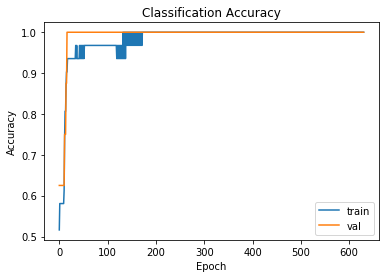

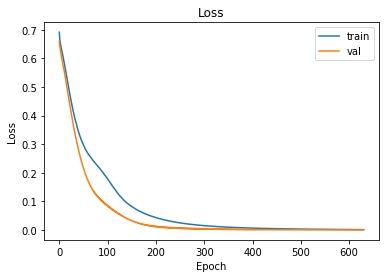

In [17]:
import matplotlib.pyplot as plt


%matplotlib inline

acc_history = history.history['acc']
val_acc_history = history.history['val_acc']
loss_history = history.history['loss']
val_loss_history = history.history['val_loss']

epochs = np.arange(len(acc_history))

plt.plot(epochs, acc_history, label='train')
plt.plot(epochs, val_acc_history, label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Classification Accuracy')
plt.legend()
plt.show()


plt.plot(epochs, loss_history, label='train')
plt.plot(epochs, val_loss_history, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()

In [18]:
%%time

from sklearn.model_selection import RepeatedStratifiedKFold

n_splits = 3
n_repeats = 20
n_total = n_splits * n_repeats
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

score_history = []

print('Fitting %d folds over %d repetitions for a total of %d fits.' % (n_splits, n_repeats, n_total))

for i, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    print('\nIteration %d of %d' % (i + 1, n_total))
    
    X_train_cv = X[train_idx]
    y_train_cv = y[train_idx]
    X_val_cv = X[val_idx]
    y_val_cv= y[val_idx]

    # Encoding is not done directly on y so that the k-fold splitter doesn't throw an exception.
    ohe = OneHotEncoder(sparse=False)
    y_train_cv = ohe.fit_transform(y_train_cv)
    y_val_cv = ohe.fit_transform(y_val_cv)
    
    model = get_model() 

    history = model.fit(X_train_cv, y_train_cv,
              epochs=200,
              validation_data=(X_val_cv, y_val_cv))
    
    score_history.append(history.history)

    score = model.evaluate(X_val_cv, y_val_cv, verbose=0)
    print('Validation loss: %.2f' % score[0])
    print('Validation accuracy: %.2f' % score[1])

Fitting 3 folds over 20 repetitions for a total of 60 fits.

Iteration 1 of 60
Train on 25 samples, validate on 14 samples
Epoch 1/200
25/25 [==============================] - 0s 7ms/step - loss: 0.6817 - acc: 0.6000 - val_loss: 0.6572 - val_acc: 0.5714
Epoch 2/200
25/25 [==============================] - 0s 1ms/step - loss: 0.6539 - acc: 0.6000 - val_loss: 0.6445 - val_acc: 0.5714
Epoch 3/200
25/25 [==============================] - 0s 1ms/step - loss: 0.6392 - acc: 0.6000 - val_loss: 0.6357 - val_acc: 0.5714
Epoch 4/200
25/25 [==============================] - 0s 1ms/step - loss: 0.6293 - acc: 0.6000 - val_loss: 0.6282 - val_acc: 0.5714
Epoch 5/200
25/25 [==============================] - 0s 1ms/step - loss: 0.6214 - acc: 0.6000 - val_loss: 0.6206 - val_acc: 0.5714
Epoch 6/200
25/25 [==============================] - 0s 1ms/step - loss: 0.6140 - acc: 0.6000 - val_loss: 0.6125 - val_acc: 0.5714
Epoch 7/200
25/25 [==============================] - 0s 1ms/step - loss: 0.6064 - acc: 0.60

Epoch 63/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2328 - acc: 0.9600 - val_loss: 0.1875 - val_acc: 1.0000
Epoch 64/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2292 - acc: 0.9600 - val_loss: 0.1833 - val_acc: 1.0000
Epoch 65/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2256 - acc: 0.9600 - val_loss: 0.1837 - val_acc: 1.0000
Epoch 66/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2220 - acc: 0.9600 - val_loss: 0.1793 - val_acc: 1.0000
Epoch 67/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2185 - acc: 0.9600 - val_loss: 0.1808 - val_acc: 1.0000
Epoch 68/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2150 - acc: 0.9600 - val_loss: 0.1755 - val_acc: 1.0000
Epoch 69/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2116 - acc: 0.9600 - val_loss: 0.1786 - val_acc: 1.0000
Epoch 70/200
25/25 [==============================] - 0s 1ms/step - loss: 0.

Epoch 125/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0523 - acc: 1.0000 - val_loss: 0.1224 - val_acc: 1.0000
Epoch 126/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0509 - acc: 1.0000 - val_loss: 0.1233 - val_acc: 0.9286
Epoch 127/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0496 - acc: 1.0000 - val_loss: 0.1206 - val_acc: 1.0000
Epoch 128/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0482 - acc: 1.0000 - val_loss: 0.1219 - val_acc: 0.9286
Epoch 129/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0469 - acc: 1.0000 - val_loss: 0.1188 - val_acc: 1.0000
Epoch 130/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0456 - acc: 1.0000 - val_loss: 0.1206 - val_acc: 0.9286
Epoch 131/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0444 - acc: 1.0000 - val_loss: 0.1170 - val_acc: 0.9286
Epoch 132/200
25/25 [==============================] - 0s 1ms/step - 

Epoch 187/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0094 - acc: 1.0000 - val_loss: 0.0813 - val_acc: 0.9286
Epoch 188/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0091 - acc: 1.0000 - val_loss: 0.0949 - val_acc: 0.9286
Epoch 189/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0089 - acc: 1.0000 - val_loss: 0.0805 - val_acc: 0.9286
Epoch 190/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0086 - acc: 1.0000 - val_loss: 0.0944 - val_acc: 0.9286
Epoch 191/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0084 - acc: 1.0000 - val_loss: 0.0797 - val_acc: 0.9286
Epoch 192/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0082 - acc: 1.0000 - val_loss: 0.0939 - val_acc: 0.9286
Epoch 193/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0079 - acc: 1.0000 - val_loss: 0.0789 - val_acc: 0.9286
Epoch 194/200
25/25 [==============================] - 0s 1ms/step - 

Epoch 49/200
26/26 [==============================] - 0s 1ms/step - loss: 0.3354 - acc: 0.9615 - val_loss: 0.2388 - val_acc: 1.0000
Epoch 50/200
26/26 [==============================] - 0s 1ms/step - loss: 0.3314 - acc: 0.9615 - val_loss: 0.2265 - val_acc: 1.0000
Epoch 51/200
26/26 [==============================] - 0s 1ms/step - loss: 0.3277 - acc: 0.9615 - val_loss: 0.2311 - val_acc: 1.0000
Epoch 52/200
26/26 [==============================] - 0s 1ms/step - loss: 0.3241 - acc: 0.9615 - val_loss: 0.2149 - val_acc: 1.0000
Epoch 53/200
26/26 [==============================] - 0s 1ms/step - loss: 0.3206 - acc: 0.9615 - val_loss: 0.2217 - val_acc: 1.0000
Epoch 54/200
26/26 [==============================] - 0s 1ms/step - loss: 0.3169 - acc: 0.9615 - val_loss: 0.2066 - val_acc: 1.0000
Epoch 55/200
26/26 [==============================] - 0s 1ms/step - loss: 0.3134 - acc: 0.9615 - val_loss: 0.2111 - val_acc: 1.0000
Epoch 56/200
26/26 [==============================] - 0s 1ms/step - loss: 0.

Epoch 111/200
26/26 [==============================] - 0s 1ms/step - loss: 0.1603 - acc: 0.9615 - val_loss: 0.1190 - val_acc: 1.0000
Epoch 112/200
26/26 [==============================] - 0s 1ms/step - loss: 0.1576 - acc: 0.9615 - val_loss: 0.0997 - val_acc: 1.0000
Epoch 113/200
26/26 [==============================] - 0s 1ms/step - loss: 0.1551 - acc: 0.9615 - val_loss: 0.1164 - val_acc: 1.0000
Epoch 114/200
26/26 [==============================] - 0s 1ms/step - loss: 0.1525 - acc: 0.9615 - val_loss: 0.0969 - val_acc: 1.0000
Epoch 115/200
26/26 [==============================] - 0s 1ms/step - loss: 0.1501 - acc: 0.9615 - val_loss: 0.1138 - val_acc: 1.0000
Epoch 116/200
26/26 [==============================] - 0s 1ms/step - loss: 0.1476 - acc: 0.9615 - val_loss: 0.0941 - val_acc: 1.0000
Epoch 117/200
26/26 [==============================] - 0s 1ms/step - loss: 0.1452 - acc: 0.9615 - val_loss: 0.1111 - val_acc: 1.0000
Epoch 118/200
26/26 [==============================] - 0s 1ms/step - 

Epoch 173/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0630 - acc: 1.0000 - val_loss: 0.0554 - val_acc: 1.0000
Epoch 174/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0621 - acc: 1.0000 - val_loss: 0.0384 - val_acc: 1.0000
Epoch 175/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0614 - acc: 1.0000 - val_loss: 0.0544 - val_acc: 1.0000
Epoch 176/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0605 - acc: 1.0000 - val_loss: 0.0375 - val_acc: 1.0000
Epoch 177/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0597 - acc: 1.0000 - val_loss: 0.0535 - val_acc: 1.0000
Epoch 178/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0589 - acc: 1.0000 - val_loss: 0.0367 - val_acc: 1.0000
Epoch 179/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0582 - acc: 1.0000 - val_loss: 0.0526 - val_acc: 1.0000
Epoch 180/200
26/26 [==============================] - 0s 1ms/step - 

27/27 [==============================] - 0s 1ms/step - loss: 0.3212 - acc: 0.9630 - val_loss: 0.4446 - val_acc: 0.9167
Epoch 35/200
27/27 [==============================] - 0s 1ms/step - loss: 0.3121 - acc: 0.9630 - val_loss: 0.4447 - val_acc: 0.9167
Epoch 36/200
27/27 [==============================] - 0s 1ms/step - loss: 0.3035 - acc: 0.9630 - val_loss: 0.4320 - val_acc: 0.9167
Epoch 37/200
27/27 [==============================] - 0s 1ms/step - loss: 0.2963 - acc: 1.0000 - val_loss: 0.4439 - val_acc: 0.9167
Epoch 38/200
27/27 [==============================] - 0s 1ms/step - loss: 0.2881 - acc: 0.9630 - val_loss: 0.4279 - val_acc: 0.9167
Epoch 39/200
27/27 [==============================] - 0s 1ms/step - loss: 0.2786 - acc: 0.9630 - val_loss: 0.4307 - val_acc: 0.9167
Epoch 40/200
27/27 [==============================] - 0s 1ms/step - loss: 0.2703 - acc: 0.9630 - val_loss: 0.4241 - val_acc: 0.9167
Epoch 41/200
27/27 [==============================] - 0s 1ms/step - loss: 0.2625 - acc: 0

Epoch 97/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0553 - acc: 1.0000 - val_loss: 0.5632 - val_acc: 0.9167
Epoch 98/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0539 - acc: 1.0000 - val_loss: 0.5512 - val_acc: 0.9167
Epoch 99/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0525 - acc: 1.0000 - val_loss: 0.5752 - val_acc: 0.9167
Epoch 100/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0512 - acc: 1.0000 - val_loss: 0.5633 - val_acc: 0.9167
Epoch 101/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0499 - acc: 1.0000 - val_loss: 0.5872 - val_acc: 0.9167
Epoch 102/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0486 - acc: 1.0000 - val_loss: 0.5758 - val_acc: 0.9167
Epoch 103/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0474 - acc: 1.0000 - val_loss: 0.5996 - val_acc: 0.9167
Epoch 104/200
27/27 [==============================] - 0s 1ms/step - los

Epoch 159/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0106 - acc: 1.0000 - val_loss: 1.1116 - val_acc: 0.9167
Epoch 160/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0103 - acc: 1.0000 - val_loss: 1.0931 - val_acc: 0.9167
Epoch 161/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0100 - acc: 1.0000 - val_loss: 1.1343 - val_acc: 0.9167
Epoch 162/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0097 - acc: 1.0000 - val_loss: 1.1154 - val_acc: 0.9167
Epoch 163/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0094 - acc: 1.0000 - val_loss: 1.1572 - val_acc: 0.9167
Epoch 164/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0092 - acc: 1.0000 - val_loss: 1.1380 - val_acc: 0.9167
Epoch 165/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0089 - acc: 1.0000 - val_loss: 1.1802 - val_acc: 0.9167
Epoch 166/200
27/27 [==============================] - 0s 1ms/step - 

Epoch 20/200
25/25 [==============================] - 0s 1ms/step - loss: 0.4852 - acc: 0.9200 - val_loss: 0.5204 - val_acc: 0.8571
Epoch 21/200
25/25 [==============================] - 0s 1ms/step - loss: 0.4748 - acc: 0.9200 - val_loss: 0.5120 - val_acc: 0.8571
Epoch 22/200
25/25 [==============================] - 0s 1ms/step - loss: 0.4645 - acc: 0.9200 - val_loss: 0.5039 - val_acc: 0.8571
Epoch 23/200
25/25 [==============================] - 0s 1ms/step - loss: 0.4542 - acc: 0.9600 - val_loss: 0.4958 - val_acc: 0.9286
Epoch 24/200
25/25 [==============================] - 0s 1ms/step - loss: 0.4439 - acc: 0.9600 - val_loss: 0.4880 - val_acc: 0.9286
Epoch 25/200
25/25 [==============================] - 0s 1ms/step - loss: 0.4338 - acc: 0.9600 - val_loss: 0.4803 - val_acc: 0.9286
Epoch 26/200
25/25 [==============================] - 0s 1ms/step - loss: 0.4238 - acc: 0.9600 - val_loss: 0.4728 - val_acc: 0.9286
Epoch 27/200
25/25 [==============================] - 0s 1ms/step - loss: 0.

Epoch 83/200
25/25 [==============================] - 0s 1ms/step - loss: 0.1036 - acc: 0.9600 - val_loss: 0.3826 - val_acc: 0.9286
Epoch 84/200
25/25 [==============================] - 0s 1ms/step - loss: 0.1012 - acc: 1.0000 - val_loss: 0.3993 - val_acc: 0.9286
Epoch 85/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0989 - acc: 0.9600 - val_loss: 0.3887 - val_acc: 0.9286
Epoch 86/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0966 - acc: 1.0000 - val_loss: 0.4053 - val_acc: 0.9286
Epoch 87/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0945 - acc: 0.9600 - val_loss: 0.3947 - val_acc: 0.9286
Epoch 88/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0923 - acc: 1.0000 - val_loss: 0.4122 - val_acc: 0.9286
Epoch 89/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0903 - acc: 0.9600 - val_loss: 0.4009 - val_acc: 0.9286
Epoch 90/200
25/25 [==============================] - 0s 1ms/step - loss: 0.

Epoch 145/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0265 - acc: 1.0000 - val_loss: 0.7187 - val_acc: 0.9286
Epoch 146/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0259 - acc: 1.0000 - val_loss: 0.7534 - val_acc: 0.9286
Epoch 147/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0253 - acc: 1.0000 - val_loss: 0.7342 - val_acc: 0.9286
Epoch 148/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0247 - acc: 1.0000 - val_loss: 0.7694 - val_acc: 0.9286
Epoch 149/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0242 - acc: 1.0000 - val_loss: 0.7498 - val_acc: 0.9286
Epoch 150/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0236 - acc: 1.0000 - val_loss: 0.7856 - val_acc: 0.9286
Epoch 151/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0231 - acc: 1.0000 - val_loss: 0.7656 - val_acc: 0.9286
Epoch 152/200
25/25 [==============================] - 0s 1ms/step - 

Epoch 6/200
26/26 [==============================] - 0s 1ms/step - loss: 0.6203 - acc: 0.5769 - val_loss: 0.5990 - val_acc: 0.6154
Epoch 7/200
26/26 [==============================] - 0s 1ms/step - loss: 0.6110 - acc: 0.5769 - val_loss: 0.5898 - val_acc: 0.6154
Epoch 8/200
26/26 [==============================] - 0s 1ms/step - loss: 0.6014 - acc: 0.5769 - val_loss: 0.5804 - val_acc: 0.6923
Epoch 9/200
26/26 [==============================] - 0s 1ms/step - loss: 0.5915 - acc: 0.6154 - val_loss: 0.5707 - val_acc: 0.7692
Epoch 10/200
26/26 [==============================] - 0s 1ms/step - loss: 0.5813 - acc: 0.7692 - val_loss: 0.5609 - val_acc: 0.7692
Epoch 11/200
26/26 [==============================] - 0s 1ms/step - loss: 0.5709 - acc: 0.8462 - val_loss: 0.5509 - val_acc: 0.7692
Epoch 12/200
26/26 [==============================] - 0s 1ms/step - loss: 0.5604 - acc: 0.8462 - val_loss: 0.5409 - val_acc: 0.8462
Epoch 13/200
26/26 [==============================] - 0s 1ms/step - loss: 0.5498

26/26 [==============================] - 0s 1ms/step - loss: 0.2237 - acc: 0.9615 - val_loss: 0.2184 - val_acc: 1.0000
Epoch 69/200
26/26 [==============================] - 0s 1ms/step - loss: 0.2209 - acc: 0.9615 - val_loss: 0.2058 - val_acc: 1.0000
Epoch 70/200
26/26 [==============================] - 0s 1ms/step - loss: 0.2182 - acc: 0.9615 - val_loss: 0.2160 - val_acc: 1.0000
Epoch 71/200
26/26 [==============================] - 0s 1ms/step - loss: 0.2154 - acc: 0.9615 - val_loss: 0.2026 - val_acc: 1.0000
Epoch 72/200
26/26 [==============================] - 0s 1ms/step - loss: 0.2126 - acc: 0.9615 - val_loss: 0.2129 - val_acc: 1.0000
Epoch 73/200
26/26 [==============================] - 0s 1ms/step - loss: 0.2096 - acc: 0.9615 - val_loss: 0.2001 - val_acc: 1.0000
Epoch 74/200
26/26 [==============================] - 0s 1ms/step - loss: 0.2067 - acc: 0.9615 - val_loss: 0.2097 - val_acc: 1.0000
Epoch 75/200
26/26 [==============================] - 0s 1ms/step - loss: 0.2037 - acc: 0

Epoch 130/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0602 - acc: 1.0000 - val_loss: 0.1437 - val_acc: 0.9231
Epoch 131/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0588 - acc: 1.0000 - val_loss: 0.1410 - val_acc: 0.9231
Epoch 132/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0575 - acc: 1.0000 - val_loss: 0.1417 - val_acc: 0.9231
Epoch 133/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0561 - acc: 1.0000 - val_loss: 0.1396 - val_acc: 0.9231
Epoch 134/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0549 - acc: 1.0000 - val_loss: 0.1398 - val_acc: 0.9231
Epoch 135/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0536 - acc: 1.0000 - val_loss: 0.1382 - val_acc: 0.9231
Epoch 136/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0525 - acc: 1.0000 - val_loss: 0.1379 - val_acc: 0.9231
Epoch 137/200
26/26 [==============================] - 0s 1ms/step - 

Epoch 192/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0155 - acc: 1.0000 - val_loss: 0.0993 - val_acc: 0.9231
Epoch 193/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0151 - acc: 1.0000 - val_loss: 0.1079 - val_acc: 0.9231
Epoch 194/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0148 - acc: 1.0000 - val_loss: 0.0983 - val_acc: 0.9231
Epoch 195/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0145 - acc: 1.0000 - val_loss: 0.1071 - val_acc: 0.9231
Epoch 196/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0142 - acc: 1.0000 - val_loss: 0.0973 - val_acc: 0.9231
Epoch 197/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0139 - acc: 1.0000 - val_loss: 0.1064 - val_acc: 0.9231
Epoch 198/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0136 - acc: 1.0000 - val_loss: 0.0963 - val_acc: 0.9231
Epoch 199/200
26/26 [==============================] - 0s 1ms/step - 

Epoch 54/200
27/27 [==============================] - 0s 1ms/step - loss: 0.3121 - acc: 0.9259 - val_loss: 0.2028 - val_acc: 1.0000
Epoch 55/200
27/27 [==============================] - 0s 1ms/step - loss: 0.3083 - acc: 0.9630 - val_loss: 0.1925 - val_acc: 1.0000
Epoch 56/200
27/27 [==============================] - 0s 1ms/step - loss: 0.3048 - acc: 0.9259 - val_loss: 0.1940 - val_acc: 1.0000
Epoch 57/200
27/27 [==============================] - 0s 1ms/step - loss: 0.3013 - acc: 0.9630 - val_loss: 0.1815 - val_acc: 1.0000
Epoch 58/200
27/27 [==============================] - 0s 1ms/step - loss: 0.2978 - acc: 0.9259 - val_loss: 0.1832 - val_acc: 1.0000
Epoch 59/200
27/27 [==============================] - 0s 1ms/step - loss: 0.2940 - acc: 0.9630 - val_loss: 0.1726 - val_acc: 1.0000
Epoch 60/200
27/27 [==============================] - 0s 1ms/step - loss: 0.2905 - acc: 0.9259 - val_loss: 0.1727 - val_acc: 1.0000
Epoch 61/200
27/27 [==============================] - 0s 1ms/step - loss: 0.

Epoch 116/200
27/27 [==============================] - 0s 1ms/step - loss: 0.1344 - acc: 0.9259 - val_loss: 0.0696 - val_acc: 1.0000
Epoch 117/200
27/27 [==============================] - 0s 1ms/step - loss: 0.1319 - acc: 1.0000 - val_loss: 0.0590 - val_acc: 1.0000
Epoch 118/200
27/27 [==============================] - 0s 1ms/step - loss: 0.1297 - acc: 0.9259 - val_loss: 0.0678 - val_acc: 1.0000
Epoch 119/200
27/27 [==============================] - 0s 1ms/step - loss: 0.1273 - acc: 1.0000 - val_loss: 0.0571 - val_acc: 1.0000
Epoch 120/200
27/27 [==============================] - 0s 1ms/step - loss: 0.1252 - acc: 0.9259 - val_loss: 0.0661 - val_acc: 1.0000
Epoch 121/200
27/27 [==============================] - 0s 1ms/step - loss: 0.1229 - acc: 1.0000 - val_loss: 0.0552 - val_acc: 1.0000
Epoch 122/200
27/27 [==============================] - 0s 1ms/step - loss: 0.1209 - acc: 0.9259 - val_loss: 0.0644 - val_acc: 1.0000
Epoch 123/200
27/27 [==============================] - 0s 1ms/step - 

Epoch 178/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0521 - acc: 1.0000 - val_loss: 0.0318 - val_acc: 1.0000
Epoch 179/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0513 - acc: 1.0000 - val_loss: 0.0213 - val_acc: 1.0000
Epoch 180/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0507 - acc: 1.0000 - val_loss: 0.0311 - val_acc: 1.0000
Epoch 181/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0499 - acc: 1.0000 - val_loss: 0.0207 - val_acc: 1.0000
Epoch 182/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0493 - acc: 1.0000 - val_loss: 0.0305 - val_acc: 1.0000
Epoch 183/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0486 - acc: 1.0000 - val_loss: 0.0200 - val_acc: 1.0000
Epoch 184/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0480 - acc: 1.0000 - val_loss: 0.0298 - val_acc: 1.0000
Epoch 185/200
27/27 [==============================] - 0s 1ms/step - 

Epoch 40/200
25/25 [==============================] - 0s 1ms/step - loss: 0.3471 - acc: 0.9200 - val_loss: 0.2439 - val_acc: 1.0000
Epoch 41/200
25/25 [==============================] - 0s 1ms/step - loss: 0.3419 - acc: 0.9200 - val_loss: 0.2356 - val_acc: 1.0000
Epoch 42/200
25/25 [==============================] - 0s 1ms/step - loss: 0.3369 - acc: 0.9200 - val_loss: 0.2304 - val_acc: 1.0000
Epoch 43/200
25/25 [==============================] - 0s 1ms/step - loss: 0.3321 - acc: 0.9200 - val_loss: 0.2225 - val_acc: 1.0000
Epoch 44/200
25/25 [==============================] - 0s 1ms/step - loss: 0.3274 - acc: 0.9200 - val_loss: 0.2184 - val_acc: 1.0000
Epoch 45/200
25/25 [==============================] - 0s 1ms/step - loss: 0.3228 - acc: 0.9200 - val_loss: 0.2100 - val_acc: 1.0000
Epoch 46/200
25/25 [==============================] - 0s 1ms/step - loss: 0.3185 - acc: 0.9200 - val_loss: 0.2083 - val_acc: 1.0000
Epoch 47/200
25/25 [==============================] - 0s 1ms/step - loss: 0.

25/25 [==============================] - 0s 1ms/step - loss: 0.1356 - acc: 0.9600 - val_loss: 0.0946 - val_acc: 1.0000
Epoch 103/200
25/25 [==============================] - 0s 1ms/step - loss: 0.1333 - acc: 1.0000 - val_loss: 0.0828 - val_acc: 1.0000
Epoch 104/200
25/25 [==============================] - 0s 1ms/step - loss: 0.1312 - acc: 0.9600 - val_loss: 0.0918 - val_acc: 1.0000
Epoch 105/200
25/25 [==============================] - 0s 1ms/step - loss: 0.1290 - acc: 1.0000 - val_loss: 0.0803 - val_acc: 1.0000
Epoch 106/200
25/25 [==============================] - 0s 1ms/step - loss: 0.1270 - acc: 0.9600 - val_loss: 0.0891 - val_acc: 1.0000
Epoch 107/200
25/25 [==============================] - 0s 1ms/step - loss: 0.1248 - acc: 1.0000 - val_loss: 0.0778 - val_acc: 1.0000
Epoch 108/200
25/25 [==============================] - 0s 1ms/step - loss: 0.1230 - acc: 0.9600 - val_loss: 0.0865 - val_acc: 1.0000
Epoch 109/200
25/25 [==============================] - 0s 1ms/step - loss: 0.1210 -

Epoch 164/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0584 - acc: 1.0000 - val_loss: 0.0343 - val_acc: 1.0000
Epoch 165/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0576 - acc: 1.0000 - val_loss: 0.0258 - val_acc: 1.0000
Epoch 166/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0570 - acc: 1.0000 - val_loss: 0.0332 - val_acc: 1.0000
Epoch 167/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0562 - acc: 1.0000 - val_loss: 0.0248 - val_acc: 1.0000
Epoch 168/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0557 - acc: 1.0000 - val_loss: 0.0322 - val_acc: 1.0000
Epoch 169/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0549 - acc: 1.0000 - val_loss: 0.0238 - val_acc: 1.0000
Epoch 170/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0543 - acc: 1.0000 - val_loss: 0.0312 - val_acc: 1.0000
Epoch 171/200
25/25 [==============================] - 0s 1ms/step - 

26/26 [==============================] - 0s 1ms/step - loss: 0.4539 - acc: 0.9231 - val_loss: 0.3843 - val_acc: 1.0000
Epoch 26/200
26/26 [==============================] - 0s 1ms/step - loss: 0.4451 - acc: 0.9231 - val_loss: 0.3743 - val_acc: 1.0000
Epoch 27/200
26/26 [==============================] - 0s 1ms/step - loss: 0.4365 - acc: 0.9231 - val_loss: 0.3645 - val_acc: 1.0000
Epoch 28/200
26/26 [==============================] - 0s 1ms/step - loss: 0.4281 - acc: 0.9231 - val_loss: 0.3553 - val_acc: 1.0000
Epoch 29/200
26/26 [==============================] - 0s 1ms/step - loss: 0.4198 - acc: 0.9231 - val_loss: 0.3444 - val_acc: 1.0000
Epoch 30/200
26/26 [==============================] - 0s 1ms/step - loss: 0.4119 - acc: 0.9231 - val_loss: 0.3428 - val_acc: 1.0000
Epoch 31/200
26/26 [==============================] - 0s 1ms/step - loss: 0.4050 - acc: 0.9615 - val_loss: 0.3207 - val_acc: 1.0000
Epoch 32/200
26/26 [==============================] - 0s 1ms/step - loss: 0.3999 - acc: 0

Epoch 88/200
26/26 [==============================] - 0s 1ms/step - loss: 0.1867 - acc: 0.9615 - val_loss: 0.1326 - val_acc: 1.0000
Epoch 89/200
26/26 [==============================] - 0s 1ms/step - loss: 0.1838 - acc: 0.9615 - val_loss: 0.1087 - val_acc: 1.0000
Epoch 90/200
26/26 [==============================] - 0s 1ms/step - loss: 0.1811 - acc: 0.9615 - val_loss: 0.1300 - val_acc: 1.0000
Epoch 91/200
26/26 [==============================] - 0s 1ms/step - loss: 0.1782 - acc: 0.9615 - val_loss: 0.1061 - val_acc: 1.0000
Epoch 92/200
26/26 [==============================] - 0s 1ms/step - loss: 0.1754 - acc: 0.9615 - val_loss: 0.1276 - val_acc: 1.0000
Epoch 93/200
26/26 [==============================] - 0s 1ms/step - loss: 0.1726 - acc: 0.9615 - val_loss: 0.1034 - val_acc: 1.0000
Epoch 94/200
26/26 [==============================] - 0s 1ms/step - loss: 0.1699 - acc: 0.9615 - val_loss: 0.1256 - val_acc: 1.0000
Epoch 95/200
26/26 [==============================] - 0s 1ms/step - loss: 0.

Epoch 150/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0655 - acc: 1.0000 - val_loss: 0.0753 - val_acc: 1.0000
Epoch 151/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0644 - acc: 1.0000 - val_loss: 0.0509 - val_acc: 1.0000
Epoch 152/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0635 - acc: 1.0000 - val_loss: 0.0744 - val_acc: 1.0000
Epoch 153/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0624 - acc: 1.0000 - val_loss: 0.0499 - val_acc: 1.0000
Epoch 154/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0616 - acc: 1.0000 - val_loss: 0.0735 - val_acc: 1.0000
Epoch 155/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0606 - acc: 1.0000 - val_loss: 0.0490 - val_acc: 1.0000
Epoch 156/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0598 - acc: 1.0000 - val_loss: 0.0726 - val_acc: 1.0000
Epoch 157/200
26/26 [==============================] - 0s 1ms/step - 

Epoch 11/200
27/27 [==============================] - 0s 1ms/step - loss: 0.5545 - acc: 0.5926 - val_loss: 0.6086 - val_acc: 0.5833
Epoch 12/200
27/27 [==============================] - 0s 1ms/step - loss: 0.5432 - acc: 0.6667 - val_loss: 0.6025 - val_acc: 0.5833
Epoch 13/200
27/27 [==============================] - 0s 1ms/step - loss: 0.5317 - acc: 0.7778 - val_loss: 0.5963 - val_acc: 0.6667
Epoch 14/200
27/27 [==============================] - 0s 1ms/step - loss: 0.5201 - acc: 0.8519 - val_loss: 0.5901 - val_acc: 0.6667
Epoch 15/200
27/27 [==============================] - 0s 1ms/step - loss: 0.5084 - acc: 0.8519 - val_loss: 0.5840 - val_acc: 0.7500
Epoch 16/200
27/27 [==============================] - 0s 1ms/step - loss: 0.4967 - acc: 0.8519 - val_loss: 0.5779 - val_acc: 0.7500
Epoch 17/200
27/27 [==============================] - 0s 1ms/step - loss: 0.4850 - acc: 0.8889 - val_loss: 0.5719 - val_acc: 0.7500
Epoch 18/200
27/27 [==============================] - 0s 1ms/step - loss: 0.

Epoch 73/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0865 - acc: 1.0000 - val_loss: 0.5109 - val_acc: 0.8333
Epoch 74/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0836 - acc: 1.0000 - val_loss: 0.5320 - val_acc: 0.8333
Epoch 75/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0809 - acc: 1.0000 - val_loss: 0.5171 - val_acc: 0.8333
Epoch 76/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0783 - acc: 1.0000 - val_loss: 0.5405 - val_acc: 0.8333
Epoch 77/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0757 - acc: 1.0000 - val_loss: 0.5229 - val_acc: 0.8333
Epoch 78/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0733 - acc: 1.0000 - val_loss: 0.5502 - val_acc: 0.8333
Epoch 79/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0709 - acc: 1.0000 - val_loss: 0.5289 - val_acc: 0.8333
Epoch 80/200
27/27 [==============================] - 0s 1ms/step - loss: 0.

Epoch 135/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0102 - acc: 1.0000 - val_loss: 0.8679 - val_acc: 0.8333
Epoch 136/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0098 - acc: 1.0000 - val_loss: 0.9094 - val_acc: 0.8333
Epoch 137/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0095 - acc: 1.0000 - val_loss: 0.8838 - val_acc: 0.8333
Epoch 138/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0091 - acc: 1.0000 - val_loss: 0.9253 - val_acc: 0.8333
Epoch 139/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0088 - acc: 1.0000 - val_loss: 0.9000 - val_acc: 0.8333
Epoch 140/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0085 - acc: 1.0000 - val_loss: 0.9413 - val_acc: 0.8333
Epoch 141/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0082 - acc: 1.0000 - val_loss: 0.9165 - val_acc: 0.8333
Epoch 142/200
27/27 [==============================] - 0s 1ms/step - 

Epoch 197/200
27/27 [==============================] - 0s 996us/step - loss: 9.1326e-04 - acc: 1.0000 - val_loss: 1.3963 - val_acc: 0.9167
Epoch 198/200
27/27 [==============================] - 0s 1ms/step - loss: 8.7621e-04 - acc: 1.0000 - val_loss: 1.4080 - val_acc: 0.8333
Epoch 199/200
27/27 [==============================] - 0s 1ms/step - loss: 8.4114e-04 - acc: 1.0000 - val_loss: 1.3959 - val_acc: 0.9167
Epoch 200/200
27/27 [==============================] - 0s 1ms/step - loss: 8.0690e-04 - acc: 1.0000 - val_loss: 1.4076 - val_acc: 0.8333
Validation loss: 1.41
Validation accuracy: 0.83

Iteration 10 of 60
Train on 25 samples, validate on 14 samples
Epoch 1/200
25/25 [==============================] - 0s 17ms/step - loss: 0.7137 - acc: 0.4000 - val_loss: 0.6851 - val_acc: 0.5714
Epoch 2/200
25/25 [==============================] - 0s 1ms/step - loss: 0.6833 - acc: 0.6000 - val_loss: 0.6687 - val_acc: 0.5714
Epoch 3/200
25/25 [==============================] - 0s 1ms/step - loss: 0.

25/25 [==============================] - 0s 1ms/step - loss: 0.2954 - acc: 0.9600 - val_loss: 0.1874 - val_acc: 1.0000
Epoch 59/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2925 - acc: 0.9200 - val_loss: 0.1875 - val_acc: 1.0000
Epoch 60/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2891 - acc: 0.9600 - val_loss: 0.1806 - val_acc: 1.0000
Epoch 61/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2860 - acc: 0.9200 - val_loss: 0.1802 - val_acc: 1.0000
Epoch 62/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2830 - acc: 0.9600 - val_loss: 0.1746 - val_acc: 1.0000
Epoch 63/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2800 - acc: 0.9200 - val_loss: 0.1741 - val_acc: 1.0000
Epoch 64/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2771 - acc: 0.9600 - val_loss: 0.1691 - val_acc: 1.0000
Epoch 65/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2743 - acc: 0

Epoch 120/200
25/25 [==============================] - 0s 1ms/step - loss: 0.1144 - acc: 0.9600 - val_loss: 0.0938 - val_acc: 1.0000
Epoch 121/200
25/25 [==============================] - 0s 1ms/step - loss: 0.1125 - acc: 0.9600 - val_loss: 0.0977 - val_acc: 1.0000
Epoch 122/200
25/25 [==============================] - 0s 1ms/step - loss: 0.1105 - acc: 0.9600 - val_loss: 0.0916 - val_acc: 1.0000
Epoch 123/200
25/25 [==============================] - 0s 1ms/step - loss: 0.1087 - acc: 0.9600 - val_loss: 0.0956 - val_acc: 1.0000
Epoch 124/200
25/25 [==============================] - 0s 1ms/step - loss: 0.1068 - acc: 0.9600 - val_loss: 0.0894 - val_acc: 1.0000
Epoch 125/200
25/25 [==============================] - 0s 1ms/step - loss: 0.1051 - acc: 0.9600 - val_loss: 0.0934 - val_acc: 1.0000
Epoch 126/200
25/25 [==============================] - 0s 1ms/step - loss: 0.1033 - acc: 0.9600 - val_loss: 0.0872 - val_acc: 1.0000
Epoch 127/200
25/25 [==============================] - 0s 1ms/step - 

Epoch 182/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0500 - acc: 1.0000 - val_loss: 0.0405 - val_acc: 1.0000
Epoch 183/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0495 - acc: 1.0000 - val_loss: 0.0543 - val_acc: 1.0000
Epoch 184/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0488 - acc: 1.0000 - val_loss: 0.0396 - val_acc: 1.0000
Epoch 185/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0484 - acc: 1.0000 - val_loss: 0.0537 - val_acc: 1.0000
Epoch 186/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0477 - acc: 1.0000 - val_loss: 0.0388 - val_acc: 1.0000
Epoch 187/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0473 - acc: 1.0000 - val_loss: 0.0532 - val_acc: 1.0000
Epoch 188/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0466 - acc: 1.0000 - val_loss: 0.0381 - val_acc: 1.0000
Epoch 189/200
25/25 [==============================] - 0s 1ms/step - 

26/26 [==============================] - 0s 1ms/step - loss: 0.2721 - acc: 1.0000 - val_loss: 0.4267 - val_acc: 0.8462
Epoch 44/200
26/26 [==============================] - 0s 1ms/step - loss: 0.2645 - acc: 1.0000 - val_loss: 0.4292 - val_acc: 0.8462
Epoch 45/200
26/26 [==============================] - 0s 1ms/step - loss: 0.2571 - acc: 1.0000 - val_loss: 0.4209 - val_acc: 0.8462
Epoch 46/200
26/26 [==============================] - 0s 1ms/step - loss: 0.2500 - acc: 1.0000 - val_loss: 0.4302 - val_acc: 0.8462
Epoch 47/200
26/26 [==============================] - 0s 1ms/step - loss: 0.2433 - acc: 1.0000 - val_loss: 0.4147 - val_acc: 0.8462
Epoch 48/200
26/26 [==============================] - 0s 988us/step - loss: 0.2367 - acc: 1.0000 - val_loss: 0.4311 - val_acc: 0.8462
Epoch 49/200
26/26 [==============================] - 0s 1ms/step - loss: 0.2302 - acc: 1.0000 - val_loss: 0.4133 - val_acc: 0.8462
Epoch 50/200
26/26 [==============================] - 0s 1ms/step - loss: 0.2234 - acc:

26/26 [==============================] - 0s 1ms/step - loss: 0.0438 - acc: 1.0000 - val_loss: 0.5532 - val_acc: 0.8462
Epoch 106/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0425 - acc: 1.0000 - val_loss: 0.5851 - val_acc: 0.8462
Epoch 107/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0413 - acc: 1.0000 - val_loss: 0.5630 - val_acc: 0.8462
Epoch 108/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0400 - acc: 1.0000 - val_loss: 0.5957 - val_acc: 0.8462
Epoch 109/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0388 - acc: 1.0000 - val_loss: 0.5734 - val_acc: 0.9231
Epoch 110/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0377 - acc: 1.0000 - val_loss: 0.6064 - val_acc: 0.8462
Epoch 111/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0365 - acc: 1.0000 - val_loss: 0.5842 - val_acc: 0.9231
Epoch 112/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0354 -

Epoch 167/200
26/26 [==============================] - 0s 996us/step - loss: 0.0060 - acc: 1.0000 - val_loss: 0.9741 - val_acc: 0.9231
Epoch 168/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0058 - acc: 1.0000 - val_loss: 1.0168 - val_acc: 0.8462
Epoch 169/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0056 - acc: 1.0000 - val_loss: 0.9910 - val_acc: 0.9231
Epoch 170/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0054 - acc: 1.0000 - val_loss: 1.0339 - val_acc: 0.9231
Epoch 171/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0052 - acc: 1.0000 - val_loss: 1.0080 - val_acc: 0.9231
Epoch 172/200
26/26 [==============================] - 0s 967us/step - loss: 0.0050 - acc: 1.0000 - val_loss: 1.0511 - val_acc: 0.9231
Epoch 173/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0049 - acc: 1.0000 - val_loss: 1.0252 - val_acc: 0.9231
Epoch 174/200
26/26 [==============================] - 0s 1ms/ste

Epoch 28/200
27/27 [==============================] - 0s 1ms/step - loss: 0.4274 - acc: 0.9259 - val_loss: 0.3826 - val_acc: 1.0000
Epoch 29/200
27/27 [==============================] - 0s 1ms/step - loss: 0.4191 - acc: 0.9259 - val_loss: 0.3727 - val_acc: 1.0000
Epoch 30/200
27/27 [==============================] - 0s 1ms/step - loss: 0.4110 - acc: 0.9259 - val_loss: 0.3629 - val_acc: 1.0000
Epoch 31/200
27/27 [==============================] - 0s 1ms/step - loss: 0.4031 - acc: 0.9259 - val_loss: 0.3533 - val_acc: 1.0000
Epoch 32/200
27/27 [==============================] - 0s 1ms/step - loss: 0.3954 - acc: 0.9259 - val_loss: 0.3440 - val_acc: 1.0000
Epoch 33/200
27/27 [==============================] - 0s 1ms/step - loss: 0.3879 - acc: 0.9259 - val_loss: 0.3349 - val_acc: 1.0000
Epoch 34/200
27/27 [==============================] - 0s 1ms/step - loss: 0.3806 - acc: 0.9259 - val_loss: 0.3260 - val_acc: 1.0000
Epoch 35/200
27/27 [==============================] - 0s 987us/step - loss: 

Epoch 90/200
27/27 [==============================] - 0s 963us/step - loss: 0.1714 - acc: 0.9630 - val_loss: 0.1209 - val_acc: 1.0000
Epoch 91/200
27/27 [==============================] - 0s 965us/step - loss: 0.1684 - acc: 0.9630 - val_loss: 0.1003 - val_acc: 1.0000
Epoch 92/200
27/27 [==============================] - 0s 1ms/step - loss: 0.1656 - acc: 0.9630 - val_loss: 0.1181 - val_acc: 1.0000
Epoch 93/200
27/27 [==============================] - 0s 983us/step - loss: 0.1627 - acc: 0.9630 - val_loss: 0.0964 - val_acc: 1.0000
Epoch 94/200
27/27 [==============================] - 0s 1ms/step - loss: 0.1599 - acc: 0.9630 - val_loss: 0.1149 - val_acc: 1.0000
Epoch 95/200
27/27 [==============================] - 0s 1ms/step - loss: 0.1570 - acc: 0.9630 - val_loss: 0.0929 - val_acc: 1.0000
Epoch 96/200
27/27 [==============================] - 0s 1ms/step - loss: 0.1542 - acc: 0.9630 - val_loss: 0.1111 - val_acc: 1.0000
Epoch 97/200
27/27 [==============================] - 0s 959us/step - 

Epoch 152/200
27/27 [==============================] - 0s 948us/step - loss: 0.0595 - acc: 1.0000 - val_loss: 0.0420 - val_acc: 1.0000
Epoch 153/200
27/27 [==============================] - 0s 954us/step - loss: 0.0585 - acc: 1.0000 - val_loss: 0.0284 - val_acc: 1.0000
Epoch 154/200
27/27 [==============================] - 0s 957us/step - loss: 0.0577 - acc: 1.0000 - val_loss: 0.0407 - val_acc: 1.0000
Epoch 155/200
27/27 [==============================] - 0s 941us/step - loss: 0.0568 - acc: 1.0000 - val_loss: 0.0274 - val_acc: 1.0000
Epoch 156/200
27/27 [==============================] - 0s 962us/step - loss: 0.0560 - acc: 1.0000 - val_loss: 0.0395 - val_acc: 1.0000
Epoch 157/200
27/27 [==============================] - 0s 931us/step - loss: 0.0551 - acc: 1.0000 - val_loss: 0.0263 - val_acc: 1.0000
Epoch 158/200
27/27 [==============================] - 0s 946us/step - loss: 0.0543 - acc: 1.0000 - val_loss: 0.0383 - val_acc: 1.0000
Epoch 159/200
27/27 [==============================] - 

Epoch 13/200
25/25 [==============================] - 0s 1ms/step - loss: 0.5523 - acc: 0.6000 - val_loss: 0.6201 - val_acc: 0.5714
Epoch 14/200
25/25 [==============================] - 0s 951us/step - loss: 0.5413 - acc: 0.6000 - val_loss: 0.6141 - val_acc: 0.5714
Epoch 15/200
25/25 [==============================] - 0s 970us/step - loss: 0.5301 - acc: 0.6800 - val_loss: 0.6080 - val_acc: 0.6429
Epoch 16/200
25/25 [==============================] - 0s 1ms/step - loss: 0.5186 - acc: 0.8000 - val_loss: 0.6018 - val_acc: 0.7143
Epoch 17/200
25/25 [==============================] - 0s 1ms/step - loss: 0.5069 - acc: 0.8400 - val_loss: 0.5955 - val_acc: 0.7143
Epoch 18/200
25/25 [==============================] - 0s 1ms/step - loss: 0.4951 - acc: 0.8800 - val_loss: 0.5891 - val_acc: 0.7143
Epoch 19/200
25/25 [==============================] - 0s 974us/step - loss: 0.4832 - acc: 0.8800 - val_loss: 0.5827 - val_acc: 0.7857
Epoch 20/200
25/25 [==============================] - 0s 985us/step - 

Epoch 75/200
25/25 [==============================] - 0s 970us/step - loss: 0.0780 - acc: 1.0000 - val_loss: 0.4864 - val_acc: 0.8571
Epoch 76/200
25/25 [==============================] - 0s 961us/step - loss: 0.0753 - acc: 1.0000 - val_loss: 0.5005 - val_acc: 0.8571
Epoch 77/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0726 - acc: 1.0000 - val_loss: 0.4933 - val_acc: 0.8571
Epoch 78/200
25/25 [==============================] - 0s 987us/step - loss: 0.0701 - acc: 1.0000 - val_loss: 0.5062 - val_acc: 0.8571
Epoch 79/200
25/25 [==============================] - 0s 951us/step - loss: 0.0676 - acc: 1.0000 - val_loss: 0.5000 - val_acc: 0.8571
Epoch 80/200
25/25 [==============================] - 0s 997us/step - loss: 0.0652 - acc: 1.0000 - val_loss: 0.5131 - val_acc: 0.8571
Epoch 81/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0630 - acc: 1.0000 - val_loss: 0.5065 - val_acc: 0.8571
Epoch 82/200
25/25 [==============================] - 0s 958us/ste

Epoch 137/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0079 - acc: 1.0000 - val_loss: 0.8160 - val_acc: 0.9286
Epoch 138/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0076 - acc: 1.0000 - val_loss: 0.8430 - val_acc: 0.9286
Epoch 139/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0073 - acc: 1.0000 - val_loss: 0.8301 - val_acc: 0.9286
Epoch 140/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0070 - acc: 1.0000 - val_loss: 0.8579 - val_acc: 0.9286
Epoch 141/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0067 - acc: 1.0000 - val_loss: 0.8444 - val_acc: 0.9286
Epoch 142/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0065 - acc: 1.0000 - val_loss: 0.8729 - val_acc: 0.9286
Epoch 143/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0062 - acc: 1.0000 - val_loss: 0.8589 - val_acc: 0.9286
Epoch 144/200
25/25 [==============================] - 0s 985us/step 

Epoch 198/200
25/25 [==============================] - 0s 946us/step - loss: 6.1350e-04 - acc: 1.0000 - val_loss: 1.1935 - val_acc: 0.9286
Epoch 199/200
25/25 [==============================] - 0s 994us/step - loss: 5.8716e-04 - acc: 1.0000 - val_loss: 1.1876 - val_acc: 0.9286
Epoch 200/200
25/25 [==============================] - 0s 1ms/step - loss: 5.6163e-04 - acc: 1.0000 - val_loss: 1.1929 - val_acc: 0.9286
Validation loss: 1.19
Validation accuracy: 0.93

Iteration 14 of 60
Train on 26 samples, validate on 13 samples
Epoch 1/200
26/26 [==============================] - 1s 19ms/step - loss: 0.6888 - acc: 0.5385 - val_loss: 0.6606 - val_acc: 0.6154
Epoch 2/200
26/26 [==============================] - 0s 1ms/step - loss: 0.6677 - acc: 0.5769 - val_loss: 0.6436 - val_acc: 0.6154
Epoch 3/200
26/26 [==============================] - 0s 979us/step - loss: 0.6561 - acc: 0.5769 - val_loss: 0.6311 - val_acc: 0.6154
Epoch 4/200
26/26 [==============================] - 0s 989us/step - loss: 0.

Epoch 59/200
26/26 [==============================] - 0s 1ms/step - loss: 0.2749 - acc: 0.9615 - val_loss: 0.1543 - val_acc: 1.0000
Epoch 60/200
26/26 [==============================] - 0s 988us/step - loss: 0.2715 - acc: 0.9231 - val_loss: 0.1610 - val_acc: 1.0000
Epoch 61/200
26/26 [==============================] - 0s 946us/step - loss: 0.2682 - acc: 0.9615 - val_loss: 0.1483 - val_acc: 1.0000
Epoch 62/200
26/26 [==============================] - 0s 959us/step - loss: 0.2650 - acc: 0.9231 - val_loss: 0.1541 - val_acc: 1.0000
Epoch 63/200
26/26 [==============================] - 0s 955us/step - loss: 0.2618 - acc: 0.9615 - val_loss: 0.1424 - val_acc: 1.0000
Epoch 64/200
26/26 [==============================] - 0s 993us/step - loss: 0.2587 - acc: 0.9231 - val_loss: 0.1484 - val_acc: 1.0000
Epoch 65/200
26/26 [==============================] - 0s 959us/step - loss: 0.2557 - acc: 0.9615 - val_loss: 0.1367 - val_acc: 1.0000
Epoch 66/200
26/26 [==============================] - 0s 958us/s

Epoch 121/200
26/26 [==============================] - 0s 1ms/step - loss: 0.1141 - acc: 1.0000 - val_loss: 0.0541 - val_acc: 1.0000
Epoch 122/200
26/26 [==============================] - 0s 944us/step - loss: 0.1126 - acc: 0.9615 - val_loss: 0.0573 - val_acc: 1.0000
Epoch 123/200
26/26 [==============================] - 0s 1ms/step - loss: 0.1109 - acc: 1.0000 - val_loss: 0.0521 - val_acc: 1.0000
Epoch 124/200
26/26 [==============================] - 0s 1ms/step - loss: 0.1095 - acc: 0.9615 - val_loss: 0.0551 - val_acc: 1.0000
Epoch 125/200
26/26 [==============================] - 0s 968us/step - loss: 0.1079 - acc: 1.0000 - val_loss: 0.0503 - val_acc: 1.0000
Epoch 126/200
26/26 [==============================] - 0s 967us/step - loss: 0.1065 - acc: 0.9615 - val_loss: 0.0530 - val_acc: 1.0000
Epoch 127/200
26/26 [==============================] - 0s 979us/step - loss: 0.1050 - acc: 1.0000 - val_loss: 0.0484 - val_acc: 1.0000
Epoch 128/200
26/26 [==============================] - 0s 961

26/26 [==============================] - 0s 963us/step - loss: 0.0550 - acc: 1.0000 - val_loss: 0.0171 - val_acc: 1.0000
Epoch 183/200
26/26 [==============================] - 0s 970us/step - loss: 0.0543 - acc: 1.0000 - val_loss: 0.0151 - val_acc: 1.0000
Epoch 184/200
26/26 [==============================] - 0s 981us/step - loss: 0.0538 - acc: 1.0000 - val_loss: 0.0165 - val_acc: 1.0000
Epoch 185/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0531 - acc: 1.0000 - val_loss: 0.0144 - val_acc: 1.0000
Epoch 186/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0527 - acc: 1.0000 - val_loss: 0.0158 - val_acc: 1.0000
Epoch 187/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0520 - acc: 1.0000 - val_loss: 0.0138 - val_acc: 1.0000
Epoch 188/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0516 - acc: 1.0000 - val_loss: 0.0152 - val_acc: 1.0000
Epoch 189/200
26/26 [==============================] - 0s 969us/step - loss: 

Epoch 43/200
27/27 [==============================] - 0s 944us/step - loss: 0.3566 - acc: 0.9259 - val_loss: 0.2717 - val_acc: 1.0000
Epoch 44/200
27/27 [==============================] - 0s 945us/step - loss: 0.3506 - acc: 0.9259 - val_loss: 0.2638 - val_acc: 1.0000
Epoch 45/200
27/27 [==============================] - 0s 1ms/step - loss: 0.3447 - acc: 0.9259 - val_loss: 0.2571 - val_acc: 1.0000
Epoch 46/200
27/27 [==============================] - 0s 963us/step - loss: 0.3390 - acc: 0.9259 - val_loss: 0.2495 - val_acc: 1.0000
Epoch 47/200
27/27 [==============================] - 0s 957us/step - loss: 0.3336 - acc: 0.9259 - val_loss: 0.2435 - val_acc: 1.0000
Epoch 48/200
27/27 [==============================] - 0s 943us/step - loss: 0.3283 - acc: 0.9259 - val_loss: 0.2359 - val_acc: 1.0000
Epoch 49/200
27/27 [==============================] - 0s 954us/step - loss: 0.3232 - acc: 0.9259 - val_loss: 0.2316 - val_acc: 1.0000
Epoch 50/200
27/27 [==============================] - 0s 952us/s

Epoch 105/200
27/27 [==============================] - 0s 961us/step - loss: 0.1381 - acc: 0.9630 - val_loss: 0.0888 - val_acc: 1.0000
Epoch 106/200
27/27 [==============================] - 0s 938us/step - loss: 0.1356 - acc: 0.9259 - val_loss: 0.0919 - val_acc: 1.0000
Epoch 107/200
27/27 [==============================] - 0s 939us/step - loss: 0.1330 - acc: 1.0000 - val_loss: 0.0863 - val_acc: 1.0000
Epoch 108/200
27/27 [==============================] - 0s 941us/step - loss: 0.1306 - acc: 0.9259 - val_loss: 0.0894 - val_acc: 1.0000
Epoch 109/200
27/27 [==============================] - 0s 990us/step - loss: 0.1281 - acc: 1.0000 - val_loss: 0.0838 - val_acc: 1.0000
Epoch 110/200
27/27 [==============================] - 0s 947us/step - loss: 0.1258 - acc: 0.9259 - val_loss: 0.0870 - val_acc: 1.0000
Epoch 111/200
27/27 [==============================] - 0s 953us/step - loss: 0.1234 - acc: 1.0000 - val_loss: 0.0813 - val_acc: 1.0000
Epoch 112/200
27/27 [==============================] - 

Epoch 166/200
27/27 [==============================] - 0s 969us/step - loss: 0.0500 - acc: 1.0000 - val_loss: 0.0415 - val_acc: 1.0000
Epoch 167/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0491 - acc: 1.0000 - val_loss: 0.0316 - val_acc: 1.0000
Epoch 168/200
27/27 [==============================] - 0s 946us/step - loss: 0.0485 - acc: 1.0000 - val_loss: 0.0407 - val_acc: 1.0000
Epoch 169/200
27/27 [==============================] - 0s 956us/step - loss: 0.0477 - acc: 1.0000 - val_loss: 0.0307 - val_acc: 1.0000
Epoch 170/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0470 - acc: 1.0000 - val_loss: 0.0399 - val_acc: 1.0000
Epoch 171/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0462 - acc: 1.0000 - val_loss: 0.0298 - val_acc: 1.0000
Epoch 172/200
27/27 [==============================] - 0s 933us/step - loss: 0.0456 - acc: 1.0000 - val_loss: 0.0392 - val_acc: 1.0000
Epoch 173/200
27/27 [==============================] - 0s 928

Epoch 27/200
25/25 [==============================] - 0s 997us/step - loss: 0.4372 - acc: 0.9200 - val_loss: 0.3931 - val_acc: 1.0000
Epoch 28/200
25/25 [==============================] - 0s 970us/step - loss: 0.4293 - acc: 0.9200 - val_loss: 0.3831 - val_acc: 1.0000
Epoch 29/200
25/25 [==============================] - 0s 946us/step - loss: 0.4215 - acc: 0.9200 - val_loss: 0.3734 - val_acc: 1.0000
Epoch 30/200
25/25 [==============================] - 0s 958us/step - loss: 0.4141 - acc: 0.9200 - val_loss: 0.3639 - val_acc: 1.0000
Epoch 31/200
25/25 [==============================] - 0s 971us/step - loss: 0.4068 - acc: 0.9200 - val_loss: 0.3547 - val_acc: 1.0000
Epoch 32/200
25/25 [==============================] - 0s 997us/step - loss: 0.3998 - acc: 0.9200 - val_loss: 0.3457 - val_acc: 1.0000
Epoch 33/200
25/25 [==============================] - 0s 1ms/step - loss: 0.3930 - acc: 0.9600 - val_loss: 0.3369 - val_acc: 1.0000
Epoch 34/200
25/25 [==============================] - 0s 962us/s

Epoch 89/200
25/25 [==============================] - 0s 1ms/step - loss: 0.1865 - acc: 0.9600 - val_loss: 0.1414 - val_acc: 1.0000
Epoch 90/200
25/25 [==============================] - 0s 961us/step - loss: 0.1832 - acc: 0.9600 - val_loss: 0.1260 - val_acc: 1.0000
Epoch 91/200
25/25 [==============================] - 0s 987us/step - loss: 0.1801 - acc: 0.9600 - val_loss: 0.1381 - val_acc: 1.0000
Epoch 92/200
25/25 [==============================] - 0s 965us/step - loss: 0.1769 - acc: 0.9600 - val_loss: 0.1234 - val_acc: 1.0000
Epoch 93/200
25/25 [==============================] - 0s 958us/step - loss: 0.1738 - acc: 0.9600 - val_loss: 0.1354 - val_acc: 1.0000
Epoch 94/200
25/25 [==============================] - 0s 957us/step - loss: 0.1707 - acc: 0.9600 - val_loss: 0.1204 - val_acc: 1.0000
Epoch 95/200
25/25 [==============================] - 0s 1ms/step - loss: 0.1678 - acc: 0.9600 - val_loss: 0.1331 - val_acc: 1.0000
Epoch 96/200
25/25 [==============================] - 0s 983us/ste

Epoch 150/200
25/25 [==============================] - 0s 970us/step - loss: 0.0653 - acc: 1.0000 - val_loss: 0.0526 - val_acc: 1.0000
Epoch 151/200
25/25 [==============================] - 0s 986us/step - loss: 0.0644 - acc: 1.0000 - val_loss: 0.0683 - val_acc: 1.0000
Epoch 152/200
25/25 [==============================] - 0s 962us/step - loss: 0.0633 - acc: 1.0000 - val_loss: 0.0510 - val_acc: 1.0000
Epoch 153/200
25/25 [==============================] - 0s 956us/step - loss: 0.0624 - acc: 1.0000 - val_loss: 0.0668 - val_acc: 1.0000
Epoch 154/200
25/25 [==============================] - 0s 959us/step - loss: 0.0614 - acc: 1.0000 - val_loss: 0.0495 - val_acc: 1.0000
Epoch 155/200
25/25 [==============================] - 0s 955us/step - loss: 0.0605 - acc: 1.0000 - val_loss: 0.0653 - val_acc: 1.0000
Epoch 156/200
25/25 [==============================] - 0s 990us/step - loss: 0.0595 - acc: 1.0000 - val_loss: 0.0480 - val_acc: 1.0000
Epoch 157/200
25/25 [==============================] - 

Epoch 11/200
26/26 [==============================] - 0s 1ms/step - loss: 0.5928 - acc: 0.5769 - val_loss: 0.5781 - val_acc: 0.6154
Epoch 12/200
26/26 [==============================] - 0s 1ms/step - loss: 0.5831 - acc: 0.6538 - val_loss: 0.5690 - val_acc: 0.6154
Epoch 13/200
26/26 [==============================] - 0s 1ms/step - loss: 0.5732 - acc: 0.8462 - val_loss: 0.5597 - val_acc: 0.6923
Epoch 14/200
26/26 [==============================] - 0s 996us/step - loss: 0.5632 - acc: 0.8846 - val_loss: 0.5502 - val_acc: 0.6923
Epoch 15/200
26/26 [==============================] - 0s 992us/step - loss: 0.5530 - acc: 0.8846 - val_loss: 0.5405 - val_acc: 0.7692
Epoch 16/200
26/26 [==============================] - 0s 995us/step - loss: 0.5429 - acc: 0.8846 - val_loss: 0.5308 - val_acc: 0.8462
Epoch 17/200
26/26 [==============================] - 0s 1ms/step - loss: 0.5327 - acc: 0.9231 - val_loss: 0.5209 - val_acc: 0.8462
Epoch 18/200
26/26 [==============================] - 0s 1ms/step - lo

Epoch 73/200
26/26 [==============================] - 0s 949us/step - loss: 0.2172 - acc: 0.9615 - val_loss: 0.2149 - val_acc: 0.9231
Epoch 74/200
26/26 [==============================] - 0s 937us/step - loss: 0.2142 - acc: 0.9615 - val_loss: 0.2112 - val_acc: 0.9231
Epoch 75/200
26/26 [==============================] - 0s 970us/step - loss: 0.2113 - acc: 0.9615 - val_loss: 0.2130 - val_acc: 1.0000
Epoch 76/200
26/26 [==============================] - 0s 963us/step - loss: 0.2083 - acc: 0.9615 - val_loss: 0.2087 - val_acc: 0.9231
Epoch 77/200
26/26 [==============================] - 0s 941us/step - loss: 0.2053 - acc: 0.9615 - val_loss: 0.2111 - val_acc: 0.9231
Epoch 78/200
26/26 [==============================] - 0s 948us/step - loss: 0.2022 - acc: 0.9615 - val_loss: 0.2065 - val_acc: 0.9231
Epoch 79/200
26/26 [==============================] - 0s 952us/step - loss: 0.1991 - acc: 0.9615 - val_loss: 0.2091 - val_acc: 0.8462
Epoch 80/200
26/26 [==============================] - 0s 944us

Epoch 134/200
26/26 [==============================] - 0s 967us/step - loss: 0.0590 - acc: 1.0000 - val_loss: 0.1800 - val_acc: 0.9231
Epoch 135/200
26/26 [==============================] - 0s 979us/step - loss: 0.0578 - acc: 1.0000 - val_loss: 0.1804 - val_acc: 0.8462
Epoch 136/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0565 - acc: 1.0000 - val_loss: 0.1792 - val_acc: 0.9231
Epoch 137/200
26/26 [==============================] - 0s 957us/step - loss: 0.0554 - acc: 1.0000 - val_loss: 0.1794 - val_acc: 0.8462
Epoch 138/200
26/26 [==============================] - 0s 982us/step - loss: 0.0541 - acc: 1.0000 - val_loss: 0.1784 - val_acc: 0.9231
Epoch 139/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0531 - acc: 1.0000 - val_loss: 0.1784 - val_acc: 0.8462
Epoch 140/200
26/26 [==============================] - 0s 971us/step - loss: 0.0519 - acc: 1.0000 - val_loss: 0.1776 - val_acc: 0.9231
Epoch 141/200
26/26 [==============================] - 0s 9

Epoch 195/200
26/26 [==============================] - 0s 961us/step - loss: 0.0170 - acc: 1.0000 - val_loss: 0.1568 - val_acc: 0.8462
Epoch 196/200
26/26 [==============================] - 0s 931us/step - loss: 0.0167 - acc: 1.0000 - val_loss: 0.1588 - val_acc: 0.9231
Epoch 197/200
26/26 [==============================] - 0s 964us/step - loss: 0.0163 - acc: 1.0000 - val_loss: 0.1562 - val_acc: 0.8462
Epoch 198/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0160 - acc: 1.0000 - val_loss: 0.1583 - val_acc: 0.9231
Epoch 199/200
26/26 [==============================] - 0s 965us/step - loss: 0.0157 - acc: 1.0000 - val_loss: 0.1557 - val_acc: 0.8462
Epoch 200/200
26/26 [==============================] - 0s 997us/step - loss: 0.0154 - acc: 1.0000 - val_loss: 0.1578 - val_acc: 0.9231
Validation loss: 0.16
Validation accuracy: 0.92

Iteration 18 of 60
Train on 27 samples, validate on 12 samples
Epoch 1/200
27/27 [==============================] - 1s 24ms/step - loss: 0.6840

Epoch 56/200
27/27 [==============================] - 0s 984us/step - loss: 0.1792 - acc: 1.0000 - val_loss: 0.4350 - val_acc: 0.9167
Epoch 57/200
27/27 [==============================] - 0s 1ms/step - loss: 0.1743 - acc: 1.0000 - val_loss: 0.4410 - val_acc: 0.9167
Epoch 58/200
27/27 [==============================] - 0s 942us/step - loss: 0.1696 - acc: 1.0000 - val_loss: 0.4372 - val_acc: 0.9167
Epoch 59/200
27/27 [==============================] - 0s 950us/step - loss: 0.1650 - acc: 1.0000 - val_loss: 0.4456 - val_acc: 0.9167
Epoch 60/200
27/27 [==============================] - 0s 981us/step - loss: 0.1607 - acc: 1.0000 - val_loss: 0.4399 - val_acc: 0.9167
Epoch 61/200
27/27 [==============================] - 0s 964us/step - loss: 0.1564 - acc: 1.0000 - val_loss: 0.4506 - val_acc: 0.9167
Epoch 62/200
27/27 [==============================] - 0s 1ms/step - loss: 0.1522 - acc: 1.0000 - val_loss: 0.4439 - val_acc: 0.9167
Epoch 63/200
27/27 [==============================] - 0s 962us/ste

Epoch 118/200
27/27 [==============================] - 0s 995us/step - loss: 0.0356 - acc: 1.0000 - val_loss: 0.7265 - val_acc: 0.9167
Epoch 119/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0347 - acc: 1.0000 - val_loss: 0.7538 - val_acc: 0.9167
Epoch 120/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0338 - acc: 1.0000 - val_loss: 0.7417 - val_acc: 0.9167
Epoch 121/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0330 - acc: 1.0000 - val_loss: 0.7699 - val_acc: 0.9167
Epoch 122/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0322 - acc: 1.0000 - val_loss: 0.7572 - val_acc: 0.9167
Epoch 123/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0314 - acc: 1.0000 - val_loss: 0.7864 - val_acc: 0.9167
Epoch 124/200
27/27 [==============================] - 0s 997us/step - loss: 0.0306 - acc: 1.0000 - val_loss: 0.7731 - val_acc: 0.9167
Epoch 125/200
27/27 [==============================] - 0s 975us/s

Epoch 180/200
27/27 [==============================] - 0s 954us/step - loss: 0.0069 - acc: 1.0000 - val_loss: 1.3362 - val_acc: 0.9167
Epoch 181/200
27/27 [==============================] - 0s 949us/step - loss: 0.0067 - acc: 1.0000 - val_loss: 1.3494 - val_acc: 0.9167
Epoch 182/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0065 - acc: 1.0000 - val_loss: 1.3525 - val_acc: 0.9167
Epoch 183/200
27/27 [==============================] - 0s 965us/step - loss: 0.0063 - acc: 1.0000 - val_loss: 1.3493 - val_acc: 0.9167
Epoch 184/200
27/27 [==============================] - 0s 959us/step - loss: 0.0062 - acc: 1.0000 - val_loss: 1.3523 - val_acc: 0.9167
Epoch 185/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0060 - acc: 1.0000 - val_loss: 1.3491 - val_acc: 0.9167
Epoch 186/200
27/27 [==============================] - 0s 989us/step - loss: 0.0058 - acc: 1.0000 - val_loss: 1.3521 - val_acc: 0.9167
Epoch 187/200
27/27 [==============================] - 0s 9

Epoch 41/200
25/25 [==============================] - 0s 970us/step - loss: 0.3642 - acc: 0.9600 - val_loss: 0.2659 - val_acc: 0.9286
Epoch 42/200
25/25 [==============================] - 0s 1ms/step - loss: 0.3581 - acc: 0.9600 - val_loss: 0.2576 - val_acc: 1.0000
Epoch 43/200
25/25 [==============================] - 0s 987us/step - loss: 0.3524 - acc: 0.9600 - val_loss: 0.2514 - val_acc: 0.9286
Epoch 44/200
25/25 [==============================] - 0s 979us/step - loss: 0.3473 - acc: 0.9600 - val_loss: 0.2447 - val_acc: 1.0000
Epoch 45/200
25/25 [==============================] - 0s 977us/step - loss: 0.3424 - acc: 0.9600 - val_loss: 0.2386 - val_acc: 0.9286
Epoch 46/200
25/25 [==============================] - 0s 983us/step - loss: 0.3377 - acc: 0.9600 - val_loss: 0.2326 - val_acc: 1.0000
Epoch 47/200
25/25 [==============================] - 0s 983us/step - loss: 0.3333 - acc: 0.9600 - val_loss: 0.2269 - val_acc: 0.9286
Epoch 48/200
25/25 [==============================] - 0s 1ms/ste

Epoch 103/200
25/25 [==============================] - 0s 950us/step - loss: 0.1533 - acc: 0.9600 - val_loss: 0.1079 - val_acc: 0.9286
Epoch 104/200
25/25 [==============================] - 0s 1ms/step - loss: 0.1502 - acc: 0.9600 - val_loss: 0.1073 - val_acc: 1.0000
Epoch 105/200
25/25 [==============================] - 0s 1ms/step - loss: 0.1470 - acc: 0.9600 - val_loss: 0.1063 - val_acc: 0.9286
Epoch 106/200
25/25 [==============================] - 0s 1ms/step - loss: 0.1439 - acc: 0.9600 - val_loss: 0.1054 - val_acc: 1.0000
Epoch 107/200
25/25 [==============================] - 0s 983us/step - loss: 0.1408 - acc: 0.9600 - val_loss: 0.1048 - val_acc: 0.9286
Epoch 108/200
25/25 [==============================] - 0s 968us/step - loss: 0.1379 - acc: 0.9600 - val_loss: 0.1034 - val_acc: 1.0000
Epoch 109/200
25/25 [==============================] - 0s 1ms/step - loss: 0.1348 - acc: 0.9600 - val_loss: 0.1033 - val_acc: 0.9286
Epoch 110/200
25/25 [==============================] - 0s 974us

Epoch 164/200
25/25 [==============================] - 0s 978us/step - loss: 0.0416 - acc: 1.0000 - val_loss: 0.0664 - val_acc: 0.9286
Epoch 165/200
25/25 [==============================] - 0s 976us/step - loss: 0.0407 - acc: 1.0000 - val_loss: 0.0790 - val_acc: 0.9286
Epoch 166/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0399 - acc: 1.0000 - val_loss: 0.0656 - val_acc: 0.9286
Epoch 167/200
25/25 [==============================] - 0s 957us/step - loss: 0.0390 - acc: 1.0000 - val_loss: 0.0786 - val_acc: 0.9286
Epoch 168/200
25/25 [==============================] - 0s 979us/step - loss: 0.0382 - acc: 1.0000 - val_loss: 0.0649 - val_acc: 0.9286
Epoch 169/200
25/25 [==============================] - 0s 979us/step - loss: 0.0374 - acc: 1.0000 - val_loss: 0.0782 - val_acc: 0.9286
Epoch 170/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0366 - acc: 1.0000 - val_loss: 0.0642 - val_acc: 0.9286
Epoch 171/200
25/25 [==============================] - 0s 9

Epoch 25/200
26/26 [==============================] - 0s 1ms/step - loss: 0.4108 - acc: 0.9615 - val_loss: 0.4890 - val_acc: 0.9231
Epoch 26/200
26/26 [==============================] - 0s 1ms/step - loss: 0.4002 - acc: 0.9615 - val_loss: 0.4830 - val_acc: 0.9231
Epoch 27/200
26/26 [==============================] - 0s 989us/step - loss: 0.3897 - acc: 0.9615 - val_loss: 0.4773 - val_acc: 0.9231
Epoch 28/200
26/26 [==============================] - 0s 967us/step - loss: 0.3794 - acc: 0.9615 - val_loss: 0.4717 - val_acc: 0.9231
Epoch 29/200
26/26 [==============================] - 0s 957us/step - loss: 0.3693 - acc: 0.9615 - val_loss: 0.4664 - val_acc: 0.9231
Epoch 30/200
26/26 [==============================] - 0s 965us/step - loss: 0.3594 - acc: 0.9615 - val_loss: 0.4612 - val_acc: 0.9231
Epoch 31/200
26/26 [==============================] - 0s 1ms/step - loss: 0.3497 - acc: 0.9615 - val_loss: 0.4563 - val_acc: 0.9231
Epoch 32/200
26/26 [==============================] - 0s 1ms/step - 

Epoch 87/200
26/26 [==============================] - 0s 983us/step - loss: 0.0749 - acc: 1.0000 - val_loss: 0.4989 - val_acc: 0.9231
Epoch 88/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0730 - acc: 1.0000 - val_loss: 0.4911 - val_acc: 0.9231
Epoch 89/200
26/26 [==============================] - 0s 973us/step - loss: 0.0711 - acc: 1.0000 - val_loss: 0.5087 - val_acc: 0.9231
Epoch 90/200
26/26 [==============================] - 0s 966us/step - loss: 0.0693 - acc: 1.0000 - val_loss: 0.5002 - val_acc: 0.9231
Epoch 91/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0676 - acc: 1.0000 - val_loss: 0.5191 - val_acc: 0.9231
Epoch 92/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0659 - acc: 1.0000 - val_loss: 0.5097 - val_acc: 0.9231
Epoch 93/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0642 - acc: 1.0000 - val_loss: 0.5298 - val_acc: 0.9231
Epoch 94/200
26/26 [==============================] - 0s 1ms/step - lo

Epoch 149/200
26/26 [==============================] - 0s 978us/step - loss: 0.0160 - acc: 1.0000 - val_loss: 0.9699 - val_acc: 0.9231
Epoch 150/200
26/26 [==============================] - 0s 984us/step - loss: 0.0156 - acc: 1.0000 - val_loss: 0.9518 - val_acc: 0.9231
Epoch 151/200
26/26 [==============================] - 0s 959us/step - loss: 0.0152 - acc: 1.0000 - val_loss: 0.9902 - val_acc: 0.9231
Epoch 152/200
26/26 [==============================] - 0s 964us/step - loss: 0.0149 - acc: 1.0000 - val_loss: 0.9716 - val_acc: 0.9231
Epoch 153/200
26/26 [==============================] - 0s 948us/step - loss: 0.0145 - acc: 1.0000 - val_loss: 1.0107 - val_acc: 0.9231
Epoch 154/200
26/26 [==============================] - 0s 961us/step - loss: 0.0141 - acc: 1.0000 - val_loss: 0.9916 - val_acc: 0.9231
Epoch 155/200
26/26 [==============================] - 0s 955us/step - loss: 0.0138 - acc: 1.0000 - val_loss: 1.0314 - val_acc: 0.9231
Epoch 156/200
26/26 [==============================] - 

Epoch 10/200
27/27 [==============================] - 0s 981us/step - loss: 0.5951 - acc: 0.5926 - val_loss: 0.5939 - val_acc: 0.5833
Epoch 11/200
27/27 [==============================] - 0s 1ms/step - loss: 0.5869 - acc: 0.5926 - val_loss: 0.5853 - val_acc: 0.5833
Epoch 12/200
27/27 [==============================] - 0s 977us/step - loss: 0.5784 - acc: 0.5926 - val_loss: 0.5765 - val_acc: 0.5833
Epoch 13/200
27/27 [==============================] - 0s 1ms/step - loss: 0.5697 - acc: 0.6296 - val_loss: 0.5674 - val_acc: 0.7500
Epoch 14/200
27/27 [==============================] - 0s 1ms/step - loss: 0.5608 - acc: 0.7037 - val_loss: 0.5580 - val_acc: 0.8333
Epoch 15/200
27/27 [==============================] - 0s 1ms/step - loss: 0.5517 - acc: 0.7778 - val_loss: 0.5484 - val_acc: 0.8333
Epoch 16/200
27/27 [==============================] - 0s 1ms/step - loss: 0.5425 - acc: 0.7778 - val_loss: 0.5387 - val_acc: 0.8333
Epoch 17/200
27/27 [==============================] - 0s 1ms/step - loss

Epoch 72/200
27/27 [==============================] - 0s 1ms/step - loss: 0.2249 - acc: 0.9630 - val_loss: 0.1932 - val_acc: 1.0000
Epoch 73/200
27/27 [==============================] - 0s 1ms/step - loss: 0.2221 - acc: 0.9630 - val_loss: 0.1801 - val_acc: 1.0000
Epoch 74/200
27/27 [==============================] - 0s 1ms/step - loss: 0.2195 - acc: 0.9630 - val_loss: 0.1908 - val_acc: 1.0000
Epoch 75/200
27/27 [==============================] - 0s 1ms/step - loss: 0.2168 - acc: 0.9630 - val_loss: 0.1761 - val_acc: 1.0000
Epoch 76/200
27/27 [==============================] - 0s 1ms/step - loss: 0.2141 - acc: 0.9259 - val_loss: 0.1886 - val_acc: 1.0000
Epoch 77/200
27/27 [==============================] - 0s 1ms/step - loss: 0.2114 - acc: 0.9630 - val_loss: 0.1728 - val_acc: 1.0000
Epoch 78/200
27/27 [==============================] - 0s 1ms/step - loss: 0.2086 - acc: 0.9259 - val_loss: 0.1858 - val_acc: 1.0000
Epoch 79/200
27/27 [==============================] - 0s 1ms/step - loss: 0.

Epoch 134/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0839 - acc: 0.9630 - val_loss: 0.1229 - val_acc: 0.9167
Epoch 135/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0826 - acc: 0.9630 - val_loss: 0.1075 - val_acc: 1.0000
Epoch 136/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0816 - acc: 0.9630 - val_loss: 0.1210 - val_acc: 0.9167
Epoch 137/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0805 - acc: 0.9630 - val_loss: 0.1054 - val_acc: 1.0000
Epoch 138/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0795 - acc: 0.9630 - val_loss: 0.1192 - val_acc: 0.9167
Epoch 139/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0784 - acc: 0.9630 - val_loss: 0.1032 - val_acc: 1.0000
Epoch 140/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0775 - acc: 0.9630 - val_loss: 0.1175 - val_acc: 0.9167
Epoch 141/200
27/27 [==============================] - 0s 1ms/step - 

Epoch 196/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0406 - acc: 1.0000 - val_loss: 0.0966 - val_acc: 0.9167
Epoch 197/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0400 - acc: 1.0000 - val_loss: 0.0679 - val_acc: 1.0000
Epoch 198/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0397 - acc: 1.0000 - val_loss: 0.0964 - val_acc: 0.9167
Epoch 199/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0392 - acc: 1.0000 - val_loss: 0.0674 - val_acc: 1.0000
Epoch 200/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0388 - acc: 1.0000 - val_loss: 0.0962 - val_acc: 0.9167
Validation loss: 0.10
Validation accuracy: 0.92

Iteration 22 of 60
Train on 25 samples, validate on 14 samples
Epoch 1/200
25/25 [==============================] - 1s 35ms/step - loss: 0.6908 - acc: 0.7200 - val_loss: 0.6669 - val_acc: 0.5714
Epoch 2/200
25/25 [==============================] - 0s 1ms/step - loss: 0.6683 - acc: 0.60

Epoch 58/200
25/25 [==============================] - 0s 1ms/step - loss: 0.3036 - acc: 0.9200 - val_loss: 0.1896 - val_acc: 1.0000
Epoch 59/200
25/25 [==============================] - 0s 1ms/step - loss: 0.3006 - acc: 0.9200 - val_loss: 0.1872 - val_acc: 1.0000
Epoch 60/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2976 - acc: 0.9200 - val_loss: 0.1830 - val_acc: 1.0000
Epoch 61/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2946 - acc: 0.9200 - val_loss: 0.1810 - val_acc: 1.0000
Epoch 62/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2917 - acc: 0.9200 - val_loss: 0.1771 - val_acc: 1.0000
Epoch 63/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2888 - acc: 0.9200 - val_loss: 0.1758 - val_acc: 1.0000
Epoch 64/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2861 - acc: 0.9200 - val_loss: 0.1720 - val_acc: 1.0000
Epoch 65/200
25/25 [==============================] - 0s 1ms/step - loss: 0.

Epoch 120/200
25/25 [==============================] - 0s 1ms/step - loss: 0.1174 - acc: 0.9600 - val_loss: 0.1034 - val_acc: 1.0000
Epoch 121/200
25/25 [==============================] - 0s 1ms/step - loss: 0.1154 - acc: 0.9600 - val_loss: 0.1075 - val_acc: 1.0000
Epoch 122/200
25/25 [==============================] - 0s 1ms/step - loss: 0.1136 - acc: 0.9600 - val_loss: 0.1014 - val_acc: 1.0000
Epoch 123/200
25/25 [==============================] - 0s 1ms/step - loss: 0.1117 - acc: 0.9600 - val_loss: 0.1055 - val_acc: 1.0000
Epoch 124/200
25/25 [==============================] - 0s 1ms/step - loss: 0.1101 - acc: 0.9600 - val_loss: 0.0993 - val_acc: 1.0000
Epoch 125/200
25/25 [==============================] - 0s 1ms/step - loss: 0.1083 - acc: 0.9600 - val_loss: 0.1034 - val_acc: 1.0000
Epoch 126/200
25/25 [==============================] - 0s 1ms/step - loss: 0.1068 - acc: 0.9600 - val_loss: 0.0971 - val_acc: 1.0000
Epoch 127/200
25/25 [==============================] - 0s 1ms/step - 

Epoch 182/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0539 - acc: 0.9600 - val_loss: 0.0400 - val_acc: 1.0000
Epoch 183/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0531 - acc: 1.0000 - val_loss: 0.0353 - val_acc: 1.0000
Epoch 184/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0526 - acc: 0.9600 - val_loss: 0.0388 - val_acc: 1.0000
Epoch 185/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0519 - acc: 1.0000 - val_loss: 0.0339 - val_acc: 1.0000
Epoch 186/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0514 - acc: 0.9600 - val_loss: 0.0376 - val_acc: 1.0000
Epoch 187/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0507 - acc: 1.0000 - val_loss: 0.0325 - val_acc: 1.0000
Epoch 188/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0502 - acc: 0.9600 - val_loss: 0.0365 - val_acc: 1.0000
Epoch 189/200
25/25 [==============================] - 0s 1ms/step - 

Epoch 44/200
26/26 [==============================] - 0s 1ms/step - loss: 0.3373 - acc: 0.9615 - val_loss: 0.2794 - val_acc: 1.0000
Epoch 45/200
26/26 [==============================] - 0s 1ms/step - loss: 0.3323 - acc: 0.9615 - val_loss: 0.2709 - val_acc: 1.0000
Epoch 46/200
26/26 [==============================] - 0s 1ms/step - loss: 0.3276 - acc: 0.9615 - val_loss: 0.2683 - val_acc: 1.0000
Epoch 47/200
26/26 [==============================] - 0s 1ms/step - loss: 0.3230 - acc: 0.9615 - val_loss: 0.2572 - val_acc: 1.0000
Epoch 48/200
26/26 [==============================] - 0s 1ms/step - loss: 0.3188 - acc: 0.9615 - val_loss: 0.2602 - val_acc: 1.0000
Epoch 49/200
26/26 [==============================] - 0s 1ms/step - loss: 0.3148 - acc: 0.9615 - val_loss: 0.2441 - val_acc: 1.0000
Epoch 50/200
26/26 [==============================] - 0s 1ms/step - loss: 0.3112 - acc: 0.9615 - val_loss: 0.2503 - val_acc: 1.0000
Epoch 51/200
26/26 [==============================] - 0s 1ms/step - loss: 0.

Epoch 106/200
26/26 [==============================] - 0s 1ms/step - loss: 0.1362 - acc: 0.9615 - val_loss: 0.1370 - val_acc: 1.0000
Epoch 107/200
26/26 [==============================] - 0s 1ms/step - loss: 0.1333 - acc: 0.9615 - val_loss: 0.1265 - val_acc: 1.0000
Epoch 108/200
26/26 [==============================] - 0s 990us/step - loss: 0.1305 - acc: 0.9615 - val_loss: 0.1343 - val_acc: 1.0000
Epoch 109/200
26/26 [==============================] - 0s 982us/step - loss: 0.1277 - acc: 0.9615 - val_loss: 0.1241 - val_acc: 1.0000
Epoch 110/200
26/26 [==============================] - 0s 977us/step - loss: 0.1250 - acc: 0.9615 - val_loss: 0.1317 - val_acc: 1.0000
Epoch 111/200
26/26 [==============================] - 0s 966us/step - loss: 0.1223 - acc: 0.9615 - val_loss: 0.1218 - val_acc: 1.0000
Epoch 112/200
26/26 [==============================] - 0s 991us/step - loss: 0.1198 - acc: 0.9615 - val_loss: 0.1291 - val_acc: 1.0000
Epoch 113/200
26/26 [==============================] - 0s 9

Epoch 168/200
26/26 [==============================] - 0s 999us/step - loss: 0.0348 - acc: 1.0000 - val_loss: 0.0729 - val_acc: 1.0000
Epoch 169/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0340 - acc: 1.0000 - val_loss: 0.0786 - val_acc: 0.9231
Epoch 170/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0333 - acc: 1.0000 - val_loss: 0.0717 - val_acc: 1.0000
Epoch 171/200
26/26 [==============================] - 0s 981us/step - loss: 0.0325 - acc: 1.0000 - val_loss: 0.0778 - val_acc: 0.9231
Epoch 172/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0318 - acc: 1.0000 - val_loss: 0.0705 - val_acc: 1.0000
Epoch 173/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0311 - acc: 1.0000 - val_loss: 0.0771 - val_acc: 0.9231
Epoch 174/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0304 - acc: 1.0000 - val_loss: 0.0694 - val_acc: 1.0000
Epoch 175/200
26/26 [==============================] - 0s 1ms/ste

Epoch 29/200
27/27 [==============================] - 0s 1ms/step - loss: 0.3608 - acc: 0.9630 - val_loss: 0.4670 - val_acc: 0.9167
Epoch 30/200
27/27 [==============================] - 0s 1ms/step - loss: 0.3512 - acc: 0.9630 - val_loss: 0.4630 - val_acc: 0.9167
Epoch 31/200
27/27 [==============================] - 0s 1ms/step - loss: 0.3418 - acc: 0.9630 - val_loss: 0.4593 - val_acc: 0.9167
Epoch 32/200
27/27 [==============================] - 0s 1ms/step - loss: 0.3325 - acc: 0.9630 - val_loss: 0.4559 - val_acc: 0.9167
Epoch 33/200
27/27 [==============================] - 0s 1ms/step - loss: 0.3235 - acc: 0.9630 - val_loss: 0.4523 - val_acc: 0.9167
Epoch 34/200
27/27 [==============================] - 0s 977us/step - loss: 0.3147 - acc: 0.9630 - val_loss: 0.4523 - val_acc: 0.9167
Epoch 35/200
27/27 [==============================] - 0s 1ms/step - loss: 0.3072 - acc: 0.9630 - val_loss: 0.4472 - val_acc: 0.9167
Epoch 36/200
27/27 [==============================] - 0s 952us/step - loss

Epoch 91/200
27/27 [==============================] - 0s 981us/step - loss: 0.0680 - acc: 1.0000 - val_loss: 0.5631 - val_acc: 0.9167
Epoch 92/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0663 - acc: 1.0000 - val_loss: 0.5743 - val_acc: 0.9167
Epoch 93/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0647 - acc: 1.0000 - val_loss: 0.5730 - val_acc: 0.9167
Epoch 94/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0631 - acc: 1.0000 - val_loss: 0.5849 - val_acc: 0.9167
Epoch 95/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0616 - acc: 1.0000 - val_loss: 0.5834 - val_acc: 0.9167
Epoch 96/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0601 - acc: 1.0000 - val_loss: 0.5957 - val_acc: 0.9167
Epoch 97/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0586 - acc: 1.0000 - val_loss: 0.5941 - val_acc: 0.9167
Epoch 98/200
27/27 [==============================] - 0s 1ms/step - loss: 

Epoch 153/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0157 - acc: 1.0000 - val_loss: 0.9966 - val_acc: 0.9167
Epoch 154/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0153 - acc: 1.0000 - val_loss: 1.0267 - val_acc: 0.9167
Epoch 155/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0149 - acc: 1.0000 - val_loss: 1.0144 - val_acc: 0.9167
Epoch 156/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0146 - acc: 1.0000 - val_loss: 1.0452 - val_acc: 0.9167
Epoch 157/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0143 - acc: 1.0000 - val_loss: 1.0324 - val_acc: 0.9167
Epoch 158/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0139 - acc: 1.0000 - val_loss: 1.0639 - val_acc: 0.9167
Epoch 159/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0136 - acc: 1.0000 - val_loss: 1.0507 - val_acc: 0.9167
Epoch 160/200
27/27 [==============================] - 0s 1ms/step - 

Epoch 14/200
25/25 [==============================] - 0s 982us/step - loss: 0.5752 - acc: 0.6000 - val_loss: 0.5694 - val_acc: 0.5714
Epoch 15/200
25/25 [==============================] - 0s 1ms/step - loss: 0.5668 - acc: 0.7200 - val_loss: 0.5597 - val_acc: 0.7143
Epoch 16/200
25/25 [==============================] - 0s 1ms/step - loss: 0.5583 - acc: 0.7600 - val_loss: 0.5498 - val_acc: 0.7143
Epoch 17/200
25/25 [==============================] - 0s 1ms/step - loss: 0.5497 - acc: 0.8400 - val_loss: 0.5398 - val_acc: 0.7143
Epoch 18/200
25/25 [==============================] - 0s 982us/step - loss: 0.5410 - acc: 0.8400 - val_loss: 0.5297 - val_acc: 0.7143
Epoch 19/200
25/25 [==============================] - 0s 985us/step - loss: 0.5323 - acc: 0.8400 - val_loss: 0.5196 - val_acc: 0.8571
Epoch 20/200
25/25 [==============================] - 0s 970us/step - loss: 0.5236 - acc: 0.8800 - val_loss: 0.5094 - val_acc: 0.8571
Epoch 21/200
25/25 [==============================] - 0s 1ms/step - 

Epoch 76/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2645 - acc: 0.9600 - val_loss: 0.1681 - val_acc: 1.0000
Epoch 77/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2623 - acc: 0.9600 - val_loss: 0.1694 - val_acc: 1.0000
Epoch 78/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2601 - acc: 0.9600 - val_loss: 0.1643 - val_acc: 1.0000
Epoch 79/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2578 - acc: 0.9600 - val_loss: 0.1659 - val_acc: 1.0000
Epoch 80/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2555 - acc: 0.9600 - val_loss: 0.1608 - val_acc: 1.0000
Epoch 81/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2530 - acc: 0.9600 - val_loss: 0.1623 - val_acc: 1.0000
Epoch 82/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2506 - acc: 0.9600 - val_loss: 0.1575 - val_acc: 1.0000
Epoch 83/200
25/25 [==============================] - 0s 1ms/step - loss: 0.

Epoch 138/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0899 - acc: 0.9600 - val_loss: 0.1103 - val_acc: 0.9286
Epoch 139/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0877 - acc: 1.0000 - val_loss: 0.1257 - val_acc: 0.9286
Epoch 140/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0856 - acc: 1.0000 - val_loss: 0.1099 - val_acc: 0.9286
Epoch 141/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0835 - acc: 1.0000 - val_loss: 0.1261 - val_acc: 0.9286
Epoch 142/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0816 - acc: 1.0000 - val_loss: 0.1096 - val_acc: 0.9286
Epoch 143/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0796 - acc: 1.0000 - val_loss: 0.1265 - val_acc: 0.9286
Epoch 144/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0778 - acc: 1.0000 - val_loss: 0.1094 - val_acc: 0.9286
Epoch 145/200
25/25 [==============================] - 0s 1ms/step - 

Epoch 200/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0221 - acc: 1.0000 - val_loss: 0.1060 - val_acc: 0.9286
Validation loss: 0.11
Validation accuracy: 0.93

Iteration 26 of 60
Train on 26 samples, validate on 13 samples
Epoch 1/200
26/26 [==============================] - 1s 43ms/step - loss: 0.6939 - acc: 0.3077 - val_loss: 0.6595 - val_acc: 0.6154
Epoch 2/200
26/26 [==============================] - 0s 1ms/step - loss: 0.6693 - acc: 0.5769 - val_loss: 0.6397 - val_acc: 0.6154
Epoch 3/200
26/26 [==============================] - 0s 1ms/step - loss: 0.6568 - acc: 0.5769 - val_loss: 0.6252 - val_acc: 0.6154
Epoch 4/200
26/26 [==============================] - 0s 1ms/step - loss: 0.6479 - acc: 0.5769 - val_loss: 0.6134 - val_acc: 0.6154
Epoch 5/200
26/26 [==============================] - 0s 1ms/step - loss: 0.6404 - acc: 0.5769 - val_loss: 0.6028 - val_acc: 0.6154
Epoch 6/200
26/26 [==============================] - 0s 1ms/step - loss: 0.6331 - acc: 0.5769 - val

Epoch 61/200
26/26 [==============================] - 0s 988us/step - loss: 0.2731 - acc: 0.9615 - val_loss: 0.1222 - val_acc: 1.0000
Epoch 62/200
26/26 [==============================] - 0s 988us/step - loss: 0.2701 - acc: 0.9615 - val_loss: 0.1077 - val_acc: 1.0000
Epoch 63/200
26/26 [==============================] - 0s 1ms/step - loss: 0.2673 - acc: 0.9615 - val_loss: 0.1183 - val_acc: 1.0000
Epoch 64/200
26/26 [==============================] - 0s 992us/step - loss: 0.2643 - acc: 0.9615 - val_loss: 0.1024 - val_acc: 1.0000
Epoch 65/200
26/26 [==============================] - 0s 1ms/step - loss: 0.2613 - acc: 0.9615 - val_loss: 0.1129 - val_acc: 1.0000
Epoch 66/200
26/26 [==============================] - 0s 1ms/step - loss: 0.2581 - acc: 0.9615 - val_loss: 0.0989 - val_acc: 1.0000
Epoch 67/200
26/26 [==============================] - 0s 963us/step - loss: 0.2550 - acc: 0.9615 - val_loss: 0.1074 - val_acc: 1.0000
Epoch 68/200
26/26 [==============================] - 0s 1ms/step - 

Epoch 123/200
26/26 [==============================] - 0s 1ms/step - loss: 0.1029 - acc: 1.0000 - val_loss: 0.0372 - val_acc: 1.0000
Epoch 124/200
26/26 [==============================] - 0s 1ms/step - loss: 0.1011 - acc: 1.0000 - val_loss: 0.0263 - val_acc: 1.0000
Epoch 125/200
26/26 [==============================] - 0s 959us/step - loss: 0.0996 - acc: 1.0000 - val_loss: 0.0356 - val_acc: 1.0000
Epoch 126/200
26/26 [==============================] - 0s 977us/step - loss: 0.0979 - acc: 1.0000 - val_loss: 0.0249 - val_acc: 1.0000
Epoch 127/200
26/26 [==============================] - 0s 961us/step - loss: 0.0964 - acc: 1.0000 - val_loss: 0.0340 - val_acc: 1.0000
Epoch 128/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0948 - acc: 1.0000 - val_loss: 0.0235 - val_acc: 1.0000
Epoch 129/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0934 - acc: 1.0000 - val_loss: 0.0325 - val_acc: 1.0000
Epoch 130/200
26/26 [==============================] - 0s 983us

Epoch 184/200
26/26 [==============================] - 0s 968us/step - loss: 0.0424 - acc: 1.0000 - val_loss: 0.0058 - val_acc: 1.0000
Epoch 185/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0420 - acc: 1.0000 - val_loss: 0.0101 - val_acc: 1.0000
Epoch 186/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0413 - acc: 1.0000 - val_loss: 0.0056 - val_acc: 1.0000
Epoch 187/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0409 - acc: 1.0000 - val_loss: 0.0097 - val_acc: 1.0000
Epoch 188/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0402 - acc: 1.0000 - val_loss: 0.0053 - val_acc: 1.0000
Epoch 189/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0398 - acc: 1.0000 - val_loss: 0.0094 - val_acc: 1.0000
Epoch 190/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0392 - acc: 1.0000 - val_loss: 0.0051 - val_acc: 1.0000
Epoch 191/200
26/26 [==============================] - 0s 1ms/step 

Epoch 45/200
27/27 [==============================] - 0s 1ms/step - loss: 0.2530 - acc: 0.9630 - val_loss: 0.4877 - val_acc: 0.9167
Epoch 46/200
27/27 [==============================] - 0s 991us/step - loss: 0.2455 - acc: 1.0000 - val_loss: 0.4880 - val_acc: 0.9167
Epoch 47/200
27/27 [==============================] - 0s 953us/step - loss: 0.2383 - acc: 1.0000 - val_loss: 0.4850 - val_acc: 0.9167
Epoch 48/200
27/27 [==============================] - 0s 1ms/step - loss: 0.2313 - acc: 1.0000 - val_loss: 0.4862 - val_acc: 0.9167
Epoch 49/200
27/27 [==============================] - 0s 959us/step - loss: 0.2244 - acc: 1.0000 - val_loss: 0.4826 - val_acc: 0.9167
Epoch 50/200
27/27 [==============================] - 0s 1ms/step - loss: 0.2178 - acc: 1.0000 - val_loss: 0.4859 - val_acc: 0.9167
Epoch 51/200
27/27 [==============================] - 0s 964us/step - loss: 0.2114 - acc: 1.0000 - val_loss: 0.4803 - val_acc: 0.9167
Epoch 52/200
27/27 [==============================] - 0s 966us/step 

Epoch 107/200
27/27 [==============================] - 0s 961us/step - loss: 0.0415 - acc: 1.0000 - val_loss: 0.6428 - val_acc: 0.9167
Epoch 108/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0404 - acc: 1.0000 - val_loss: 0.6593 - val_acc: 0.9167
Epoch 109/200
27/27 [==============================] - 0s 945us/step - loss: 0.0393 - acc: 1.0000 - val_loss: 0.6538 - val_acc: 0.9167
Epoch 110/200
27/27 [==============================] - 0s 930us/step - loss: 0.0383 - acc: 1.0000 - val_loss: 0.6710 - val_acc: 0.9167
Epoch 111/200
27/27 [==============================] - 0s 950us/step - loss: 0.0373 - acc: 1.0000 - val_loss: 0.6651 - val_acc: 0.9167
Epoch 112/200
27/27 [==============================] - 0s 959us/step - loss: 0.0363 - acc: 1.0000 - val_loss: 0.6832 - val_acc: 0.9167
Epoch 113/200
27/27 [==============================] - 0s 957us/step - loss: 0.0353 - acc: 1.0000 - val_loss: 0.6767 - val_acc: 0.9167
Epoch 114/200
27/27 [==============================] - 0s

27/27 [==============================] - 0s 1ms/step - loss: 0.0081 - acc: 1.0000 - val_loss: 1.1483 - val_acc: 0.9167
Epoch 169/200
27/27 [==============================] - 0s 973us/step - loss: 0.0079 - acc: 1.0000 - val_loss: 1.1323 - val_acc: 0.9167
Epoch 170/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0077 - acc: 1.0000 - val_loss: 1.1690 - val_acc: 0.9167
Epoch 171/200
27/27 [==============================] - 0s 994us/step - loss: 0.0075 - acc: 1.0000 - val_loss: 1.1527 - val_acc: 0.9167
Epoch 172/200
27/27 [==============================] - 0s 953us/step - loss: 0.0073 - acc: 1.0000 - val_loss: 1.1900 - val_acc: 0.9167
Epoch 173/200
27/27 [==============================] - 0s 971us/step - loss: 0.0071 - acc: 1.0000 - val_loss: 1.1734 - val_acc: 0.9167
Epoch 174/200
27/27 [==============================] - 0s 984us/step - loss: 0.0069 - acc: 1.0000 - val_loss: 1.2112 - val_acc: 0.9167
Epoch 175/200
27/27 [==============================] - 0s 1ms/step - loss

Epoch 29/200
25/25 [==============================] - 0s 982us/step - loss: 0.4613 - acc: 0.9200 - val_loss: 0.4417 - val_acc: 1.0000
Epoch 30/200
25/25 [==============================] - 0s 976us/step - loss: 0.4524 - acc: 0.9200 - val_loss: 0.4312 - val_acc: 1.0000
Epoch 31/200
25/25 [==============================] - 0s 1000us/step - loss: 0.4435 - acc: 0.9200 - val_loss: 0.4207 - val_acc: 1.0000
Epoch 32/200
25/25 [==============================] - 0s 1ms/step - loss: 0.4347 - acc: 0.9200 - val_loss: 0.4104 - val_acc: 1.0000
Epoch 33/200
25/25 [==============================] - 0s 955us/step - loss: 0.4261 - acc: 0.9200 - val_loss: 0.4002 - val_acc: 1.0000
Epoch 34/200
25/25 [==============================] - 0s 1ms/step - loss: 0.4177 - acc: 0.9200 - val_loss: 0.3902 - val_acc: 1.0000
Epoch 35/200
25/25 [==============================] - 0s 1ms/step - loss: 0.4094 - acc: 0.9200 - val_loss: 0.3802 - val_acc: 1.0000
Epoch 36/200
25/25 [==============================] - 0s 1ms/step -

Epoch 91/200
25/25 [==============================] - 0s 982us/step - loss: 0.1615 - acc: 0.9600 - val_loss: 0.1091 - val_acc: 1.0000
Epoch 92/200
25/25 [==============================] - 0s 1ms/step - loss: 0.1586 - acc: 0.9600 - val_loss: 0.1235 - val_acc: 1.0000
Epoch 93/200
25/25 [==============================] - 0s 978us/step - loss: 0.1557 - acc: 0.9600 - val_loss: 0.1055 - val_acc: 1.0000
Epoch 94/200
25/25 [==============================] - 0s 983us/step - loss: 0.1529 - acc: 0.9600 - val_loss: 0.1202 - val_acc: 1.0000
Epoch 95/200
25/25 [==============================] - 0s 979us/step - loss: 0.1500 - acc: 0.9600 - val_loss: 0.1015 - val_acc: 1.0000
Epoch 96/200
25/25 [==============================] - 0s 976us/step - loss: 0.1474 - acc: 0.9600 - val_loss: 0.1172 - val_acc: 1.0000
Epoch 97/200
25/25 [==============================] - 0s 978us/step - loss: 0.1446 - acc: 0.9600 - val_loss: 0.0976 - val_acc: 1.0000
Epoch 98/200
25/25 [==============================] - 0s 967us/s

Epoch 153/200
25/25 [==============================] - 0s 972us/step - loss: 0.0528 - acc: 1.0000 - val_loss: 0.0370 - val_acc: 1.0000
Epoch 154/200
25/25 [==============================] - 0s 975us/step - loss: 0.0520 - acc: 1.0000 - val_loss: 0.0525 - val_acc: 1.0000
Epoch 155/200
25/25 [==============================] - 0s 972us/step - loss: 0.0510 - acc: 1.0000 - val_loss: 0.0360 - val_acc: 1.0000
Epoch 156/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0502 - acc: 1.0000 - val_loss: 0.0515 - val_acc: 1.0000
Epoch 157/200
25/25 [==============================] - 0s 971us/step - loss: 0.0493 - acc: 1.0000 - val_loss: 0.0351 - val_acc: 1.0000
Epoch 158/200
25/25 [==============================] - 0s 954us/step - loss: 0.0485 - acc: 1.0000 - val_loss: 0.0506 - val_acc: 1.0000
Epoch 159/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0477 - acc: 1.0000 - val_loss: 0.0342 - val_acc: 1.0000
Epoch 160/200
25/25 [==============================] - 0s 9

Epoch 14/200
26/26 [==============================] - 0s 947us/step - loss: 0.5501 - acc: 0.8077 - val_loss: 0.5460 - val_acc: 0.7692
Epoch 15/200
26/26 [==============================] - 0s 969us/step - loss: 0.5393 - acc: 0.8462 - val_loss: 0.5373 - val_acc: 0.7692
Epoch 16/200
26/26 [==============================] - 0s 1ms/step - loss: 0.5284 - acc: 0.8846 - val_loss: 0.5287 - val_acc: 0.9231
Epoch 17/200
26/26 [==============================] - 0s 989us/step - loss: 0.5175 - acc: 0.8846 - val_loss: 0.5202 - val_acc: 0.9231
Epoch 18/200
26/26 [==============================] - 0s 969us/step - loss: 0.5064 - acc: 0.9231 - val_loss: 0.5118 - val_acc: 0.9231
Epoch 19/200
26/26 [==============================] - 0s 982us/step - loss: 0.4954 - acc: 0.9615 - val_loss: 0.5036 - val_acc: 0.9231
Epoch 20/200
26/26 [==============================] - 0s 1ms/step - loss: 0.4844 - acc: 0.9615 - val_loss: 0.4956 - val_acc: 0.9231
Epoch 21/200
26/26 [==============================] - 0s 997us/ste

Epoch 76/200
26/26 [==============================] - 0s 1ms/step - loss: 0.1062 - acc: 0.9615 - val_loss: 0.4374 - val_acc: 0.9231
Epoch 77/200
26/26 [==============================] - 0s 971us/step - loss: 0.1034 - acc: 1.0000 - val_loss: 0.4556 - val_acc: 0.9231
Epoch 78/200
26/26 [==============================] - 0s 1ms/step - loss: 0.1007 - acc: 1.0000 - val_loss: 0.4460 - val_acc: 0.9231
Epoch 79/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0981 - acc: 1.0000 - val_loss: 0.4640 - val_acc: 0.9231
Epoch 80/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0955 - acc: 1.0000 - val_loss: 0.4553 - val_acc: 0.9231
Epoch 81/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0930 - acc: 1.0000 - val_loss: 0.4727 - val_acc: 0.9231
Epoch 82/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0906 - acc: 1.0000 - val_loss: 0.4649 - val_acc: 0.9231
Epoch 83/200
26/26 [==============================] - 0s 959us/step - loss

Epoch 138/200
26/26 [==============================] - 0s 964us/step - loss: 0.0223 - acc: 1.0000 - val_loss: 0.8726 - val_acc: 0.9231
Epoch 139/200
26/26 [==============================] - 0s 969us/step - loss: 0.0217 - acc: 1.0000 - val_loss: 0.9085 - val_acc: 0.9231
Epoch 140/200
26/26 [==============================] - 0s 970us/step - loss: 0.0212 - acc: 1.0000 - val_loss: 0.8920 - val_acc: 0.9231
Epoch 141/200
26/26 [==============================] - 0s 969us/step - loss: 0.0206 - acc: 1.0000 - val_loss: 0.9285 - val_acc: 0.9231
Epoch 142/200
26/26 [==============================] - 0s 982us/step - loss: 0.0201 - acc: 1.0000 - val_loss: 0.9117 - val_acc: 0.9231
Epoch 143/200
26/26 [==============================] - 0s 968us/step - loss: 0.0196 - acc: 1.0000 - val_loss: 0.9487 - val_acc: 0.9231
Epoch 144/200
26/26 [==============================] - 0s 966us/step - loss: 0.0191 - acc: 1.0000 - val_loss: 0.9317 - val_acc: 0.9231
Epoch 145/200
26/26 [==============================] - 

26/26 [==============================] - 0s 969us/step - loss: 0.0047 - acc: 1.0000 - val_loss: 1.2403 - val_acc: 0.9231
Epoch 200/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0045 - acc: 1.0000 - val_loss: 1.2405 - val_acc: 0.9231
Validation loss: 1.24
Validation accuracy: 0.92

Iteration 30 of 60
Train on 27 samples, validate on 12 samples
Epoch 1/200
27/27 [==============================] - 1s 46ms/step - loss: 0.7051 - acc: 0.4074 - val_loss: 0.6730 - val_acc: 0.5833
Epoch 2/200
27/27 [==============================] - 0s 994us/step - loss: 0.6709 - acc: 0.5926 - val_loss: 0.6575 - val_acc: 0.5833
Epoch 3/200
27/27 [==============================] - 0s 1ms/step - loss: 0.6525 - acc: 0.5926 - val_loss: 0.6469 - val_acc: 0.5833
Epoch 4/200
27/27 [==============================] - 0s 1ms/step - loss: 0.6397 - acc: 0.5926 - val_loss: 0.6386 - val_acc: 0.5833
Epoch 5/200
27/27 [==============================] - 0s 1ms/step - loss: 0.6297 - acc: 0.5926 - val_loss: 0

Epoch 60/200
27/27 [==============================] - 0s 1ms/step - loss: 0.2303 - acc: 0.9630 - val_loss: 0.2283 - val_acc: 0.9167
Epoch 61/200
27/27 [==============================] - 0s 988us/step - loss: 0.2272 - acc: 0.9630 - val_loss: 0.2249 - val_acc: 1.0000
Epoch 62/200
27/27 [==============================] - 0s 1ms/step - loss: 0.2242 - acc: 0.9630 - val_loss: 0.2230 - val_acc: 0.9167
Epoch 63/200
27/27 [==============================] - 0s 987us/step - loss: 0.2212 - acc: 0.9630 - val_loss: 0.2198 - val_acc: 1.0000
Epoch 64/200
27/27 [==============================] - 0s 975us/step - loss: 0.2182 - acc: 0.9630 - val_loss: 0.2185 - val_acc: 0.9167
Epoch 65/200
27/27 [==============================] - 0s 972us/step - loss: 0.2154 - acc: 0.9630 - val_loss: 0.2153 - val_acc: 1.0000
Epoch 66/200
27/27 [==============================] - 0s 980us/step - loss: 0.2125 - acc: 0.9630 - val_loss: 0.2150 - val_acc: 0.9167
Epoch 67/200
27/27 [==============================] - 0s 989us/ste

Epoch 122/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0603 - acc: 1.0000 - val_loss: 0.1958 - val_acc: 0.9167
Epoch 123/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0588 - acc: 1.0000 - val_loss: 0.1740 - val_acc: 0.9167
Epoch 124/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0572 - acc: 1.0000 - val_loss: 0.1964 - val_acc: 0.9167
Epoch 125/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0558 - acc: 1.0000 - val_loss: 0.1741 - val_acc: 0.9167
Epoch 126/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0543 - acc: 1.0000 - val_loss: 0.1968 - val_acc: 0.9167
Epoch 127/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0530 - acc: 1.0000 - val_loss: 0.1741 - val_acc: 0.9167
Epoch 128/200
27/27 [==============================] - 0s 973us/step - loss: 0.0516 - acc: 1.0000 - val_loss: 0.1972 - val_acc: 0.9167
Epoch 129/200
27/27 [==============================] - 0s 966us/ste

27/27 [==============================] - 0s 1ms/step - loss: 0.0133 - acc: 1.0000 - val_loss: 0.1673 - val_acc: 0.9167
Epoch 184/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0129 - acc: 1.0000 - val_loss: 0.1986 - val_acc: 0.9167
Epoch 185/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0126 - acc: 1.0000 - val_loss: 0.1672 - val_acc: 0.9167
Epoch 186/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0123 - acc: 1.0000 - val_loss: 0.1987 - val_acc: 0.9167
Epoch 187/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0120 - acc: 1.0000 - val_loss: 0.1671 - val_acc: 0.9167
Epoch 188/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0117 - acc: 1.0000 - val_loss: 0.1988 - val_acc: 0.9167
Epoch 189/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0114 - acc: 1.0000 - val_loss: 0.1671 - val_acc: 0.9167
Epoch 190/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0112 -

Epoch 44/200
25/25 [==============================] - 0s 976us/step - loss: 0.2326 - acc: 1.0000 - val_loss: 0.4183 - val_acc: 0.8571
Epoch 45/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2252 - acc: 1.0000 - val_loss: 0.4183 - val_acc: 0.8571
Epoch 46/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2180 - acc: 1.0000 - val_loss: 0.4142 - val_acc: 0.8571
Epoch 47/200
25/25 [==============================] - 0s 986us/step - loss: 0.2110 - acc: 1.0000 - val_loss: 0.4142 - val_acc: 0.8571
Epoch 48/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2042 - acc: 1.0000 - val_loss: 0.4105 - val_acc: 0.8571
Epoch 49/200
25/25 [==============================] - 0s 1ms/step - loss: 0.1976 - acc: 1.0000 - val_loss: 0.4113 - val_acc: 0.8571
Epoch 50/200
25/25 [==============================] - 0s 1ms/step - loss: 0.1912 - acc: 1.0000 - val_loss: 0.4072 - val_acc: 0.8571
Epoch 51/200
25/25 [==============================] - 0s 1ms/step - loss

Epoch 106/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0259 - acc: 1.0000 - val_loss: 0.5419 - val_acc: 0.8571
Epoch 107/200
25/25 [==============================] - 0s 989us/step - loss: 0.0250 - acc: 1.0000 - val_loss: 0.5656 - val_acc: 0.8571
Epoch 108/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0241 - acc: 1.0000 - val_loss: 0.5520 - val_acc: 0.8571
Epoch 109/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0232 - acc: 1.0000 - val_loss: 0.5751 - val_acc: 0.8571
Epoch 110/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0223 - acc: 1.0000 - val_loss: 0.5622 - val_acc: 0.8571
Epoch 111/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0215 - acc: 1.0000 - val_loss: 0.5848 - val_acc: 0.8571
Epoch 112/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0207 - acc: 1.0000 - val_loss: 0.5726 - val_acc: 0.8571
Epoch 113/200
25/25 [==============================] - 0s 1ms/step 

Epoch 168/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.9137 - val_acc: 0.9286
Epoch 169/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0022 - acc: 1.0000 - val_loss: 0.9452 - val_acc: 0.8571
Epoch 170/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0021 - acc: 1.0000 - val_loss: 0.9278 - val_acc: 0.9286
Epoch 171/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0020 - acc: 1.0000 - val_loss: 0.9594 - val_acc: 0.8571
Epoch 172/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.9420 - val_acc: 0.9286
Epoch 173/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.9735 - val_acc: 0.8571
Epoch 174/200
25/25 [==============================] - 0s 990us/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.9564 - val_acc: 0.9286
Epoch 175/200
25/25 [==============================] - 0s 1ms/step 

Epoch 29/200
26/26 [==============================] - 0s 987us/step - loss: 0.4473 - acc: 0.9231 - val_loss: 0.3291 - val_acc: 1.0000
Epoch 30/200
26/26 [==============================] - 0s 978us/step - loss: 0.4400 - acc: 0.9231 - val_loss: 0.3192 - val_acc: 1.0000
Epoch 31/200
26/26 [==============================] - 0s 1ms/step - loss: 0.4328 - acc: 0.9615 - val_loss: 0.3100 - val_acc: 1.0000
Epoch 32/200
26/26 [==============================] - 0s 1ms/step - loss: 0.4258 - acc: 0.9615 - val_loss: 0.2991 - val_acc: 1.0000
Epoch 33/200
26/26 [==============================] - 0s 1ms/step - loss: 0.4191 - acc: 0.9231 - val_loss: 0.2980 - val_acc: 1.0000
Epoch 34/200
26/26 [==============================] - 0s 972us/step - loss: 0.4136 - acc: 0.9615 - val_loss: 0.2760 - val_acc: 1.0000
Epoch 35/200
26/26 [==============================] - 0s 992us/step - loss: 0.4093 - acc: 0.9231 - val_loss: 0.2789 - val_acc: 1.0000
Epoch 36/200
26/26 [==============================] - 0s 982us/step 

Epoch 91/200
26/26 [==============================] - 0s 1ms/step - loss: 0.2151 - acc: 0.9615 - val_loss: 0.1036 - val_acc: 1.0000
Epoch 92/200
26/26 [==============================] - 0s 1ms/step - loss: 0.2120 - acc: 0.9615 - val_loss: 0.0885 - val_acc: 1.0000
Epoch 93/200
26/26 [==============================] - 0s 1ms/step - loss: 0.2090 - acc: 0.9615 - val_loss: 0.1016 - val_acc: 1.0000
Epoch 94/200
26/26 [==============================] - 0s 1ms/step - loss: 0.2059 - acc: 0.9615 - val_loss: 0.0866 - val_acc: 1.0000
Epoch 95/200
26/26 [==============================] - 0s 1ms/step - loss: 0.2028 - acc: 0.9615 - val_loss: 0.0999 - val_acc: 1.0000
Epoch 96/200
26/26 [==============================] - 0s 987us/step - loss: 0.1997 - acc: 0.9615 - val_loss: 0.0846 - val_acc: 1.0000
Epoch 97/200
26/26 [==============================] - 0s 1ms/step - loss: 0.1967 - acc: 0.9615 - val_loss: 0.0984 - val_acc: 1.0000
Epoch 98/200
26/26 [==============================] - 0s 990us/step - loss

Epoch 153/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0759 - acc: 1.0000 - val_loss: 0.0532 - val_acc: 1.0000
Epoch 154/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0747 - acc: 1.0000 - val_loss: 0.0383 - val_acc: 1.0000
Epoch 155/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0737 - acc: 1.0000 - val_loss: 0.0521 - val_acc: 1.0000
Epoch 156/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0725 - acc: 1.0000 - val_loss: 0.0372 - val_acc: 1.0000
Epoch 157/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0716 - acc: 1.0000 - val_loss: 0.0511 - val_acc: 1.0000
Epoch 158/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0704 - acc: 1.0000 - val_loss: 0.0363 - val_acc: 1.0000
Epoch 159/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0695 - acc: 1.0000 - val_loss: 0.0501 - val_acc: 1.0000
Epoch 160/200
26/26 [==============================] - 0s 969us/step 

Epoch 14/200
27/27 [==============================] - 0s 1ms/step - loss: 0.5606 - acc: 0.7778 - val_loss: 0.5507 - val_acc: 0.6667
Epoch 15/200
27/27 [==============================] - 0s 1ms/step - loss: 0.5516 - acc: 0.8148 - val_loss: 0.5407 - val_acc: 0.6667
Epoch 16/200
27/27 [==============================] - 0s 1ms/step - loss: 0.5425 - acc: 0.8889 - val_loss: 0.5305 - val_acc: 0.6667
Epoch 17/200
27/27 [==============================] - 0s 1ms/step - loss: 0.5333 - acc: 0.8889 - val_loss: 0.5201 - val_acc: 0.7500
Epoch 18/200
27/27 [==============================] - 0s 1ms/step - loss: 0.5241 - acc: 0.8889 - val_loss: 0.5097 - val_acc: 0.9167
Epoch 19/200
27/27 [==============================] - 0s 999us/step - loss: 0.5149 - acc: 0.8889 - val_loss: 0.4992 - val_acc: 0.9167
Epoch 20/200
27/27 [==============================] - 0s 977us/step - loss: 0.5057 - acc: 0.8889 - val_loss: 0.4887 - val_acc: 1.0000
Epoch 21/200
27/27 [==============================] - 0s 1ms/step - loss

Epoch 76/200
27/27 [==============================] - 0s 1ms/step - loss: 0.2419 - acc: 0.9630 - val_loss: 0.1308 - val_acc: 1.0000
Epoch 77/200
27/27 [==============================] - 0s 970us/step - loss: 0.2394 - acc: 0.9259 - val_loss: 0.1309 - val_acc: 1.0000
Epoch 78/200
27/27 [==============================] - 0s 974us/step - loss: 0.2369 - acc: 0.9630 - val_loss: 0.1264 - val_acc: 1.0000
Epoch 79/200
27/27 [==============================] - 0s 987us/step - loss: 0.2344 - acc: 0.9259 - val_loss: 0.1269 - val_acc: 1.0000
Epoch 80/200
27/27 [==============================] - 0s 1ms/step - loss: 0.2318 - acc: 0.9630 - val_loss: 0.1220 - val_acc: 1.0000
Epoch 81/200
27/27 [==============================] - 0s 1ms/step - loss: 0.2292 - acc: 0.9259 - val_loss: 0.1227 - val_acc: 1.0000
Epoch 82/200
27/27 [==============================] - 0s 1ms/step - loss: 0.2265 - acc: 0.9630 - val_loss: 0.1178 - val_acc: 1.0000
Epoch 83/200
27/27 [==============================] - 0s 1ms/step - lo

Epoch 138/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0968 - acc: 1.0000 - val_loss: 0.0338 - val_acc: 1.0000
Epoch 139/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0955 - acc: 0.9630 - val_loss: 0.0358 - val_acc: 1.0000
Epoch 140/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0941 - acc: 1.0000 - val_loss: 0.0319 - val_acc: 1.0000
Epoch 141/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0929 - acc: 0.9630 - val_loss: 0.0340 - val_acc: 1.0000
Epoch 142/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0915 - acc: 1.0000 - val_loss: 0.0302 - val_acc: 1.0000
Epoch 143/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0903 - acc: 0.9630 - val_loss: 0.0322 - val_acc: 1.0000
Epoch 144/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0890 - acc: 1.0000 - val_loss: 0.0285 - val_acc: 1.0000
Epoch 145/200
27/27 [==============================] - 0s 1ms/step - 

Epoch 200/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0422 - acc: 1.0000 - val_loss: 0.0063 - val_acc: 1.0000
Validation loss: 0.01
Validation accuracy: 1.00

Iteration 34 of 60
Train on 25 samples, validate on 14 samples
Epoch 1/200
25/25 [==============================] - 2s 60ms/step - loss: 0.6954 - acc: 0.2400 - val_loss: 0.6796 - val_acc: 0.5714
Epoch 2/200
25/25 [==============================] - 0s 1ms/step - loss: 0.6687 - acc: 0.6000 - val_loss: 0.6681 - val_acc: 0.5714
Epoch 3/200
25/25 [==============================] - 0s 1ms/step - loss: 0.6532 - acc: 0.6000 - val_loss: 0.6600 - val_acc: 0.5714
Epoch 4/200
25/25 [==============================] - 0s 1ms/step - loss: 0.6418 - acc: 0.6000 - val_loss: 0.6538 - val_acc: 0.5714
Epoch 5/200
25/25 [==============================] - 0s 1ms/step - loss: 0.6328 - acc: 0.6000 - val_loss: 0.6484 - val_acc: 0.5714
Epoch 6/200
25/25 [==============================] - 0s 1ms/step - loss: 0.6253 - acc: 0.6000 - val

Epoch 62/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2396 - acc: 0.9600 - val_loss: 0.2620 - val_acc: 1.0000
Epoch 63/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2364 - acc: 0.9600 - val_loss: 0.2517 - val_acc: 1.0000
Epoch 64/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2333 - acc: 0.9600 - val_loss: 0.2586 - val_acc: 1.0000
Epoch 65/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2302 - acc: 0.9600 - val_loss: 0.2458 - val_acc: 0.9286
Epoch 66/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2271 - acc: 0.9600 - val_loss: 0.2556 - val_acc: 1.0000
Epoch 67/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2240 - acc: 0.9600 - val_loss: 0.2411 - val_acc: 0.9286
Epoch 68/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2209 - acc: 0.9600 - val_loss: 0.2513 - val_acc: 1.0000
Epoch 69/200
25/25 [==============================] - 0s 1ms/step - loss: 0.

Epoch 124/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0632 - acc: 1.0000 - val_loss: 0.1925 - val_acc: 0.9286
Epoch 125/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0616 - acc: 1.0000 - val_loss: 0.1882 - val_acc: 0.9286
Epoch 126/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0600 - acc: 1.0000 - val_loss: 0.1908 - val_acc: 0.9286
Epoch 127/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0585 - acc: 1.0000 - val_loss: 0.1871 - val_acc: 0.9286
Epoch 128/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0570 - acc: 1.0000 - val_loss: 0.1892 - val_acc: 0.9286
Epoch 129/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0555 - acc: 1.0000 - val_loss: 0.1861 - val_acc: 0.9286
Epoch 130/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0541 - acc: 1.0000 - val_loss: 0.1877 - val_acc: 0.9286
Epoch 131/200
25/25 [==============================] - 0s 1ms/step - 

Epoch 186/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0125 - acc: 1.0000 - val_loss: 0.1669 - val_acc: 0.9286
Epoch 187/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0122 - acc: 1.0000 - val_loss: 0.1744 - val_acc: 0.9286
Epoch 188/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0119 - acc: 1.0000 - val_loss: 0.1667 - val_acc: 0.9286
Epoch 189/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0116 - acc: 1.0000 - val_loss: 0.1744 - val_acc: 0.9286
Epoch 190/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0113 - acc: 1.0000 - val_loss: 0.1666 - val_acc: 0.9286
Epoch 191/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0110 - acc: 1.0000 - val_loss: 0.1744 - val_acc: 0.9286
Epoch 192/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0107 - acc: 1.0000 - val_loss: 0.1664 - val_acc: 0.9286
Epoch 193/200
25/25 [==============================] - 0s 1ms/step - 

Epoch 48/200
26/26 [==============================] - 0s 1ms/step - loss: 0.3331 - acc: 0.9615 - val_loss: 0.2249 - val_acc: 1.0000
Epoch 49/200
26/26 [==============================] - 0s 1ms/step - loss: 0.3281 - acc: 0.9615 - val_loss: 0.2037 - val_acc: 1.0000
Epoch 50/200
26/26 [==============================] - 0s 1ms/step - loss: 0.3235 - acc: 0.9615 - val_loss: 0.2106 - val_acc: 1.0000
Epoch 51/200
26/26 [==============================] - 0s 1ms/step - loss: 0.3190 - acc: 0.9615 - val_loss: 0.1957 - val_acc: 1.0000
Epoch 52/200
26/26 [==============================] - 0s 1ms/step - loss: 0.3149 - acc: 0.9615 - val_loss: 0.1994 - val_acc: 1.0000
Epoch 53/200
26/26 [==============================] - 0s 1ms/step - loss: 0.3108 - acc: 0.9615 - val_loss: 0.1869 - val_acc: 1.0000
Epoch 54/200
26/26 [==============================] - 0s 1ms/step - loss: 0.3069 - acc: 0.9615 - val_loss: 0.1905 - val_acc: 1.0000
Epoch 55/200
26/26 [==============================] - 0s 1ms/step - loss: 0.

Epoch 110/200
26/26 [==============================] - 0s 1ms/step - loss: 0.1321 - acc: 0.9615 - val_loss: 0.0906 - val_acc: 1.0000
Epoch 111/200
26/26 [==============================] - 0s 1ms/step - loss: 0.1295 - acc: 1.0000 - val_loss: 0.0694 - val_acc: 1.0000
Epoch 112/200
26/26 [==============================] - 0s 1ms/step - loss: 0.1272 - acc: 0.9615 - val_loss: 0.0878 - val_acc: 1.0000
Epoch 113/200
26/26 [==============================] - 0s 1ms/step - loss: 0.1247 - acc: 1.0000 - val_loss: 0.0668 - val_acc: 1.0000
Epoch 114/200
26/26 [==============================] - 0s 1ms/step - loss: 0.1225 - acc: 0.9615 - val_loss: 0.0850 - val_acc: 1.0000
Epoch 115/200
26/26 [==============================] - 0s 1ms/step - loss: 0.1202 - acc: 1.0000 - val_loss: 0.0643 - val_acc: 1.0000
Epoch 116/200
26/26 [==============================] - 0s 1ms/step - loss: 0.1180 - acc: 0.9615 - val_loss: 0.0822 - val_acc: 1.0000
Epoch 117/200
26/26 [==============================] - 0s 1ms/step - 

Epoch 172/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0466 - acc: 1.0000 - val_loss: 0.0352 - val_acc: 1.0000
Epoch 173/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0458 - acc: 1.0000 - val_loss: 0.0219 - val_acc: 1.0000
Epoch 174/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0452 - acc: 1.0000 - val_loss: 0.0344 - val_acc: 1.0000
Epoch 175/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0444 - acc: 1.0000 - val_loss: 0.0212 - val_acc: 1.0000
Epoch 176/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0438 - acc: 1.0000 - val_loss: 0.0336 - val_acc: 1.0000
Epoch 177/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0431 - acc: 1.0000 - val_loss: 0.0206 - val_acc: 1.0000
Epoch 178/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0425 - acc: 1.0000 - val_loss: 0.0328 - val_acc: 1.0000
Epoch 179/200
26/26 [==============================] - 0s 1ms/step - 

27/27 [==============================] - 0s 1ms/step - loss: 0.3365 - acc: 0.9630 - val_loss: 0.4279 - val_acc: 0.9167
Epoch 34/200
27/27 [==============================] - 0s 1ms/step - loss: 0.3272 - acc: 0.9630 - val_loss: 0.4424 - val_acc: 0.9167
Epoch 35/200
27/27 [==============================] - 0s 1ms/step - loss: 0.3194 - acc: 0.9630 - val_loss: 0.4117 - val_acc: 0.9167
Epoch 36/200
27/27 [==============================] - 0s 1ms/step - loss: 0.3109 - acc: 0.9630 - val_loss: 0.4347 - val_acc: 0.9167
Epoch 37/200
27/27 [==============================] - 0s 1ms/step - loss: 0.3019 - acc: 0.9630 - val_loss: 0.4124 - val_acc: 0.9167
Epoch 38/200
27/27 [==============================] - 0s 1ms/step - loss: 0.2929 - acc: 0.9630 - val_loss: 0.4207 - val_acc: 0.9167
Epoch 39/200
27/27 [==============================] - 0s 1ms/step - loss: 0.2846 - acc: 0.9630 - val_loss: 0.4100 - val_acc: 0.9167
Epoch 40/200
27/27 [==============================] - 0s 1ms/step - loss: 0.2765 - acc: 0

Epoch 96/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0641 - acc: 1.0000 - val_loss: 0.5390 - val_acc: 0.9167
Epoch 97/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0627 - acc: 0.9630 - val_loss: 0.5202 - val_acc: 0.9167
Epoch 98/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0612 - acc: 1.0000 - val_loss: 0.5495 - val_acc: 0.9167
Epoch 99/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0599 - acc: 1.0000 - val_loss: 0.5316 - val_acc: 0.9167
Epoch 100/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0585 - acc: 1.0000 - val_loss: 0.5606 - val_acc: 0.9167
Epoch 101/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0572 - acc: 1.0000 - val_loss: 0.5432 - val_acc: 0.9167
Epoch 102/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0558 - acc: 1.0000 - val_loss: 0.5724 - val_acc: 0.9167
Epoch 103/200
27/27 [==============================] - 0s 1ms/step - loss

Epoch 158/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0150 - acc: 1.0000 - val_loss: 1.0626 - val_acc: 0.9167
Epoch 159/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0146 - acc: 1.0000 - val_loss: 1.0381 - val_acc: 0.9167
Epoch 160/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0143 - acc: 1.0000 - val_loss: 1.0843 - val_acc: 0.9167
Epoch 161/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0140 - acc: 1.0000 - val_loss: 1.0595 - val_acc: 0.9167
Epoch 162/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0136 - acc: 1.0000 - val_loss: 1.1061 - val_acc: 0.9167
Epoch 163/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0133 - acc: 1.0000 - val_loss: 1.0810 - val_acc: 0.9167
Epoch 164/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0129 - acc: 1.0000 - val_loss: 1.1282 - val_acc: 0.9167
Epoch 165/200
27/27 [==============================] - 0s 1ms/step - 

Epoch 19/200
25/25 [==============================] - 0s 1ms/step - loss: 0.5417 - acc: 0.8000 - val_loss: 0.5101 - val_acc: 0.9286
Epoch 20/200
25/25 [==============================] - 0s 1ms/step - loss: 0.5326 - acc: 0.8400 - val_loss: 0.4984 - val_acc: 1.0000
Epoch 21/200
25/25 [==============================] - 0s 1ms/step - loss: 0.5234 - acc: 0.8800 - val_loss: 0.4868 - val_acc: 1.0000
Epoch 22/200
25/25 [==============================] - 0s 1ms/step - loss: 0.5143 - acc: 0.9200 - val_loss: 0.4753 - val_acc: 1.0000
Epoch 23/200
25/25 [==============================] - 0s 1ms/step - loss: 0.5053 - acc: 0.9200 - val_loss: 0.4638 - val_acc: 1.0000
Epoch 24/200
25/25 [==============================] - 0s 1ms/step - loss: 0.4963 - acc: 0.9200 - val_loss: 0.4525 - val_acc: 1.0000
Epoch 25/200
25/25 [==============================] - 0s 1ms/step - loss: 0.4874 - acc: 0.9200 - val_loss: 0.4412 - val_acc: 1.0000
Epoch 26/200
25/25 [==============================] - 0s 1ms/step - loss: 0.

25/25 [==============================] - 0s 1ms/step - loss: 0.2356 - acc: 0.9600 - val_loss: 0.1683 - val_acc: 1.0000
Epoch 82/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2327 - acc: 0.9600 - val_loss: 0.1442 - val_acc: 1.0000
Epoch 83/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2299 - acc: 0.9600 - val_loss: 0.1676 - val_acc: 1.0000
Epoch 84/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2269 - acc: 0.9600 - val_loss: 0.1407 - val_acc: 1.0000
Epoch 85/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2239 - acc: 0.9600 - val_loss: 0.1654 - val_acc: 1.0000
Epoch 86/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2208 - acc: 0.9600 - val_loss: 0.1386 - val_acc: 1.0000
Epoch 87/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2177 - acc: 0.9600 - val_loss: 0.1622 - val_acc: 1.0000
Epoch 88/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2145 - acc: 0

Epoch 143/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0783 - acc: 1.0000 - val_loss: 0.0899 - val_acc: 1.0000
Epoch 144/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0768 - acc: 1.0000 - val_loss: 0.0627 - val_acc: 1.0000
Epoch 145/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0756 - acc: 1.0000 - val_loss: 0.0880 - val_acc: 1.0000
Epoch 146/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0743 - acc: 1.0000 - val_loss: 0.0610 - val_acc: 1.0000
Epoch 147/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0731 - acc: 1.0000 - val_loss: 0.0862 - val_acc: 1.0000
Epoch 148/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0718 - acc: 1.0000 - val_loss: 0.0594 - val_acc: 1.0000
Epoch 149/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0707 - acc: 1.0000 - val_loss: 0.0844 - val_acc: 1.0000
Epoch 150/200
25/25 [==============================] - 0s 1ms/step - 

Epoch 4/200
26/26 [==============================] - 0s 1ms/step - loss: 0.6495 - acc: 0.5769 - val_loss: 0.6265 - val_acc: 0.6154
Epoch 5/200
26/26 [==============================] - 0s 1ms/step - loss: 0.6415 - acc: 0.5769 - val_loss: 0.6179 - val_acc: 0.6154
Epoch 6/200
26/26 [==============================] - 0s 1ms/step - loss: 0.6339 - acc: 0.5769 - val_loss: 0.6097 - val_acc: 0.6154
Epoch 7/200
26/26 [==============================] - 0s 1ms/step - loss: 0.6262 - acc: 0.5769 - val_loss: 0.6015 - val_acc: 0.6154
Epoch 8/200
26/26 [==============================] - 0s 1ms/step - loss: 0.6181 - acc: 0.5769 - val_loss: 0.5929 - val_acc: 0.6154
Epoch 9/200
26/26 [==============================] - 0s 1ms/step - loss: 0.6097 - acc: 0.5769 - val_loss: 0.5842 - val_acc: 0.6154
Epoch 10/200
26/26 [==============================] - 0s 1ms/step - loss: 0.6010 - acc: 0.5769 - val_loss: 0.5751 - val_acc: 0.6154
Epoch 11/200
26/26 [==============================] - 0s 1ms/step - loss: 0.5920 -

Epoch 67/200
26/26 [==============================] - 0s 1ms/step - loss: 0.2437 - acc: 0.9615 - val_loss: 0.1896 - val_acc: 0.9231
Epoch 68/200
26/26 [==============================] - 0s 1ms/step - loss: 0.2406 - acc: 0.9615 - val_loss: 0.1841 - val_acc: 1.0000
Epoch 69/200
26/26 [==============================] - 0s 1ms/step - loss: 0.2374 - acc: 0.9615 - val_loss: 0.1864 - val_acc: 0.9231
Epoch 70/200
26/26 [==============================] - 0s 1ms/step - loss: 0.2342 - acc: 0.9615 - val_loss: 0.1809 - val_acc: 1.0000
Epoch 71/200
26/26 [==============================] - 0s 1ms/step - loss: 0.2310 - acc: 0.9615 - val_loss: 0.1840 - val_acc: 0.9231
Epoch 72/200
26/26 [==============================] - 0s 1ms/step - loss: 0.2278 - acc: 0.9615 - val_loss: 0.1780 - val_acc: 1.0000
Epoch 73/200
26/26 [==============================] - 0s 1ms/step - loss: 0.2245 - acc: 0.9615 - val_loss: 0.1821 - val_acc: 0.9231
Epoch 74/200
26/26 [==============================] - 0s 1ms/step - loss: 0.

Epoch 129/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0599 - acc: 1.0000 - val_loss: 0.1738 - val_acc: 0.9231
Epoch 130/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0584 - acc: 1.0000 - val_loss: 0.1553 - val_acc: 0.9231
Epoch 131/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0570 - acc: 1.0000 - val_loss: 0.1732 - val_acc: 0.9231
Epoch 132/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0555 - acc: 1.0000 - val_loss: 0.1542 - val_acc: 0.9231
Epoch 133/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0541 - acc: 1.0000 - val_loss: 0.1726 - val_acc: 0.9231
Epoch 134/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0528 - acc: 1.0000 - val_loss: 0.1531 - val_acc: 0.9231
Epoch 135/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0514 - acc: 1.0000 - val_loss: 0.1719 - val_acc: 0.9231
Epoch 136/200
26/26 [==============================] - 0s 1ms/step - 

Epoch 191/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0128 - acc: 1.0000 - val_loss: 0.1517 - val_acc: 0.9231
Epoch 192/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0125 - acc: 1.0000 - val_loss: 0.1211 - val_acc: 0.9231
Epoch 193/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0121 - acc: 1.0000 - val_loss: 0.1511 - val_acc: 0.9231
Epoch 194/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0118 - acc: 1.0000 - val_loss: 0.1202 - val_acc: 0.9231
Epoch 195/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0116 - acc: 1.0000 - val_loss: 0.1505 - val_acc: 0.9231
Epoch 196/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0113 - acc: 1.0000 - val_loss: 0.1194 - val_acc: 0.9231
Epoch 197/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0110 - acc: 1.0000 - val_loss: 0.1499 - val_acc: 0.9231
Epoch 198/200
26/26 [==============================] - 0s 1ms/step - 

Epoch 53/200
27/27 [==============================] - 0s 1ms/step - loss: 0.2192 - acc: 0.9630 - val_loss: 0.4485 - val_acc: 0.9167
Epoch 54/200
27/27 [==============================] - 0s 1ms/step - loss: 0.2131 - acc: 1.0000 - val_loss: 0.4572 - val_acc: 0.9167
Epoch 55/200
27/27 [==============================] - 0s 1ms/step - loss: 0.2072 - acc: 0.9630 - val_loss: 0.4502 - val_acc: 0.9167
Epoch 56/200
27/27 [==============================] - 0s 1ms/step - loss: 0.2015 - acc: 1.0000 - val_loss: 0.4568 - val_acc: 0.9167
Epoch 57/200
27/27 [==============================] - 0s 1ms/step - loss: 0.1960 - acc: 1.0000 - val_loss: 0.4520 - val_acc: 0.9167
Epoch 58/200
27/27 [==============================] - 0s 1ms/step - loss: 0.1907 - acc: 1.0000 - val_loss: 0.4579 - val_acc: 0.9167
Epoch 59/200
27/27 [==============================] - 0s 1ms/step - loss: 0.1856 - acc: 1.0000 - val_loss: 0.4539 - val_acc: 0.9167
Epoch 60/200
27/27 [==============================] - 0s 1ms/step - loss: 0.

Epoch 115/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0429 - acc: 1.0000 - val_loss: 0.6903 - val_acc: 0.9167
Epoch 116/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0418 - acc: 1.0000 - val_loss: 0.7151 - val_acc: 0.9167
Epoch 117/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0408 - acc: 1.0000 - val_loss: 0.7041 - val_acc: 0.9167
Epoch 118/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0397 - acc: 1.0000 - val_loss: 0.7293 - val_acc: 0.9167
Epoch 119/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0388 - acc: 1.0000 - val_loss: 0.7182 - val_acc: 0.9167
Epoch 120/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0378 - acc: 1.0000 - val_loss: 0.7439 - val_acc: 0.9167
Epoch 121/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0369 - acc: 1.0000 - val_loss: 0.7325 - val_acc: 0.9167
Epoch 122/200
27/27 [==============================] - 0s 1ms/step - 

Epoch 177/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0087 - acc: 1.0000 - val_loss: 1.2527 - val_acc: 0.9167
Epoch 178/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0084 - acc: 1.0000 - val_loss: 1.2950 - val_acc: 0.9167
Epoch 179/200
27/27 [==============================] - 0s 2ms/step - loss: 0.0082 - acc: 1.0000 - val_loss: 1.2748 - val_acc: 0.9167
Epoch 180/200
27/27 [==============================] - 0s 2ms/step - loss: 0.0080 - acc: 1.0000 - val_loss: 1.3175 - val_acc: 0.9167
Epoch 181/200
27/27 [==============================] - 0s 2ms/step - loss: 0.0078 - acc: 1.0000 - val_loss: 1.2970 - val_acc: 0.9167
Epoch 182/200
27/27 [==============================] - 0s 2ms/step - loss: 0.0076 - acc: 1.0000 - val_loss: 1.3401 - val_acc: 0.9167
Epoch 183/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0074 - acc: 1.0000 - val_loss: 1.3194 - val_acc: 0.9167
Epoch 184/200
27/27 [==============================] - 0s 1ms/step - 

25/25 [==============================] - 0s 1ms/step - loss: 0.3023 - acc: 0.9600 - val_loss: 0.4531 - val_acc: 0.9286
Epoch 39/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2931 - acc: 0.9600 - val_loss: 0.4399 - val_acc: 0.9286
Epoch 40/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2845 - acc: 0.9600 - val_loss: 0.4432 - val_acc: 0.9286
Epoch 41/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2763 - acc: 0.9600 - val_loss: 0.4359 - val_acc: 0.9286
Epoch 42/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2683 - acc: 0.9600 - val_loss: 0.4372 - val_acc: 0.9286
Epoch 43/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2606 - acc: 0.9600 - val_loss: 0.4315 - val_acc: 0.9286
Epoch 44/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2531 - acc: 0.9600 - val_loss: 0.4332 - val_acc: 0.9286
Epoch 45/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2458 - acc: 0

Epoch 101/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0527 - acc: 1.0000 - val_loss: 0.5555 - val_acc: 0.9286
Epoch 102/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0514 - acc: 1.0000 - val_loss: 0.5757 - val_acc: 0.9286
Epoch 103/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0502 - acc: 1.0000 - val_loss: 0.5657 - val_acc: 0.9286
Epoch 104/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0489 - acc: 1.0000 - val_loss: 0.5862 - val_acc: 0.9286
Epoch 105/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0477 - acc: 1.0000 - val_loss: 0.5761 - val_acc: 0.9286
Epoch 106/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0466 - acc: 1.0000 - val_loss: 0.5973 - val_acc: 0.9286
Epoch 107/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0455 - acc: 1.0000 - val_loss: 0.5866 - val_acc: 0.9286
Epoch 108/200
25/25 [==============================] - 0s 1ms/step - 

Epoch 163/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0118 - acc: 1.0000 - val_loss: 0.9930 - val_acc: 0.9286
Epoch 164/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0115 - acc: 1.0000 - val_loss: 1.0308 - val_acc: 0.9286
Epoch 165/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0112 - acc: 1.0000 - val_loss: 1.0106 - val_acc: 0.9286
Epoch 166/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0110 - acc: 1.0000 - val_loss: 1.0490 - val_acc: 0.9286
Epoch 167/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0107 - acc: 1.0000 - val_loss: 1.0285 - val_acc: 0.9286
Epoch 168/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0104 - acc: 1.0000 - val_loss: 1.0673 - val_acc: 0.9286
Epoch 169/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0102 - acc: 1.0000 - val_loss: 1.0465 - val_acc: 0.9286
Epoch 170/200
25/25 [==============================] - 0s 1ms/step - 

Epoch 24/200
26/26 [==============================] - 0s 1ms/step - loss: 0.4562 - acc: 0.9615 - val_loss: 0.4052 - val_acc: 0.9231
Epoch 25/200
26/26 [==============================] - 0s 1ms/step - loss: 0.4476 - acc: 0.9615 - val_loss: 0.3955 - val_acc: 0.9231
Epoch 26/200
26/26 [==============================] - 0s 1ms/step - loss: 0.4393 - acc: 0.9615 - val_loss: 0.3860 - val_acc: 0.9231
Epoch 27/200
26/26 [==============================] - 0s 1ms/step - loss: 0.4311 - acc: 0.9615 - val_loss: 0.3766 - val_acc: 0.9231
Epoch 28/200
26/26 [==============================] - 0s 1ms/step - loss: 0.4232 - acc: 0.9615 - val_loss: 0.3675 - val_acc: 0.9231
Epoch 29/200
26/26 [==============================] - 0s 1ms/step - loss: 0.4154 - acc: 0.9615 - val_loss: 0.3586 - val_acc: 0.9231
Epoch 30/200
26/26 [==============================] - 0s 1ms/step - loss: 0.4079 - acc: 0.9615 - val_loss: 0.3499 - val_acc: 0.9231
Epoch 31/200
26/26 [==============================] - 0s 1ms/step - loss: 0.

26/26 [==============================] - 0s 1ms/step - loss: 0.2032 - acc: 0.9615 - val_loss: 0.1364 - val_acc: 1.0000
Epoch 87/200
26/26 [==============================] - 0s 1ms/step - loss: 0.2002 - acc: 0.9615 - val_loss: 0.1366 - val_acc: 0.9231
Epoch 88/200
26/26 [==============================] - 0s 1ms/step - loss: 0.1972 - acc: 0.9615 - val_loss: 0.1341 - val_acc: 1.0000
Epoch 89/200
26/26 [==============================] - 0s 1ms/step - loss: 0.1942 - acc: 0.9615 - val_loss: 0.1346 - val_acc: 0.9231
Epoch 90/200
26/26 [==============================] - 0s 1ms/step - loss: 0.1912 - acc: 0.9615 - val_loss: 0.1320 - val_acc: 1.0000
Epoch 91/200
26/26 [==============================] - 0s 1ms/step - loss: 0.1882 - acc: 0.9615 - val_loss: 0.1328 - val_acc: 0.9231
Epoch 92/200
26/26 [==============================] - 0s 1ms/step - loss: 0.1852 - acc: 0.9615 - val_loss: 0.1300 - val_acc: 1.0000
Epoch 93/200
26/26 [==============================] - 0s 1ms/step - loss: 0.1820 - acc: 0

Epoch 148/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0499 - acc: 1.0000 - val_loss: 0.1010 - val_acc: 0.9231
Epoch 149/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0488 - acc: 1.0000 - val_loss: 0.1139 - val_acc: 0.9231
Epoch 150/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0478 - acc: 1.0000 - val_loss: 0.1001 - val_acc: 0.9231
Epoch 151/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0467 - acc: 1.0000 - val_loss: 0.1132 - val_acc: 0.9231
Epoch 152/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0457 - acc: 1.0000 - val_loss: 0.0991 - val_acc: 0.9231
Epoch 153/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0447 - acc: 1.0000 - val_loss: 0.1126 - val_acc: 0.9231
Epoch 154/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0438 - acc: 1.0000 - val_loss: 0.0981 - val_acc: 0.9231
Epoch 155/200
26/26 [==============================] - 0s 1ms/step - 

Epoch 9/200
27/27 [==============================] - 0s 1ms/step - loss: 0.6270 - acc: 0.5926 - val_loss: 0.6180 - val_acc: 0.5833
Epoch 10/200
27/27 [==============================] - 0s 1ms/step - loss: 0.6211 - acc: 0.5926 - val_loss: 0.6109 - val_acc: 0.5833
Epoch 11/200
27/27 [==============================] - 0s 1ms/step - loss: 0.6149 - acc: 0.5926 - val_loss: 0.6034 - val_acc: 0.5833
Epoch 12/200
27/27 [==============================] - 0s 1ms/step - loss: 0.6083 - acc: 0.5926 - val_loss: 0.5955 - val_acc: 0.5833
Epoch 13/200
27/27 [==============================] - 0s 1ms/step - loss: 0.6013 - acc: 0.5926 - val_loss: 0.5872 - val_acc: 0.5833
Epoch 14/200
27/27 [==============================] - 0s 1ms/step - loss: 0.5940 - acc: 0.5926 - val_loss: 0.5787 - val_acc: 0.5833
Epoch 15/200
27/27 [==============================] - 0s 1ms/step - loss: 0.5865 - acc: 0.6296 - val_loss: 0.5699 - val_acc: 0.7500
Epoch 16/200
27/27 [==============================] - 0s 1ms/step - loss: 0.5

27/27 [==============================] - 0s 1ms/step - loss: 0.2659 - acc: 0.9630 - val_loss: 0.1700 - val_acc: 1.0000
Epoch 72/200
27/27 [==============================] - 0s 2ms/step - loss: 0.2633 - acc: 0.9630 - val_loss: 0.1828 - val_acc: 1.0000
Epoch 73/200
27/27 [==============================] - 0s 1ms/step - loss: 0.2605 - acc: 0.9630 - val_loss: 0.1654 - val_acc: 1.0000
Epoch 74/200
27/27 [==============================] - 0s 1ms/step - loss: 0.2580 - acc: 0.9630 - val_loss: 0.1764 - val_acc: 1.0000
Epoch 75/200
27/27 [==============================] - 0s 1ms/step - loss: 0.2554 - acc: 0.9630 - val_loss: 0.1605 - val_acc: 1.0000
Epoch 76/200
27/27 [==============================] - 0s 1ms/step - loss: 0.2530 - acc: 0.9630 - val_loss: 0.1715 - val_acc: 1.0000
Epoch 77/200
27/27 [==============================] - 0s 1ms/step - loss: 0.2505 - acc: 0.9630 - val_loss: 0.1550 - val_acc: 1.0000
Epoch 78/200
27/27 [==============================] - 0s 1ms/step - loss: 0.2482 - acc: 0

Epoch 133/200
27/27 [==============================] - 0s 1ms/step - loss: 0.1214 - acc: 1.0000 - val_loss: 0.0609 - val_acc: 1.0000
Epoch 134/200
27/27 [==============================] - 0s 1ms/step - loss: 0.1198 - acc: 0.9630 - val_loss: 0.0775 - val_acc: 1.0000
Epoch 135/200
27/27 [==============================] - 0s 1ms/step - loss: 0.1180 - acc: 1.0000 - val_loss: 0.0583 - val_acc: 1.0000
Epoch 136/200
27/27 [==============================] - 0s 1ms/step - loss: 0.1164 - acc: 0.9630 - val_loss: 0.0746 - val_acc: 1.0000
Epoch 137/200
27/27 [==============================] - 0s 1ms/step - loss: 0.1146 - acc: 1.0000 - val_loss: 0.0557 - val_acc: 1.0000
Epoch 138/200
27/27 [==============================] - 0s 1ms/step - loss: 0.1131 - acc: 0.9630 - val_loss: 0.0717 - val_acc: 1.0000
Epoch 139/200
27/27 [==============================] - 0s 1ms/step - loss: 0.1114 - acc: 1.0000 - val_loss: 0.0533 - val_acc: 1.0000
Epoch 140/200
27/27 [==============================] - 0s 1ms/step - 

Epoch 195/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0551 - acc: 1.0000 - val_loss: 0.0153 - val_acc: 1.0000
Epoch 196/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0546 - acc: 1.0000 - val_loss: 0.0238 - val_acc: 1.0000
Epoch 197/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0539 - acc: 1.0000 - val_loss: 0.0147 - val_acc: 1.0000
Epoch 198/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0534 - acc: 1.0000 - val_loss: 0.0230 - val_acc: 1.0000
Epoch 199/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0527 - acc: 1.0000 - val_loss: 0.0141 - val_acc: 1.0000
Epoch 200/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0522 - acc: 1.0000 - val_loss: 0.0222 - val_acc: 1.0000
Validation loss: 0.02
Validation accuracy: 1.00

Iteration 43 of 60
Train on 25 samples, validate on 14 samples
Epoch 1/200
25/25 [==============================] - 2s 88ms/step - loss: 0.7026 - acc: 0.

Epoch 57/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2882 - acc: 0.9600 - val_loss: 0.2327 - val_acc: 1.0000
Epoch 58/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2844 - acc: 0.9600 - val_loss: 0.2320 - val_acc: 0.9286
Epoch 59/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2805 - acc: 0.9600 - val_loss: 0.2246 - val_acc: 1.0000
Epoch 60/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2765 - acc: 0.9600 - val_loss: 0.2229 - val_acc: 0.9286
Epoch 61/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2729 - acc: 0.9600 - val_loss: 0.2173 - val_acc: 1.0000
Epoch 62/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2694 - acc: 0.9600 - val_loss: 0.2153 - val_acc: 0.9286
Epoch 63/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2660 - acc: 0.9600 - val_loss: 0.2105 - val_acc: 1.0000
Epoch 64/200
25/25 [==============================] - 0s 1ms/step - loss: 0.

Epoch 119/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0955 - acc: 1.0000 - val_loss: 0.1357 - val_acc: 0.9286
Epoch 120/200
25/25 [==============================] - 0s 982us/step - loss: 0.0933 - acc: 1.0000 - val_loss: 0.1464 - val_acc: 0.9286
Epoch 121/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0913 - acc: 1.0000 - val_loss: 0.1339 - val_acc: 0.9286
Epoch 122/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0892 - acc: 1.0000 - val_loss: 0.1451 - val_acc: 0.9286
Epoch 123/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0873 - acc: 1.0000 - val_loss: 0.1321 - val_acc: 0.9286
Epoch 124/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0853 - acc: 1.0000 - val_loss: 0.1438 - val_acc: 0.9286
Epoch 125/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0835 - acc: 1.0000 - val_loss: 0.1304 - val_acc: 0.9286
Epoch 126/200
25/25 [==============================] - 0s 1ms/step 

Epoch 181/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0253 - acc: 1.0000 - val_loss: 0.0896 - val_acc: 0.9286
Epoch 182/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0248 - acc: 1.0000 - val_loss: 0.1061 - val_acc: 0.9286
Epoch 183/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0243 - acc: 1.0000 - val_loss: 0.0886 - val_acc: 0.9286
Epoch 184/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0237 - acc: 1.0000 - val_loss: 0.1052 - val_acc: 0.9286
Epoch 185/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0233 - acc: 1.0000 - val_loss: 0.0877 - val_acc: 0.9286
Epoch 186/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0228 - acc: 1.0000 - val_loss: 0.1043 - val_acc: 0.9286
Epoch 187/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0223 - acc: 1.0000 - val_loss: 0.0868 - val_acc: 0.9286
Epoch 188/200
25/25 [==============================] - 0s 1ms/step - 

26/26 [==============================] - 0s 1ms/step - loss: 0.3492 - acc: 0.9231 - val_loss: 0.2455 - val_acc: 1.0000
Epoch 43/200
26/26 [==============================] - 0s 1ms/step - loss: 0.3444 - acc: 0.9615 - val_loss: 0.2354 - val_acc: 1.0000
Epoch 44/200
26/26 [==============================] - 0s 1ms/step - loss: 0.3400 - acc: 0.9231 - val_loss: 0.2340 - val_acc: 1.0000
Epoch 45/200
26/26 [==============================] - 0s 1ms/step - loss: 0.3357 - acc: 0.9615 - val_loss: 0.2216 - val_acc: 1.0000
Epoch 46/200
26/26 [==============================] - 0s 1ms/step - loss: 0.3318 - acc: 0.9231 - val_loss: 0.2226 - val_acc: 1.0000
Epoch 47/200
26/26 [==============================] - 0s 1ms/step - loss: 0.3276 - acc: 0.9615 - val_loss: 0.2097 - val_acc: 1.0000
Epoch 48/200
26/26 [==============================] - 0s 1ms/step - loss: 0.3235 - acc: 0.9231 - val_loss: 0.2098 - val_acc: 1.0000
Epoch 49/200
26/26 [==============================] - 0s 1ms/step - loss: 0.3195 - acc: 0

26/26 [==============================] - 0s 1ms/step - loss: 0.1699 - acc: 0.9615 - val_loss: 0.0661 - val_acc: 1.0000
Epoch 105/200
26/26 [==============================] - 0s 1ms/step - loss: 0.1671 - acc: 0.9615 - val_loss: 0.0536 - val_acc: 1.0000
Epoch 106/200
26/26 [==============================] - 0s 1ms/step - loss: 0.1645 - acc: 0.9615 - val_loss: 0.0634 - val_acc: 1.0000
Epoch 107/200
26/26 [==============================] - 0s 1ms/step - loss: 0.1617 - acc: 0.9615 - val_loss: 0.0509 - val_acc: 1.0000
Epoch 108/200
26/26 [==============================] - 0s 1ms/step - loss: 0.1592 - acc: 0.9615 - val_loss: 0.0607 - val_acc: 1.0000
Epoch 109/200
26/26 [==============================] - 0s 1ms/step - loss: 0.1565 - acc: 0.9615 - val_loss: 0.0483 - val_acc: 1.0000
Epoch 110/200
26/26 [==============================] - 0s 995us/step - loss: 0.1541 - acc: 0.9615 - val_loss: 0.0581 - val_acc: 1.0000
Epoch 111/200
26/26 [==============================] - 0s 1ms/step - loss: 0.1515

Epoch 166/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0676 - acc: 1.0000 - val_loss: 0.0168 - val_acc: 1.0000
Epoch 167/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0666 - acc: 1.0000 - val_loss: 0.0106 - val_acc: 1.0000
Epoch 168/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0658 - acc: 1.0000 - val_loss: 0.0162 - val_acc: 1.0000
Epoch 169/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0649 - acc: 1.0000 - val_loss: 0.0101 - val_acc: 1.0000
Epoch 170/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0641 - acc: 1.0000 - val_loss: 0.0155 - val_acc: 1.0000
Epoch 171/200
26/26 [==============================] - 0s 2ms/step - loss: 0.0632 - acc: 1.0000 - val_loss: 0.0096 - val_acc: 1.0000
Epoch 172/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0625 - acc: 1.0000 - val_loss: 0.0150 - val_acc: 1.0000
Epoch 173/200
26/26 [==============================] - 0s 1000us/step

Epoch 27/200
27/27 [==============================] - 0s 1ms/step - loss: 0.4067 - acc: 0.9630 - val_loss: 0.5084 - val_acc: 0.9167
Epoch 28/200
27/27 [==============================] - 0s 981us/step - loss: 0.3965 - acc: 0.9630 - val_loss: 0.5033 - val_acc: 0.9167
Epoch 29/200
27/27 [==============================] - 0s 1ms/step - loss: 0.3864 - acc: 0.9630 - val_loss: 0.4984 - val_acc: 0.9167
Epoch 30/200
27/27 [==============================] - 0s 1ms/step - loss: 0.3765 - acc: 0.9630 - val_loss: 0.4938 - val_acc: 0.9167
Epoch 31/200
27/27 [==============================] - 0s 983us/step - loss: 0.3668 - acc: 0.9630 - val_loss: 0.4893 - val_acc: 0.9167
Epoch 32/200
27/27 [==============================] - 0s 1ms/step - loss: 0.3572 - acc: 0.9630 - val_loss: 0.4852 - val_acc: 0.9167
Epoch 33/200
27/27 [==============================] - 0s 1ms/step - loss: 0.3478 - acc: 0.9630 - val_loss: 0.4808 - val_acc: 0.9167
Epoch 34/200
27/27 [==============================] - 0s 1ms/step - loss

Epoch 89/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0768 - acc: 1.0000 - val_loss: 0.5310 - val_acc: 0.9167
Epoch 90/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0748 - acc: 1.0000 - val_loss: 0.5455 - val_acc: 0.9167
Epoch 91/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0730 - acc: 1.0000 - val_loss: 0.5394 - val_acc: 0.9167
Epoch 92/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0711 - acc: 1.0000 - val_loss: 0.5551 - val_acc: 0.9167
Epoch 93/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0693 - acc: 1.0000 - val_loss: 0.5483 - val_acc: 0.9167
Epoch 94/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0675 - acc: 1.0000 - val_loss: 0.5647 - val_acc: 0.9167
Epoch 95/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0658 - acc: 1.0000 - val_loss: 0.5577 - val_acc: 0.9167
Epoch 96/200
27/27 [==============================] - 0s 1ms/step - loss: 0.

Epoch 151/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0154 - acc: 1.0000 - val_loss: 0.9470 - val_acc: 0.9167
Epoch 152/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0150 - acc: 1.0000 - val_loss: 0.9806 - val_acc: 0.9167
Epoch 153/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0146 - acc: 1.0000 - val_loss: 0.9649 - val_acc: 0.9167
Epoch 154/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0142 - acc: 1.0000 - val_loss: 0.9991 - val_acc: 0.9167
Epoch 155/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0139 - acc: 1.0000 - val_loss: 0.9831 - val_acc: 0.9167
Epoch 156/200
27/27 [==============================] - 0s 984us/step - loss: 0.0135 - acc: 1.0000 - val_loss: 1.0178 - val_acc: 0.9167
Epoch 157/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0131 - acc: 1.0000 - val_loss: 1.0014 - val_acc: 0.9167
Epoch 158/200
27/27 [==============================] - 0s 1ms/step 

Epoch 12/200
25/25 [==============================] - 0s 1ms/step - loss: 0.5708 - acc: 0.6400 - val_loss: 0.5311 - val_acc: 0.7143
Epoch 13/200
25/25 [==============================] - 0s 1ms/step - loss: 0.5622 - acc: 0.7200 - val_loss: 0.5189 - val_acc: 0.7857
Epoch 14/200
25/25 [==============================] - 0s 1ms/step - loss: 0.5535 - acc: 0.8000 - val_loss: 0.5066 - val_acc: 0.7857
Epoch 15/200
25/25 [==============================] - 0s 1ms/step - loss: 0.5447 - acc: 0.8000 - val_loss: 0.4942 - val_acc: 0.8571
Epoch 16/200
25/25 [==============================] - 0s 1ms/step - loss: 0.5358 - acc: 0.8000 - val_loss: 0.4818 - val_acc: 0.8571
Epoch 17/200
25/25 [==============================] - 0s 1ms/step - loss: 0.5270 - acc: 0.8400 - val_loss: 0.4695 - val_acc: 0.9286
Epoch 18/200
25/25 [==============================] - 0s 1ms/step - loss: 0.5182 - acc: 0.8800 - val_loss: 0.4573 - val_acc: 1.0000
Epoch 19/200
25/25 [==============================] - 0s 1ms/step - loss: 0.

25/25 [==============================] - 0s 1ms/step - loss: 0.2559 - acc: 0.9600 - val_loss: 0.1230 - val_acc: 1.0000
Epoch 75/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2529 - acc: 0.9600 - val_loss: 0.1192 - val_acc: 1.0000
Epoch 76/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2501 - acc: 0.9600 - val_loss: 0.1198 - val_acc: 1.0000
Epoch 77/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2471 - acc: 0.9600 - val_loss: 0.1160 - val_acc: 1.0000
Epoch 78/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2443 - acc: 0.9600 - val_loss: 0.1170 - val_acc: 1.0000
Epoch 79/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2414 - acc: 0.9600 - val_loss: 0.1129 - val_acc: 1.0000
Epoch 80/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2385 - acc: 0.9600 - val_loss: 0.1145 - val_acc: 1.0000
Epoch 81/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2356 - acc: 0

Epoch 136/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0936 - acc: 0.9600 - val_loss: 0.0576 - val_acc: 1.0000
Epoch 137/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0921 - acc: 1.0000 - val_loss: 0.0547 - val_acc: 1.0000
Epoch 138/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0909 - acc: 0.9600 - val_loss: 0.0558 - val_acc: 1.0000
Epoch 139/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0894 - acc: 1.0000 - val_loss: 0.0529 - val_acc: 1.0000
Epoch 140/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0882 - acc: 0.9600 - val_loss: 0.0541 - val_acc: 1.0000
Epoch 141/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0868 - acc: 1.0000 - val_loss: 0.0512 - val_acc: 1.0000
Epoch 142/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0857 - acc: 0.9600 - val_loss: 0.0524 - val_acc: 1.0000
Epoch 143/200
25/25 [==============================] - 0s 1ms/step - 

Epoch 198/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0407 - acc: 1.0000 - val_loss: 0.0249 - val_acc: 1.0000
Epoch 199/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0401 - acc: 1.0000 - val_loss: 0.0187 - val_acc: 1.0000
Epoch 200/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0397 - acc: 1.0000 - val_loss: 0.0245 - val_acc: 1.0000
Validation loss: 0.02
Validation accuracy: 1.00

Iteration 47 of 60
Train on 26 samples, validate on 13 samples
Epoch 1/200
26/26 [==============================] - 2s 91ms/step - loss: 0.7100 - acc: 0.4231 - val_loss: 0.6829 - val_acc: 0.6154
Epoch 2/200
26/26 [==============================] - 0s 1ms/step - loss: 0.6862 - acc: 0.5769 - val_loss: 0.6675 - val_acc: 0.6154
Epoch 3/200
26/26 [==============================] - 0s 1ms/step - loss: 0.6725 - acc: 0.5769 - val_loss: 0.6563 - val_acc: 0.6154
Epoch 4/200
26/26 [==============================] - 0s 1ms/step - loss: 0.6622 - acc: 0.5769 -

Epoch 60/200
26/26 [==============================] - 0s 1ms/step - loss: 0.1826 - acc: 1.0000 - val_loss: 0.4084 - val_acc: 0.8462
Epoch 61/200
26/26 [==============================] - 0s 1ms/step - loss: 0.1774 - acc: 1.0000 - val_loss: 0.3953 - val_acc: 0.8462
Epoch 62/200
26/26 [==============================] - 0s 1ms/step - loss: 0.1722 - acc: 1.0000 - val_loss: 0.4099 - val_acc: 0.8462
Epoch 63/200
26/26 [==============================] - 0s 1ms/step - loss: 0.1672 - acc: 1.0000 - val_loss: 0.3980 - val_acc: 0.8462
Epoch 64/200
26/26 [==============================] - 0s 1ms/step - loss: 0.1622 - acc: 1.0000 - val_loss: 0.4116 - val_acc: 0.8462
Epoch 65/200
26/26 [==============================] - 0s 1ms/step - loss: 0.1575 - acc: 1.0000 - val_loss: 0.4013 - val_acc: 0.8462
Epoch 66/200
26/26 [==============================] - 0s 1ms/step - loss: 0.1528 - acc: 1.0000 - val_loss: 0.4144 - val_acc: 0.8462
Epoch 67/200
26/26 [==============================] - 0s 1ms/step - loss: 0.

Epoch 122/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0267 - acc: 1.0000 - val_loss: 0.6862 - val_acc: 0.8462
Epoch 123/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0258 - acc: 1.0000 - val_loss: 0.6652 - val_acc: 0.9231
Epoch 124/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0250 - acc: 1.0000 - val_loss: 0.7002 - val_acc: 0.8462
Epoch 125/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0242 - acc: 1.0000 - val_loss: 0.6790 - val_acc: 0.9231
Epoch 126/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0234 - acc: 1.0000 - val_loss: 0.7143 - val_acc: 0.8462
Epoch 127/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0226 - acc: 1.0000 - val_loss: 0.6930 - val_acc: 0.9231
Epoch 128/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0219 - acc: 1.0000 - val_loss: 0.7285 - val_acc: 0.8462
Epoch 129/200
26/26 [==============================] - 0s 1ms/step - 

Epoch 184/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0030 - acc: 1.0000 - val_loss: 1.2062 - val_acc: 0.9231
Epoch 185/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0029 - acc: 1.0000 - val_loss: 1.1824 - val_acc: 0.9231
Epoch 186/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0028 - acc: 1.0000 - val_loss: 1.2256 - val_acc: 0.9231
Epoch 187/200
26/26 [==============================] - 0s 999us/step - loss: 0.0027 - acc: 1.0000 - val_loss: 1.2018 - val_acc: 0.9231
Epoch 188/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0026 - acc: 1.0000 - val_loss: 1.2451 - val_acc: 0.9231
Epoch 189/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0025 - acc: 1.0000 - val_loss: 1.2214 - val_acc: 0.9231
Epoch 190/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0024 - acc: 1.0000 - val_loss: 1.2647 - val_acc: 0.9231
Epoch 191/200
26/26 [==============================] - 0s 1ms/step 

Epoch 46/200
27/27 [==============================] - 0s 1ms/step - loss: 0.3151 - acc: 0.9630 - val_loss: 0.2730 - val_acc: 1.0000
Epoch 47/200
27/27 [==============================] - 0s 1ms/step - loss: 0.3108 - acc: 0.9630 - val_loss: 0.2697 - val_acc: 1.0000
Epoch 48/200
27/27 [==============================] - 0s 1ms/step - loss: 0.3067 - acc: 0.9630 - val_loss: 0.2610 - val_acc: 1.0000
Epoch 49/200
27/27 [==============================] - 0s 1ms/step - loss: 0.3028 - acc: 0.9630 - val_loss: 0.2604 - val_acc: 1.0000
Epoch 50/200
27/27 [==============================] - 0s 1ms/step - loss: 0.2991 - acc: 0.9630 - val_loss: 0.2482 - val_acc: 1.0000
Epoch 51/200
27/27 [==============================] - 0s 1ms/step - loss: 0.2956 - acc: 0.9630 - val_loss: 0.2547 - val_acc: 1.0000
Epoch 52/200
27/27 [==============================] - 0s 1ms/step - loss: 0.2924 - acc: 0.9630 - val_loss: 0.2341 - val_acc: 1.0000
Epoch 53/200
27/27 [==============================] - 0s 1ms/step - loss: 0.

27/27 [==============================] - 0s 1ms/step - loss: 0.1378 - acc: 0.9630 - val_loss: 0.1067 - val_acc: 1.0000
Epoch 109/200
27/27 [==============================] - 0s 1ms/step - loss: 0.1353 - acc: 0.9630 - val_loss: 0.1266 - val_acc: 1.0000
Epoch 110/200
27/27 [==============================] - 0s 1ms/step - loss: 0.1326 - acc: 0.9630 - val_loss: 0.1032 - val_acc: 1.0000
Epoch 111/200
27/27 [==============================] - 0s 1ms/step - loss: 0.1302 - acc: 0.9630 - val_loss: 0.1227 - val_acc: 1.0000
Epoch 112/200
27/27 [==============================] - 0s 1ms/step - loss: 0.1276 - acc: 0.9630 - val_loss: 0.0996 - val_acc: 1.0000
Epoch 113/200
27/27 [==============================] - 0s 1ms/step - loss: 0.1253 - acc: 0.9630 - val_loss: 0.1189 - val_acc: 1.0000
Epoch 114/200
27/27 [==============================] - 0s 1ms/step - loss: 0.1229 - acc: 0.9630 - val_loss: 0.0960 - val_acc: 1.0000
Epoch 115/200
27/27 [==============================] - 0s 1ms/step - loss: 0.1206 -

Epoch 170/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0490 - acc: 1.0000 - val_loss: 0.0392 - val_acc: 1.0000
Epoch 171/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0484 - acc: 1.0000 - val_loss: 0.0571 - val_acc: 1.0000
Epoch 172/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0476 - acc: 1.0000 - val_loss: 0.0383 - val_acc: 1.0000
Epoch 173/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0470 - acc: 1.0000 - val_loss: 0.0562 - val_acc: 1.0000
Epoch 174/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0462 - acc: 1.0000 - val_loss: 0.0375 - val_acc: 1.0000
Epoch 175/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0457 - acc: 1.0000 - val_loss: 0.0553 - val_acc: 1.0000
Epoch 176/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0449 - acc: 1.0000 - val_loss: 0.0366 - val_acc: 1.0000
Epoch 177/200
27/27 [==============================] - 0s 985us/step 

25/25 [==============================] - 0s 1ms/step - loss: 0.3566 - acc: 1.0000 - val_loss: 0.4520 - val_acc: 0.8571
Epoch 32/200
25/25 [==============================] - 0s 1ms/step - loss: 0.3465 - acc: 1.0000 - val_loss: 0.4466 - val_acc: 0.8571
Epoch 33/200
25/25 [==============================] - 0s 1ms/step - loss: 0.3365 - acc: 1.0000 - val_loss: 0.4416 - val_acc: 0.8571
Epoch 34/200
25/25 [==============================] - 0s 1ms/step - loss: 0.3268 - acc: 1.0000 - val_loss: 0.4369 - val_acc: 0.8571
Epoch 35/200
25/25 [==============================] - 0s 1ms/step - loss: 0.3173 - acc: 1.0000 - val_loss: 0.4324 - val_acc: 0.8571
Epoch 36/200
25/25 [==============================] - 0s 1ms/step - loss: 0.3079 - acc: 1.0000 - val_loss: 0.4283 - val_acc: 0.8571
Epoch 37/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2988 - acc: 1.0000 - val_loss: 0.4245 - val_acc: 0.8571
Epoch 38/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2899 - acc: 1

Epoch 94/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0454 - acc: 1.0000 - val_loss: 0.5450 - val_acc: 0.9286
Epoch 95/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0438 - acc: 1.0000 - val_loss: 0.5710 - val_acc: 0.8571
Epoch 96/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0422 - acc: 1.0000 - val_loss: 0.5579 - val_acc: 0.9286
Epoch 97/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0407 - acc: 1.0000 - val_loss: 0.5821 - val_acc: 0.8571
Epoch 98/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0393 - acc: 1.0000 - val_loss: 0.5710 - val_acc: 0.9286
Epoch 99/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0379 - acc: 1.0000 - val_loss: 0.5938 - val_acc: 0.9286
Epoch 100/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0366 - acc: 1.0000 - val_loss: 0.5838 - val_acc: 0.9286
Epoch 101/200
25/25 [==============================] - 0s 1ms/step - loss: 

Epoch 156/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0044 - acc: 1.0000 - val_loss: 1.0191 - val_acc: 0.9286
Epoch 157/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0042 - acc: 1.0000 - val_loss: 1.0534 - val_acc: 0.9286
Epoch 158/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0041 - acc: 1.0000 - val_loss: 1.0376 - val_acc: 0.9286
Epoch 159/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0039 - acc: 1.0000 - val_loss: 1.0716 - val_acc: 0.9286
Epoch 160/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0038 - acc: 1.0000 - val_loss: 1.0561 - val_acc: 0.9286
Epoch 161/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0036 - acc: 1.0000 - val_loss: 1.0900 - val_acc: 0.9286
Epoch 162/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0035 - acc: 1.0000 - val_loss: 1.0747 - val_acc: 0.9286
Epoch 163/200
25/25 [==============================] - 0s 1ms/step - 

Epoch 17/200
26/26 [==============================] - 0s 1ms/step - loss: 0.5313 - acc: 0.9231 - val_loss: 0.5225 - val_acc: 0.8462
Epoch 18/200
26/26 [==============================] - 0s 1ms/step - loss: 0.5215 - acc: 0.9231 - val_loss: 0.5129 - val_acc: 1.0000
Epoch 19/200
26/26 [==============================] - 0s 1ms/step - loss: 0.5117 - acc: 0.9231 - val_loss: 0.5033 - val_acc: 1.0000
Epoch 20/200
26/26 [==============================] - 0s 1ms/step - loss: 0.5021 - acc: 0.9231 - val_loss: 0.4937 - val_acc: 1.0000
Epoch 21/200
26/26 [==============================] - 0s 1ms/step - loss: 0.4925 - acc: 0.9231 - val_loss: 0.4840 - val_acc: 1.0000
Epoch 22/200
26/26 [==============================] - 0s 1ms/step - loss: 0.4830 - acc: 0.9231 - val_loss: 0.4744 - val_acc: 1.0000
Epoch 23/200
26/26 [==============================] - 0s 990us/step - loss: 0.4737 - acc: 0.9231 - val_loss: 0.4648 - val_acc: 1.0000
Epoch 24/200
26/26 [==============================] - 0s 1ms/step - loss: 

26/26 [==============================] - 0s 1ms/step - loss: 0.2072 - acc: 0.9231 - val_loss: 0.1719 - val_acc: 1.0000
Epoch 80/200
26/26 [==============================] - 0s 1ms/step - loss: 0.2041 - acc: 0.9615 - val_loss: 0.1642 - val_acc: 1.0000
Epoch 81/200
26/26 [==============================] - 0s 1ms/step - loss: 0.2011 - acc: 0.9231 - val_loss: 0.1690 - val_acc: 1.0000
Epoch 82/200
26/26 [==============================] - 0s 1ms/step - loss: 0.1980 - acc: 0.9615 - val_loss: 0.1608 - val_acc: 1.0000
Epoch 83/200
26/26 [==============================] - 0s 1ms/step - loss: 0.1950 - acc: 0.9231 - val_loss: 0.1661 - val_acc: 1.0000
Epoch 84/200
26/26 [==============================] - 0s 1ms/step - loss: 0.1919 - acc: 0.9615 - val_loss: 0.1575 - val_acc: 1.0000
Epoch 85/200
26/26 [==============================] - 0s 1ms/step - loss: 0.1888 - acc: 0.9231 - val_loss: 0.1631 - val_acc: 1.0000
Epoch 86/200
26/26 [==============================] - 0s 1ms/step - loss: 0.1857 - acc: 0

Epoch 141/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0723 - acc: 0.9615 - val_loss: 0.0837 - val_acc: 1.0000
Epoch 142/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0712 - acc: 1.0000 - val_loss: 0.0733 - val_acc: 1.0000
Epoch 143/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0702 - acc: 0.9615 - val_loss: 0.0816 - val_acc: 1.0000
Epoch 144/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0692 - acc: 1.0000 - val_loss: 0.0709 - val_acc: 1.0000
Epoch 145/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0682 - acc: 0.9615 - val_loss: 0.0796 - val_acc: 1.0000
Epoch 146/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0672 - acc: 1.0000 - val_loss: 0.0685 - val_acc: 1.0000
Epoch 147/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0663 - acc: 0.9615 - val_loss: 0.0777 - val_acc: 1.0000
Epoch 148/200
26/26 [==============================] - 0s 1ms/step - 

Epoch 2/200
27/27 [==============================] - 0s 1ms/step - loss: 0.6766 - acc: 0.5926 - val_loss: 0.6587 - val_acc: 0.5833
Epoch 3/200
27/27 [==============================] - 0s 1ms/step - loss: 0.6619 - acc: 0.5926 - val_loss: 0.6463 - val_acc: 0.5833
Epoch 4/200
27/27 [==============================] - 0s 1ms/step - loss: 0.6514 - acc: 0.5926 - val_loss: 0.6365 - val_acc: 0.5833
Epoch 5/200
27/27 [==============================] - 0s 1ms/step - loss: 0.6436 - acc: 0.5926 - val_loss: 0.6282 - val_acc: 0.5833
Epoch 6/200
27/27 [==============================] - 0s 1ms/step - loss: 0.6372 - acc: 0.5926 - val_loss: 0.6202 - val_acc: 0.5833
Epoch 7/200
27/27 [==============================] - 0s 1ms/step - loss: 0.6312 - acc: 0.5926 - val_loss: 0.6120 - val_acc: 0.5833
Epoch 8/200
27/27 [==============================] - 0s 1ms/step - loss: 0.6251 - acc: 0.5926 - val_loss: 0.6035 - val_acc: 0.5833
Epoch 9/200
27/27 [==============================] - 0s 1ms/step - loss: 0.6187 - a

Epoch 65/200
27/27 [==============================] - 0s 1ms/step - loss: 0.2776 - acc: 0.9630 - val_loss: 0.1497 - val_acc: 1.0000
Epoch 66/200
27/27 [==============================] - 0s 1ms/step - loss: 0.2751 - acc: 0.9630 - val_loss: 0.1573 - val_acc: 1.0000
Epoch 67/200
27/27 [==============================] - 0s 1ms/step - loss: 0.2726 - acc: 0.9630 - val_loss: 0.1434 - val_acc: 1.0000
Epoch 68/200
27/27 [==============================] - 0s 1ms/step - loss: 0.2703 - acc: 0.9630 - val_loss: 0.1528 - val_acc: 1.0000
Epoch 69/200
27/27 [==============================] - 0s 1ms/step - loss: 0.2677 - acc: 0.9630 - val_loss: 0.1386 - val_acc: 1.0000
Epoch 70/200
27/27 [==============================] - 0s 1ms/step - loss: 0.2652 - acc: 0.9630 - val_loss: 0.1475 - val_acc: 1.0000
Epoch 71/200
27/27 [==============================] - 0s 1ms/step - loss: 0.2626 - acc: 0.9630 - val_loss: 0.1348 - val_acc: 1.0000
Epoch 72/200
27/27 [==============================] - 0s 1ms/step - loss: 0.

Epoch 127/200
27/27 [==============================] - 0s 1ms/step - loss: 0.1150 - acc: 1.0000 - val_loss: 0.0746 - val_acc: 1.0000
Epoch 128/200
27/27 [==============================] - 0s 1ms/step - loss: 0.1130 - acc: 0.9630 - val_loss: 0.0948 - val_acc: 1.0000
Epoch 129/200
27/27 [==============================] - 0s 1ms/step - loss: 0.1108 - acc: 1.0000 - val_loss: 0.0731 - val_acc: 1.0000
Epoch 130/200
27/27 [==============================] - 0s 2ms/step - loss: 0.1089 - acc: 0.9630 - val_loss: 0.0936 - val_acc: 1.0000
Epoch 131/200
27/27 [==============================] - 0s 1ms/step - loss: 0.1069 - acc: 1.0000 - val_loss: 0.0717 - val_acc: 1.0000
Epoch 132/200
27/27 [==============================] - 0s 1ms/step - loss: 0.1051 - acc: 1.0000 - val_loss: 0.0923 - val_acc: 1.0000
Epoch 133/200
27/27 [==============================] - 0s 1ms/step - loss: 0.1031 - acc: 1.0000 - val_loss: 0.0702 - val_acc: 1.0000
Epoch 134/200
27/27 [==============================] - 0s 1ms/step - 

Epoch 189/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0438 - acc: 1.0000 - val_loss: 0.0507 - val_acc: 1.0000
Epoch 190/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0433 - acc: 1.0000 - val_loss: 0.0782 - val_acc: 1.0000
Epoch 191/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0426 - acc: 1.0000 - val_loss: 0.0506 - val_acc: 1.0000
Epoch 192/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0422 - acc: 1.0000 - val_loss: 0.0783 - val_acc: 1.0000
Epoch 193/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0415 - acc: 1.0000 - val_loss: 0.0504 - val_acc: 1.0000
Epoch 194/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0410 - acc: 1.0000 - val_loss: 0.0784 - val_acc: 1.0000
Epoch 195/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0404 - acc: 1.0000 - val_loss: 0.0503 - val_acc: 1.0000
Epoch 196/200
27/27 [==============================] - 0s 1ms/step - 

Epoch 51/200
25/25 [==============================] - 0s 2ms/step - loss: 0.3271 - acc: 0.9600 - val_loss: 0.1750 - val_acc: 1.0000
Epoch 52/200
25/25 [==============================] - 0s 1ms/step - loss: 0.3236 - acc: 0.9200 - val_loss: 0.1715 - val_acc: 1.0000
Epoch 53/200
25/25 [==============================] - 0s 1ms/step - loss: 0.3204 - acc: 0.9600 - val_loss: 0.1653 - val_acc: 1.0000
Epoch 54/200
25/25 [==============================] - 0s 1ms/step - loss: 0.3175 - acc: 0.9200 - val_loss: 0.1633 - val_acc: 1.0000
Epoch 55/200
25/25 [==============================] - 0s 1ms/step - loss: 0.3140 - acc: 0.9600 - val_loss: 0.1563 - val_acc: 1.0000
Epoch 56/200
25/25 [==============================] - 0s 1ms/step - loss: 0.3105 - acc: 0.9200 - val_loss: 0.1543 - val_acc: 1.0000
Epoch 57/200
25/25 [==============================] - 0s 1ms/step - loss: 0.3069 - acc: 0.9600 - val_loss: 0.1484 - val_acc: 1.0000
Epoch 58/200
25/25 [==============================] - 0s 1ms/step - loss: 0.

Epoch 113/200
25/25 [==============================] - 0s 1ms/step - loss: 0.1285 - acc: 1.0000 - val_loss: 0.0545 - val_acc: 1.0000
Epoch 114/200
25/25 [==============================] - 0s 1ms/step - loss: 0.1261 - acc: 0.9600 - val_loss: 0.0634 - val_acc: 1.0000
Epoch 115/200
25/25 [==============================] - 0s 1ms/step - loss: 0.1236 - acc: 1.0000 - val_loss: 0.0525 - val_acc: 1.0000
Epoch 116/200
25/25 [==============================] - 0s 2ms/step - loss: 0.1214 - acc: 0.9600 - val_loss: 0.0616 - val_acc: 1.0000
Epoch 117/200
25/25 [==============================] - 0s 1ms/step - loss: 0.1190 - acc: 1.0000 - val_loss: 0.0506 - val_acc: 1.0000
Epoch 118/200
25/25 [==============================] - 0s 1ms/step - loss: 0.1169 - acc: 1.0000 - val_loss: 0.0598 - val_acc: 1.0000
Epoch 119/200
25/25 [==============================] - 0s 1ms/step - loss: 0.1146 - acc: 1.0000 - val_loss: 0.0487 - val_acc: 1.0000
Epoch 120/200
25/25 [==============================] - 0s 1ms/step - 

Epoch 175/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0442 - acc: 1.0000 - val_loss: 0.0208 - val_acc: 1.0000
Epoch 176/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0436 - acc: 1.0000 - val_loss: 0.0318 - val_acc: 1.0000
Epoch 177/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0428 - acc: 1.0000 - val_loss: 0.0203 - val_acc: 1.0000
Epoch 178/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0422 - acc: 1.0000 - val_loss: 0.0314 - val_acc: 1.0000
Epoch 179/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0415 - acc: 1.0000 - val_loss: 0.0199 - val_acc: 1.0000
Epoch 180/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0409 - acc: 1.0000 - val_loss: 0.0310 - val_acc: 1.0000
Epoch 181/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0401 - acc: 1.0000 - val_loss: 0.0195 - val_acc: 1.0000
Epoch 182/200
25/25 [==============================] - 0s 1ms/step - 

26/26 [==============================] - 0s 1ms/step - loss: 0.2880 - acc: 1.0000 - val_loss: 0.4706 - val_acc: 0.9231
Epoch 37/200
26/26 [==============================] - 0s 1ms/step - loss: 0.2796 - acc: 1.0000 - val_loss: 0.4658 - val_acc: 0.9231
Epoch 38/200
26/26 [==============================] - 0s 1ms/step - loss: 0.2720 - acc: 0.9615 - val_loss: 0.4700 - val_acc: 0.9231
Epoch 39/200
26/26 [==============================] - 0s 1ms/step - loss: 0.2649 - acc: 1.0000 - val_loss: 0.4615 - val_acc: 0.9231
Epoch 40/200
26/26 [==============================] - 0s 1ms/step - loss: 0.2568 - acc: 0.9615 - val_loss: 0.4630 - val_acc: 0.9231
Epoch 41/200
26/26 [==============================] - 0s 1ms/step - loss: 0.2485 - acc: 1.0000 - val_loss: 0.4591 - val_acc: 0.9231
Epoch 42/200
26/26 [==============================] - 0s 1ms/step - loss: 0.2410 - acc: 1.0000 - val_loss: 0.4591 - val_acc: 0.9231
Epoch 43/200
26/26 [==============================] - 0s 1ms/step - loss: 0.2338 - acc: 1

Epoch 99/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0438 - acc: 1.0000 - val_loss: 0.6201 - val_acc: 0.9231
Epoch 100/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0426 - acc: 1.0000 - val_loss: 0.6206 - val_acc: 0.9231
Epoch 101/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0414 - acc: 1.0000 - val_loss: 0.6317 - val_acc: 0.9231
Epoch 102/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0402 - acc: 1.0000 - val_loss: 0.6318 - val_acc: 0.9231
Epoch 103/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0391 - acc: 1.0000 - val_loss: 0.6433 - val_acc: 0.9231
Epoch 104/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0380 - acc: 1.0000 - val_loss: 0.6434 - val_acc: 0.9231
Epoch 105/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0369 - acc: 1.0000 - val_loss: 0.6552 - val_acc: 0.9231
Epoch 106/200
26/26 [==============================] - 0s 1ms/step - l

Epoch 161/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0074 - acc: 1.0000 - val_loss: 1.1066 - val_acc: 0.9231
Epoch 162/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0072 - acc: 1.0000 - val_loss: 1.0974 - val_acc: 0.9231
Epoch 163/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0070 - acc: 1.0000 - val_loss: 1.1266 - val_acc: 0.9231
Epoch 164/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0068 - acc: 1.0000 - val_loss: 1.1169 - val_acc: 0.9231
Epoch 165/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0066 - acc: 1.0000 - val_loss: 1.1467 - val_acc: 0.9231
Epoch 166/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0064 - acc: 1.0000 - val_loss: 1.1367 - val_acc: 0.9231
Epoch 167/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0062 - acc: 1.0000 - val_loss: 1.1671 - val_acc: 0.9231
Epoch 168/200
26/26 [==============================] - 0s 1ms/step - 

Epoch 22/200
27/27 [==============================] - 0s 1ms/step - loss: 0.5058 - acc: 0.9259 - val_loss: 0.5215 - val_acc: 0.8333
Epoch 23/200
27/27 [==============================] - 0s 1ms/step - loss: 0.4964 - acc: 0.9259 - val_loss: 0.5124 - val_acc: 0.8333
Epoch 24/200
27/27 [==============================] - 0s 1ms/step - loss: 0.4870 - acc: 0.9259 - val_loss: 0.5033 - val_acc: 0.8333
Epoch 25/200
27/27 [==============================] - 0s 1ms/step - loss: 0.4776 - acc: 0.9259 - val_loss: 0.4942 - val_acc: 0.8333
Epoch 26/200
27/27 [==============================] - 0s 1ms/step - loss: 0.4683 - acc: 0.9630 - val_loss: 0.4850 - val_acc: 0.9167
Epoch 27/200
27/27 [==============================] - 0s 1ms/step - loss: 0.4591 - acc: 0.9630 - val_loss: 0.4759 - val_acc: 0.9167
Epoch 28/200
27/27 [==============================] - 0s 1ms/step - loss: 0.4500 - acc: 0.9630 - val_loss: 0.4668 - val_acc: 0.9167
Epoch 29/200
27/27 [==============================] - 0s 1ms/step - loss: 0.

Epoch 84/200
27/27 [==============================] - 0s 980us/step - loss: 0.1675 - acc: 0.9630 - val_loss: 0.1934 - val_acc: 0.9167
Epoch 85/200
27/27 [==============================] - 0s 971us/step - loss: 0.1642 - acc: 0.9630 - val_loss: 0.1989 - val_acc: 0.9167
Epoch 86/200
27/27 [==============================] - 0s 1ms/step - loss: 0.1610 - acc: 0.9630 - val_loss: 0.1913 - val_acc: 0.9167
Epoch 87/200
27/27 [==============================] - 0s 990us/step - loss: 0.1577 - acc: 0.9630 - val_loss: 0.1976 - val_acc: 0.9167
Epoch 88/200
27/27 [==============================] - 0s 1ms/step - loss: 0.1545 - acc: 0.9630 - val_loss: 0.1894 - val_acc: 0.9167
Epoch 89/200
27/27 [==============================] - 0s 1ms/step - loss: 0.1512 - acc: 0.9630 - val_loss: 0.1962 - val_acc: 0.9167
Epoch 90/200
27/27 [==============================] - 0s 1ms/step - loss: 0.1481 - acc: 0.9630 - val_loss: 0.1876 - val_acc: 0.9167
Epoch 91/200
27/27 [==============================] - 0s 981us/step - 

Epoch 146/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0406 - acc: 1.0000 - val_loss: 0.1541 - val_acc: 0.9167
Epoch 147/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0397 - acc: 1.0000 - val_loss: 0.1801 - val_acc: 0.9167
Epoch 148/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0388 - acc: 1.0000 - val_loss: 0.1532 - val_acc: 0.9167
Epoch 149/200
27/27 [==============================] - 0s 978us/step - loss: 0.0379 - acc: 1.0000 - val_loss: 0.1798 - val_acc: 0.9167
Epoch 150/200
27/27 [==============================] - 0s 961us/step - loss: 0.0371 - acc: 1.0000 - val_loss: 0.1524 - val_acc: 0.9167
Epoch 151/200
27/27 [==============================] - 0s 965us/step - loss: 0.0363 - acc: 1.0000 - val_loss: 0.1794 - val_acc: 0.9167
Epoch 152/200
27/27 [==============================] - 0s 985us/step - loss: 0.0355 - acc: 1.0000 - val_loss: 0.1515 - val_acc: 0.9167
Epoch 153/200
27/27 [==============================] - 0s 1ms

Epoch 7/200
25/25 [==============================] - 0s 1ms/step - loss: 0.6107 - acc: 0.6000 - val_loss: 0.6385 - val_acc: 0.5714
Epoch 8/200
25/25 [==============================] - 0s 1ms/step - loss: 0.6020 - acc: 0.6000 - val_loss: 0.6327 - val_acc: 0.5714
Epoch 9/200
25/25 [==============================] - 0s 1ms/step - loss: 0.5930 - acc: 0.6000 - val_loss: 0.6264 - val_acc: 0.5714
Epoch 10/200
25/25 [==============================] - 0s 1ms/step - loss: 0.5835 - acc: 0.6000 - val_loss: 0.6196 - val_acc: 0.5714
Epoch 11/200
25/25 [==============================] - 0s 993us/step - loss: 0.5737 - acc: 0.6000 - val_loss: 0.6125 - val_acc: 0.5714
Epoch 12/200
25/25 [==============================] - 0s 1ms/step - loss: 0.5635 - acc: 0.6000 - val_loss: 0.6052 - val_acc: 0.5714
Epoch 13/200
25/25 [==============================] - 0s 1ms/step - loss: 0.5531 - acc: 0.6000 - val_loss: 0.5977 - val_acc: 0.6429
Epoch 14/200
25/25 [==============================] - 0s 1ms/step - loss: 0.5

Epoch 69/200
25/25 [==============================] - 0s 1ms/step - loss: 0.1251 - acc: 1.0000 - val_loss: 0.4281 - val_acc: 0.9286
Epoch 70/200
25/25 [==============================] - 0s 1ms/step - loss: 0.1218 - acc: 0.9600 - val_loss: 0.4177 - val_acc: 0.9286
Epoch 71/200
25/25 [==============================] - 0s 1ms/step - loss: 0.1186 - acc: 1.0000 - val_loss: 0.4312 - val_acc: 0.9286
Epoch 72/200
25/25 [==============================] - 0s 999us/step - loss: 0.1155 - acc: 0.9600 - val_loss: 0.4225 - val_acc: 0.9286
Epoch 73/200
25/25 [==============================] - 0s 1ms/step - loss: 0.1125 - acc: 1.0000 - val_loss: 0.4353 - val_acc: 0.9286
Epoch 74/200
25/25 [==============================] - 0s 1ms/step - loss: 0.1097 - acc: 0.9600 - val_loss: 0.4273 - val_acc: 0.9286
Epoch 75/200
25/25 [==============================] - 0s 1ms/step - loss: 0.1069 - acc: 1.0000 - val_loss: 0.4405 - val_acc: 0.9286
Epoch 76/200
25/25 [==============================] - 0s 1ms/step - loss: 

Epoch 131/200
25/25 [==============================] - 0s 988us/step - loss: 0.0281 - acc: 1.0000 - val_loss: 0.7521 - val_acc: 0.9286
Epoch 132/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0275 - acc: 1.0000 - val_loss: 0.7368 - val_acc: 0.9286
Epoch 133/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0268 - acc: 1.0000 - val_loss: 0.7684 - val_acc: 0.9286
Epoch 134/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0262 - acc: 1.0000 - val_loss: 0.7530 - val_acc: 0.9286
Epoch 135/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0255 - acc: 1.0000 - val_loss: 0.7851 - val_acc: 0.9286
Epoch 136/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0250 - acc: 1.0000 - val_loss: 0.7694 - val_acc: 0.9286
Epoch 137/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0243 - acc: 1.0000 - val_loss: 0.8021 - val_acc: 0.9286
Epoch 138/200
25/25 [==============================] - 0s 1ms/step 

Epoch 193/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0062 - acc: 1.0000 - val_loss: 1.1521 - val_acc: 0.9286
Epoch 194/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0061 - acc: 1.0000 - val_loss: 1.1524 - val_acc: 0.9286
Epoch 195/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0059 - acc: 1.0000 - val_loss: 1.1520 - val_acc: 0.9286
Epoch 196/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0058 - acc: 1.0000 - val_loss: 1.1523 - val_acc: 0.9286
Epoch 197/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0056 - acc: 1.0000 - val_loss: 1.1520 - val_acc: 0.9286
Epoch 198/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0055 - acc: 1.0000 - val_loss: 1.1522 - val_acc: 0.9286
Epoch 199/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0054 - acc: 1.0000 - val_loss: 1.1519 - val_acc: 0.9286
Epoch 200/200
25/25 [==============================] - 0s 1ms/step - 

Epoch 55/200
26/26 [==============================] - 0s 1ms/step - loss: 0.2712 - acc: 0.9615 - val_loss: 0.2130 - val_acc: 1.0000
Epoch 56/200
26/26 [==============================] - 0s 1ms/step - loss: 0.2676 - acc: 0.9615 - val_loss: 0.2128 - val_acc: 1.0000
Epoch 57/200
26/26 [==============================] - 0s 1ms/step - loss: 0.2642 - acc: 0.9615 - val_loss: 0.2058 - val_acc: 1.0000
Epoch 58/200
26/26 [==============================] - 0s 1ms/step - loss: 0.2608 - acc: 0.9615 - val_loss: 0.2063 - val_acc: 1.0000
Epoch 59/200
26/26 [==============================] - 0s 1ms/step - loss: 0.2576 - acc: 0.9615 - val_loss: 0.1989 - val_acc: 1.0000
Epoch 60/200
26/26 [==============================] - 0s 1ms/step - loss: 0.2544 - acc: 0.9615 - val_loss: 0.2012 - val_acc: 1.0000
Epoch 61/200
26/26 [==============================] - 0s 1ms/step - loss: 0.2513 - acc: 0.9615 - val_loss: 0.1923 - val_acc: 1.0000
Epoch 62/200
26/26 [==============================] - 0s 1ms/step - loss: 0.

Epoch 117/200
26/26 [==============================] - 0s 963us/step - loss: 0.0812 - acc: 1.0000 - val_loss: 0.1329 - val_acc: 0.9231
Epoch 118/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0792 - acc: 1.0000 - val_loss: 0.1344 - val_acc: 0.9231
Epoch 119/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0771 - acc: 1.0000 - val_loss: 0.1319 - val_acc: 0.9231
Epoch 120/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0752 - acc: 1.0000 - val_loss: 0.1331 - val_acc: 0.9231
Epoch 121/200
26/26 [==============================] - 0s 982us/step - loss: 0.0733 - acc: 1.0000 - val_loss: 0.1309 - val_acc: 0.9231
Epoch 122/200
26/26 [==============================] - 0s 989us/step - loss: 0.0715 - acc: 1.0000 - val_loss: 0.1318 - val_acc: 0.9231
Epoch 123/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0697 - acc: 1.0000 - val_loss: 0.1299 - val_acc: 0.9231
Epoch 124/200
26/26 [==============================] - 0s 1ms/s

Epoch 179/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0166 - acc: 1.0000 - val_loss: 0.1100 - val_acc: 0.9231
Epoch 180/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0162 - acc: 1.0000 - val_loss: 0.1082 - val_acc: 0.9231
Epoch 181/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0157 - acc: 1.0000 - val_loss: 0.1096 - val_acc: 0.9231
Epoch 182/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0153 - acc: 1.0000 - val_loss: 0.1078 - val_acc: 0.9231
Epoch 183/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0149 - acc: 1.0000 - val_loss: 0.1092 - val_acc: 0.9231
Epoch 184/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0145 - acc: 1.0000 - val_loss: 0.1073 - val_acc: 0.9231
Epoch 185/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0141 - acc: 1.0000 - val_loss: 0.1088 - val_acc: 0.9231
Epoch 186/200
26/26 [==============================] - 0s 988us/step 

Epoch 40/200
27/27 [==============================] - 0s 1ms/step - loss: 0.3636 - acc: 0.9259 - val_loss: 0.2894 - val_acc: 1.0000
Epoch 41/200
27/27 [==============================] - 0s 1ms/step - loss: 0.3571 - acc: 0.9259 - val_loss: 0.2810 - val_acc: 1.0000
Epoch 42/200
27/27 [==============================] - 0s 1ms/step - loss: 0.3508 - acc: 0.9259 - val_loss: 0.2752 - val_acc: 1.0000
Epoch 43/200
27/27 [==============================] - 0s 1ms/step - loss: 0.3451 - acc: 0.9630 - val_loss: 0.2646 - val_acc: 1.0000
Epoch 44/200
27/27 [==============================] - 0s 1ms/step - loss: 0.3417 - acc: 0.9259 - val_loss: 0.2621 - val_acc: 1.0000
Epoch 45/200
27/27 [==============================] - 0s 1ms/step - loss: 0.3346 - acc: 0.9630 - val_loss: 0.2508 - val_acc: 1.0000
Epoch 46/200
27/27 [==============================] - 0s 1ms/step - loss: 0.3287 - acc: 0.9259 - val_loss: 0.2461 - val_acc: 1.0000
Epoch 47/200
27/27 [==============================] - 0s 1ms/step - loss: 0.

Epoch 102/200
27/27 [==============================] - 0s 1ms/step - loss: 0.1437 - acc: 0.9630 - val_loss: 0.0891 - val_acc: 1.0000
Epoch 103/200
27/27 [==============================] - 0s 1ms/step - loss: 0.1409 - acc: 0.9630 - val_loss: 0.0804 - val_acc: 1.0000
Epoch 104/200
27/27 [==============================] - 0s 1ms/step - loss: 0.1383 - acc: 0.9630 - val_loss: 0.0860 - val_acc: 1.0000
Epoch 105/200
27/27 [==============================] - 0s 1ms/step - loss: 0.1357 - acc: 0.9630 - val_loss: 0.0776 - val_acc: 1.0000
Epoch 106/200
27/27 [==============================] - 0s 1ms/step - loss: 0.1332 - acc: 0.9630 - val_loss: 0.0830 - val_acc: 1.0000
Epoch 107/200
27/27 [==============================] - 0s 1ms/step - loss: 0.1307 - acc: 0.9630 - val_loss: 0.0747 - val_acc: 1.0000
Epoch 108/200
27/27 [==============================] - 0s 1ms/step - loss: 0.1283 - acc: 0.9630 - val_loss: 0.0802 - val_acc: 1.0000
Epoch 109/200
27/27 [==============================] - 0s 1ms/step - 

Epoch 164/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0524 - acc: 1.0000 - val_loss: 0.0241 - val_acc: 1.0000
Epoch 165/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0516 - acc: 1.0000 - val_loss: 0.0197 - val_acc: 1.0000
Epoch 166/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0510 - acc: 1.0000 - val_loss: 0.0230 - val_acc: 1.0000
Epoch 167/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0502 - acc: 1.0000 - val_loss: 0.0187 - val_acc: 1.0000
Epoch 168/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0496 - acc: 1.0000 - val_loss: 0.0220 - val_acc: 1.0000
Epoch 169/200
27/27 [==============================] - 0s 987us/step - loss: 0.0488 - acc: 1.0000 - val_loss: 0.0178 - val_acc: 1.0000
Epoch 170/200
27/27 [==============================] - 0s 972us/step - loss: 0.0482 - acc: 1.0000 - val_loss: 0.0211 - val_acc: 1.0000
Epoch 171/200
27/27 [==============================] - 0s 972us/s

Epoch 25/200
25/25 [==============================] - 0s 1ms/step - loss: 0.4982 - acc: 0.9200 - val_loss: 0.4237 - val_acc: 1.0000
Epoch 26/200
25/25 [==============================] - 0s 2ms/step - loss: 0.4901 - acc: 0.9200 - val_loss: 0.4125 - val_acc: 1.0000
Epoch 27/200
25/25 [==============================] - 0s 1ms/step - loss: 0.4822 - acc: 0.9200 - val_loss: 0.4015 - val_acc: 1.0000
Epoch 28/200
25/25 [==============================] - 0s 1ms/step - loss: 0.4745 - acc: 0.9200 - val_loss: 0.3908 - val_acc: 1.0000
Epoch 29/200
25/25 [==============================] - 0s 1ms/step - loss: 0.4668 - acc: 0.9200 - val_loss: 0.3802 - val_acc: 1.0000
Epoch 30/200
25/25 [==============================] - 0s 1ms/step - loss: 0.4593 - acc: 0.9200 - val_loss: 0.3698 - val_acc: 1.0000
Epoch 31/200
25/25 [==============================] - 0s 1ms/step - loss: 0.4519 - acc: 0.9200 - val_loss: 0.3597 - val_acc: 1.0000
Epoch 32/200
25/25 [==============================] - 0s 1ms/step - loss: 0.

25/25 [==============================] - 0s 1ms/step - loss: 0.2229 - acc: 0.9600 - val_loss: 0.1294 - val_acc: 1.0000
Epoch 88/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2195 - acc: 0.9600 - val_loss: 0.1146 - val_acc: 1.0000
Epoch 89/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2163 - acc: 0.9600 - val_loss: 0.1276 - val_acc: 1.0000
Epoch 90/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2130 - acc: 0.9600 - val_loss: 0.1117 - val_acc: 1.0000
Epoch 91/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2098 - acc: 0.9600 - val_loss: 0.1257 - val_acc: 1.0000
Epoch 92/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2065 - acc: 0.9600 - val_loss: 0.1091 - val_acc: 1.0000
Epoch 93/200
25/25 [==============================] - 0s 1ms/step - loss: 0.2033 - acc: 0.9600 - val_loss: 0.1233 - val_acc: 1.0000
Epoch 94/200
25/25 [==============================] - 0s 1ms/step - loss: 0.1999 - acc: 0

Epoch 149/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0784 - acc: 1.0000 - val_loss: 0.0538 - val_acc: 1.0000
Epoch 150/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0772 - acc: 1.0000 - val_loss: 0.0418 - val_acc: 1.0000
Epoch 151/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0761 - acc: 1.0000 - val_loss: 0.0520 - val_acc: 1.0000
Epoch 152/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0749 - acc: 1.0000 - val_loss: 0.0402 - val_acc: 1.0000
Epoch 153/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0739 - acc: 1.0000 - val_loss: 0.0502 - val_acc: 1.0000
Epoch 154/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0727 - acc: 1.0000 - val_loss: 0.0387 - val_acc: 1.0000
Epoch 155/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0717 - acc: 1.0000 - val_loss: 0.0486 - val_acc: 1.0000
Epoch 156/200
25/25 [==============================] - 0s 1ms/step - 

Epoch 10/200
26/26 [==============================] - 0s 1ms/step - loss: 0.5892 - acc: 0.5769 - val_loss: 0.5858 - val_acc: 0.7692
Epoch 11/200
26/26 [==============================] - 0s 1ms/step - loss: 0.5786 - acc: 0.6923 - val_loss: 0.5775 - val_acc: 0.7692
Epoch 12/200
26/26 [==============================] - 0s 985us/step - loss: 0.5678 - acc: 0.7692 - val_loss: 0.5690 - val_acc: 0.8462
Epoch 13/200
26/26 [==============================] - 0s 994us/step - loss: 0.5567 - acc: 0.7692 - val_loss: 0.5605 - val_acc: 0.8462
Epoch 14/200
26/26 [==============================] - 0s 2ms/step - loss: 0.5456 - acc: 0.7692 - val_loss: 0.5520 - val_acc: 0.8462
Epoch 15/200
26/26 [==============================] - 0s 1ms/step - loss: 0.5343 - acc: 0.8462 - val_loss: 0.5435 - val_acc: 0.8462
Epoch 16/200
26/26 [==============================] - 0s 1ms/step - loss: 0.5229 - acc: 0.9615 - val_loss: 0.5350 - val_acc: 0.9231
Epoch 17/200
26/26 [==============================] - 0s 1ms/step - loss

Epoch 72/200
26/26 [==============================] - 0s 2ms/step - loss: 0.1137 - acc: 1.0000 - val_loss: 0.4595 - val_acc: 0.9231
Epoch 73/200
26/26 [==============================] - 0s 1ms/step - loss: 0.1106 - acc: 1.0000 - val_loss: 0.4485 - val_acc: 0.9231
Epoch 74/200
26/26 [==============================] - 0s 1ms/step - loss: 0.1075 - acc: 1.0000 - val_loss: 0.4677 - val_acc: 0.9231
Epoch 75/200
26/26 [==============================] - 0s 1ms/step - loss: 0.1046 - acc: 1.0000 - val_loss: 0.4577 - val_acc: 0.9231
Epoch 76/200
26/26 [==============================] - 0s 1ms/step - loss: 0.1017 - acc: 1.0000 - val_loss: 0.4766 - val_acc: 0.9231
Epoch 77/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0989 - acc: 1.0000 - val_loss: 0.4671 - val_acc: 0.9231
Epoch 78/200
26/26 [==============================] - 0s 998us/step - loss: 0.0962 - acc: 1.0000 - val_loss: 0.4865 - val_acc: 0.9231
Epoch 79/200
26/26 [==============================] - 0s 1ms/step - loss: 

Epoch 134/200
26/26 [==============================] - 0s 989us/step - loss: 0.0230 - acc: 1.0000 - val_loss: 0.9027 - val_acc: 0.9231
Epoch 135/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0225 - acc: 1.0000 - val_loss: 0.8827 - val_acc: 0.9231
Epoch 136/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0219 - acc: 1.0000 - val_loss: 0.9219 - val_acc: 0.9231
Epoch 137/200
26/26 [==============================] - 0s 990us/step - loss: 0.0214 - acc: 1.0000 - val_loss: 0.9017 - val_acc: 0.9231
Epoch 138/200
26/26 [==============================] - 0s 988us/step - loss: 0.0208 - acc: 1.0000 - val_loss: 0.9414 - val_acc: 0.9231
Epoch 139/200
26/26 [==============================] - 0s 998us/step - loss: 0.0204 - acc: 1.0000 - val_loss: 0.9209 - val_acc: 0.9231
Epoch 140/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0198 - acc: 1.0000 - val_loss: 0.9612 - val_acc: 0.9231
Epoch 141/200
26/26 [==============================] - 0s 1ms

Epoch 196/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0049 - acc: 1.0000 - val_loss: 1.2400 - val_acc: 0.9231
Epoch 197/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0048 - acc: 1.0000 - val_loss: 1.2400 - val_acc: 0.9231
Epoch 198/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0046 - acc: 1.0000 - val_loss: 1.2400 - val_acc: 0.9231
Epoch 199/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0045 - acc: 1.0000 - val_loss: 1.2400 - val_acc: 0.9231
Epoch 200/200
26/26 [==============================] - 0s 1ms/step - loss: 0.0044 - acc: 1.0000 - val_loss: 1.2399 - val_acc: 0.9231
Validation loss: 1.24
Validation accuracy: 0.92

Iteration 60 of 60
Train on 27 samples, validate on 12 samples
Epoch 1/200
27/27 [==============================] - 3s 126ms/step - loss: 0.7038 - acc: 0.4074 - val_loss: 0.6831 - val_acc: 0.5833
Epoch 2/200
27/27 [==============================] - 0s 982us/step - loss: 0.6783 - acc: 0

Epoch 58/200
27/27 [==============================] - 0s 1ms/step - loss: 0.2399 - acc: 0.9630 - val_loss: 0.2885 - val_acc: 1.0000
Epoch 59/200
27/27 [==============================] - 0s 1ms/step - loss: 0.2363 - acc: 0.9630 - val_loss: 0.2803 - val_acc: 0.9167
Epoch 60/200
27/27 [==============================] - 0s 1ms/step - loss: 0.2329 - acc: 0.9630 - val_loss: 0.2802 - val_acc: 1.0000
Epoch 61/200
27/27 [==============================] - 0s 965us/step - loss: 0.2296 - acc: 0.9630 - val_loss: 0.2724 - val_acc: 0.9167
Epoch 62/200
27/27 [==============================] - 0s 1ms/step - loss: 0.2264 - acc: 0.9630 - val_loss: 0.2730 - val_acc: 1.0000
Epoch 63/200
27/27 [==============================] - 0s 1ms/step - loss: 0.2233 - acc: 0.9630 - val_loss: 0.2645 - val_acc: 0.9167
Epoch 64/200
27/27 [==============================] - 0s 1ms/step - loss: 0.2203 - acc: 0.9630 - val_loss: 0.2673 - val_acc: 1.0000
Epoch 65/200
27/27 [==============================] - 0s 1ms/step - loss: 

Epoch 120/200
27/27 [==============================] - 0s 988us/step - loss: 0.0743 - acc: 1.0000 - val_loss: 0.1872 - val_acc: 1.0000
Epoch 121/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0725 - acc: 1.0000 - val_loss: 0.1734 - val_acc: 0.9167
Epoch 122/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0708 - acc: 1.0000 - val_loss: 0.1852 - val_acc: 1.0000
Epoch 123/200
27/27 [==============================] - 0s 983us/step - loss: 0.0691 - acc: 1.0000 - val_loss: 0.1716 - val_acc: 0.9167
Epoch 124/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0675 - acc: 1.0000 - val_loss: 0.1832 - val_acc: 1.0000
Epoch 125/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0658 - acc: 1.0000 - val_loss: 0.1698 - val_acc: 0.9167
Epoch 126/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0643 - acc: 1.0000 - val_loss: 0.1813 - val_acc: 1.0000
Epoch 127/200
27/27 [==============================] - 0s 1ms/ste

Epoch 182/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0162 - acc: 1.0000 - val_loss: 0.1474 - val_acc: 1.0000
Epoch 183/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0158 - acc: 1.0000 - val_loss: 0.1358 - val_acc: 0.9167
Epoch 184/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0154 - acc: 1.0000 - val_loss: 0.1468 - val_acc: 1.0000
Epoch 185/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0150 - acc: 1.0000 - val_loss: 0.1351 - val_acc: 0.9167
Epoch 186/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0146 - acc: 1.0000 - val_loss: 0.1462 - val_acc: 0.9167
Epoch 187/200
27/27 [==============================] - 0s 1ms/step - loss: 0.0142 - acc: 1.0000 - val_loss: 0.1345 - val_acc: 0.9167
Epoch 188/200
27/27 [==============================] - 0s 992us/step - loss: 0.0139 - acc: 1.0000 - val_loss: 0.1456 - val_acc: 0.9167
Epoch 189/200
27/27 [==============================] - 0s 1ms/step 

In [19]:
acc_history = []
val_acc_history = []
loss_history = []
val_loss_history = []

for i in range(len(score_history)):
    acc_history.append(np.array(score_history[i]['acc']))
    val_acc_history.append(np.array(score_history[i]['val_acc']))
    loss_history.append(np.array(score_history[i]['loss']))
    val_loss_history.append(np.array(score_history[i]['val_loss']))
    
acc_history = np.array(acc_history)
val_acc_history = np.array(val_acc_history)
loss_history = np.array(loss_history)
val_loss_history = np.array(val_loss_history)

print(acc_history.shape, val_acc_history.shape)

(60, 200) (60, 200)


In [20]:
print('Validation Accuracy: %.2f +/- %.2f' % (val_acc_history[:, -1].mean(), val_acc_history[:, -1].std()))
print('Max. Validation Accuracy: %.2f' % val_acc_history.max())

Validation Accuracy: 0.95 +/- 0.04
Max. Validation Accuracy: 1.00


In [21]:
def plot_stats(metric, train_data, val_data):
    epochs = np.arange(train_data.shape[1])

    train_mean = train_data.mean(axis=0)
    train_std = 2 * train_data.std(axis=0)
    val_mean = val_data.mean(axis=0)
    val_std = 2 * val_data.std(axis=0)

    plt.figure(figsize=(11, 8))

    plt.plot(train_mean, label='train mean')
    plt.fill_between(epochs, train_mean+train_std, train_mean-train_std, facecolor='blue', alpha=0.25, label='train $\pm 2 \sigma$')

    plt.plot(val_mean, label='val mean')
    plt.fill_between(epochs, val_mean+val_std, val_mean-val_std, facecolor='orange', alpha=0.25, label='val $\pm 2 \sigma$')

    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

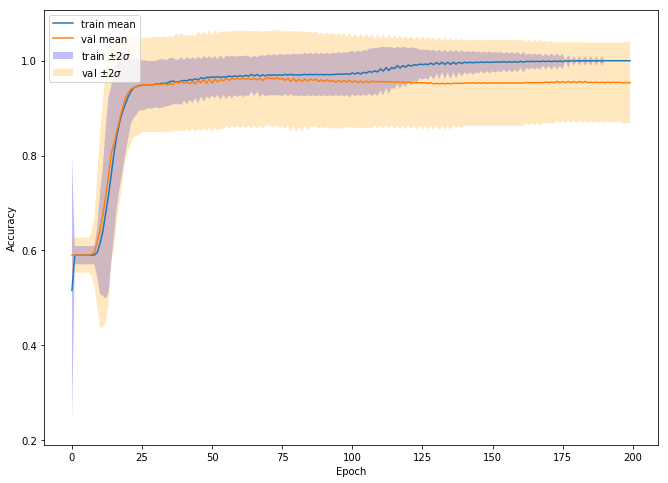

In [22]:
plot_stats('Accuracy', acc_history, val_acc_history)

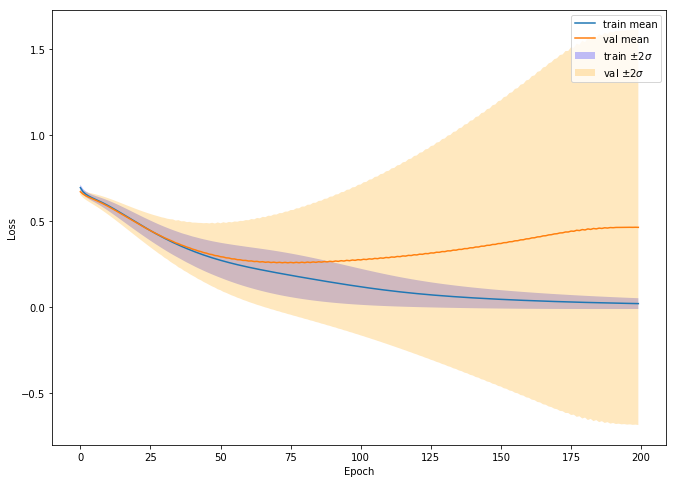

In [23]:
plot_stats('Loss', loss_history, val_loss_history)